# Preparação dos dados

### Preparação dos dados — Ingestão multi-anos + inferência de tipos

**Objetivo.** Carregar os CSVs (2021–2024), padronizar nomes de colunas, **inferir tipos corretos** (datas BR/ISO, números pt-BR, booleanos, categorias) e **reduzir memória**, gerando um **check de saúde** do dataset.

**O que a célula faz**
- Lê arquivos anuais, normaliza cabeçalhos (minúsculas, sem acento, `snake_case`) e adiciona `ano`.
- Verifica divergências de esquema entre anos (colunas faltantes/extras).
- Converte tipos:
  - **Datas/Horas:** detecta formatos BR/ISO/ISO-T e aplica fallback robusto.
  - **Números pt-BR:** remove milhar “.”, troca decimal “,” por “.”, faz *downcast* seguro.
  - **Booleanos:** mapeia `sim/não`, `1/0`, `true/false` para `boolean`.
  - **Categorias:** baixa cardinalidade → `category`.
- Aplica *downcast* numérico adicional e imprime **memória estimada**.
- Relata **linhas/colunas**, **top-15 nulos**, **amostra de dtypes** e exibe `head(10)`.

**Por que assim**
- Tipos corretos evitam erros em agregações e janelas temporais; `category` e *downcast* **economizam memória** e aceleram *groupby*.
- Normalização de colunas evita que diferenças entre anos quebrem o pipeline.

**Confira nos outputs**
- “**Conversões aplicadas**” (datas/números/booleanos/categorias).
- **Memória** menor que a leitura bruta.
- **% de nulos** e **dtypes** esperados (ex.: `data`/`horario` como `datetime64[ns]`, `uf`/`tipo_acidente` como `category`, `br`/`km` numéricos).


In [1]:
# -*- coding: utf-8 -*-
"""
PRF — Leitura multi-anos + inferência de tipos (datas BR/ISO, números pt-BR, booleanos) e otimização de memória
"""

import os
import re
import warnings
from typing import Optional

import numpy as np
import pandas as pd

# (Opcional) Silenciar só o aviso de fallback de datas, sem esconder outros
warnings.filterwarnings(
    "ignore",
    message="Could not infer format, so each element will be parsed individually",
    category=UserWarning
)

# ======================================================================
# 1) Leitura dos CSVs por ano (corrigido 2023) + padronização de colunas
# ======================================================================

ARQUIVOS = {
    2021: "acidentes2021_todas_causas_tipos.csv",
    2022: "acidentes2022_todas_causas_tipos.csv",
    2023: "acidentes2023_todas_causas_tipos.csv",  # <-- corrigido
    2024: "acidentes2024_todas_causas_tipos.csv",
}

frames = []
colunas_ref = None

def _normalize_cols(cols: pd.Index) -> pd.Index:
    return (
        cols
        .str.strip()
        .str.lower()
        .str.normalize("NFKD")
        .str.encode("ascii", errors="ignore")
        .str.decode("ascii")
        .str.replace(r"\s+", "_", regex=True)
    )

for ano, caminho in ARQUIVOS.items():
    if not os.path.exists(caminho):
        print(f"[AVISO] Arquivo não encontrado: {caminho}")
        continue

    df_y = pd.read_csv(
        caminho,
        encoding="latin1",
        sep=";",
        low_memory=False,
        dtype=str  # lê como texto, vamos inferir tipos depois
    )

    df_y.columns = _normalize_cols(df_y.columns)
    df_y["ano"] = str(ano)

    if colunas_ref is None:
        colunas_ref = df_y.columns
    else:
        diff_a = set(colunas_ref) - set(df_y.columns)
        diff_b = set(df_y.columns) - set(colunas_ref)
        if diff_a:
            print(f"[INFO] No ano {ano}, faltam colunas: {sorted(diff_a)}")
        if diff_b:
            print(f"[INFO] No ano {ano}, há colunas extras: {sorted(diff_b)}")

    frames.append(df_y)

if not frames:
    raise FileNotFoundError("Nenhum CSV encontrado. Verifique os caminhos em ARQUIVOS.")

df = pd.concat(frames, ignore_index=True, join="outer")

print("Shape concatenado:", df.shape)
print("Algumas colunas:", list(df.columns)[:12], "…")

# ======================================================================
# 2) Inferência de tipos + otimizações (sem infer_datetime_format)
# ======================================================================

def _maybe_datetime(s: pd.Series) -> Optional[pd.Series]:
    """
    Tenta converter para datetime detectando formatos comuns (BR e ISO)
    sem usar 'infer_datetime_format'. Se não detectar um formato dominante,
    faz fallback para pd.to_datetime(dayfirst=True).
    """
    sample = s.dropna().astype(str).str.strip()
    if sample.empty or sample.str.len().median() > 30:
        return None

    sample = sample.head(800)

    # padrões conhecidos -> formato strftime
    candidates = [
        (r"^\d{2}/\d{2}/\d{4}$",                     "%d/%m/%Y"),
        (r"^\d{2}/\d{2}/\d{4}\s+\d{2}:\d{2}$",       "%d/%m/%Y %H:%M"),
        (r"^\d{2}/\d{2}/\d{4}\s+\d{2}:\d{2}:\d{2}$", "%d/%m/%Y %H:%M:%S"),
        (r"^\d{4}-\d{2}-\d{2}$",                     "%Y-%m-%d"),
        (r"^\d{4}-\d{2}-\d{2}\s+\d{2}:\d{2}$",       "%Y-%m-%d %H:%M"),
        (r"^\d{4}-\d{2}-\d{2}\s+\d{2}:\d{2}:\d{2}$", "%Y-%m-%d %H:%M:%S"),
        (r"^\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}$",   "%Y-%m-%dT%H:%M:%S"),
    ]

    best_fmt = None
    best_cover = 0.0
    for pat, fmt in candidates:
        cover = sample.str.match(pat).mean()
        if cover > best_cover:
            best_cover = cover
            best_fmt = fmt

    # formato claro
    if best_fmt and best_cover >= 0.70:
        parsed = pd.to_datetime(s, format=best_fmt, errors="coerce")
        if parsed.notna().mean() >= 0.7 and parsed.dt.year.between(1900, 2100, inclusive="both").mean() > 0.95:
            return parsed

    # ISO com timezone/frac seconds (ex.: 2024-01-02T03:04:05-03:00 / .123Z) -> sem format
    iso_like = sample.str.contains(r"^\d{4}-\d{2}-\d{2}T", na=False).mean() > 0.3
    if iso_like:
        parsed_iso = pd.to_datetime(s, errors="coerce", utc=False)
        if parsed_iso.notna().mean() >= 0.7:
            return parsed_iso

    # fallback robusto BR/ISO sem format
    parsed = pd.to_datetime(s, errors="coerce", dayfirst=True)
    ok_ratio = parsed.notna().mean()
    if ok_ratio >= 0.7 and parsed.dt.year.between(1900, 2100, inclusive="both").mean() > 0.95:
        return parsed

    cleaned = s.astype(str).str.strip().replace({"": np.nan})
    parsed2 = pd.to_datetime(cleaned, errors="coerce", dayfirst=True)
    if parsed2.notna().mean() >= 0.7:
        return parsed2

    return None

def _maybe_numeric_br(s: pd.Series) -> Optional[pd.Series]:
    """Converte número brasileiro (milhar '.', decimal ',') e variantes."""
    sample = s.dropna().astype(str).head(800)
    if sample.empty:
        return None
    # se houver letras demais, provavelmente não é número
    if sample.str.contains(r"[A-Za-z]", na=False).mean() > 0.05:
        return None

    frac_comma = sample.str.contains(",", na=False).mean()

    t = s.astype(str).str.strip()
    # remove separador de milhar (.)
    t = t.str.replace(r"\.", "", regex=True)
    # vírgula como decimal -> ponto
    t = t.str.replace(",", ".", regex=False)

    num = pd.to_numeric(t, errors="coerce")
    ok_ratio = num.notna().mean()
    if ok_ratio >= 0.8 or (ok_ratio >= 0.6 and frac_comma > 0.2):
        # downcast final
        if pd.api.types.is_float_dtype(num):
            num = pd.to_numeric(num, downcast="float")
        else:
            num = pd.to_numeric(num, downcast="integer")
        return num
    return None

def _maybe_boolean(s: pd.Series) -> Optional[pd.Series]:
    """Mapeia variações de booleanos para True/False."""
    mapping = {
        "true": True, "false": False,
        "1": True, "0": False,
        "sim": True, "nao": False, "não": False,
        "s": True, "n": False,
        "yes": True, "no": False,
        "y": True, "t": True, "f": False
    }
    vals = s.astype(str).str.strip().str.lower()
    mask_known = vals.isin(mapping.keys())
    if mask_known.mean() >= 0.9:
        out = vals.map(mapping).astype("boolean")
        return out
    return None

def _low_cardinality(obj_series: pd.Series) -> bool:
    n = len(obj_series)
    if n == 0:
        return False
    u = obj_series.nunique(dropna=True)
    return (u <= 50) or (u / n <= 0.3)

def smart_infer_types(df_in: pd.DataFrame, try_dates_first: bool = True, verbose: bool = True) -> pd.DataFrame:
    converted = {}
    out = df_in.copy()

    # normaliza nulos comuns
    out = out.replace({"": np.nan, "NA": np.nan, "N/A": np.nan, "na": np.nan, "null": np.nan, "Null": np.nan})

    # tenta conversões em colunas 'object'/'string'
    for col in out.columns:
        s = out[col]
        if pd.api.types.is_object_dtype(s) or pd.api.types.is_string_dtype(s):
            was = s.dtype

            # 1) datas (prioriza nomes sugestivos)
            if try_dates_first or re.search(r"(data|dt|hora|timestamp)", col, flags=re.IGNORECASE):
                dt = _maybe_datetime(s)
                if dt is not None:
                    out[col] = dt
                    converted[col] = f"{was} -> datetime64[ns]"
                    continue

            # 2) booleanos
            b = _maybe_boolean(s)
            if b is not None:
                out[col] = b
                converted[col] = f"{was} -> boolean"
                continue

            # 3) numéricos pt-BR
            num = _maybe_numeric_br(s)
            if num is not None:
                out[col] = num
                if pd.api.types.is_integer_dtype(out[col]):
                    out[col] = pd.to_numeric(out[col], downcast="integer")
                elif pd.api.types.is_float_dtype(out[col]):
                    out[col] = pd.to_numeric(out[col], downcast="float")
                converted[col] = f"{was} -> {out[col].dtype}"
                continue

            # 4) categorias para baixa cardinalidade
            if _low_cardinality(s):
                out[col] = s.astype("category")
                converted[col] = f"{was} -> category"

    # downcast numérico geral
    for col in out.select_dtypes(include=["int", "float"]).columns:
        was = out[col].dtype
        out[col] = pd.to_numeric(out[col], downcast="integer")
        out[col] = pd.to_numeric(out[col], downcast="float")
        now = out[col].dtype
        if str(now) != str(was) and col not in converted:
            converted[col] = f"{was} -> {now}"

    if verbose:
        print("== Conversões aplicadas ==")
        if converted:
            for k, v in converted.items():
                print(f"- {k}: {v}")
        else:
            print("(nenhuma)")
        mem_mb = out.memory_usage(deep=True).sum() / (1024**2)
        print(f"Memória estimada: {mem_mb:.2f} MB")

    return out

# Executa a inferência
df = smart_infer_types(df, try_dates_first=True, verbose=True)

# ======================================================================
# 3) Relatório de saúde rápido
# ======================================================================

print("\n== Saúde do dataset ==")
print("- Linhas:", len(df))
print("- Colunas:", df.shape[1])

# Top 15 colunas com mais nulos
nul = df.isna().mean().sort_values(ascending=False).head(15)
print("\n% de nulos (top 15):")
print((nul * 100).round(2))

# Tipos finais
print("\nDtypes finais (amostra):")
print(df.dtypes.head(20))

# Confere possíveis campos de data mais comuns
for cand in ["data", "data_inversa", "datahora", "data_hora", "dt_registro", "horario", "ano"]:
    if cand in df.columns:
        print(f"{cand}: dtype={df[cand].dtype}, nulos={df[cand].isna().mean():.3f}")

# Visualização rápida
try:
    display(df.head(10))
except Exception:
    print("\n.head(10):")
    print(df.head(10))


Shape concatenado: (2117994, 38)
Algumas colunas: ['id', 'pesid', 'data_inversa', 'dia_semana', 'horario', 'uf', 'br', 'km', 'municipio', 'causa_principal', 'causa_acidente', 'ordem_tipo_acidente'] …


C:\Users\Demet\miniconda3\Lib\site-packages\pandas\core\dtypes\cast.py:377: RuntimeWarning: invalid value encountered in cast
  new_result = trans(result).astype(dtype)
C:\Users\Demet\miniconda3\Lib\site-packages\pandas\core\dtypes\cast.py:377: RuntimeWarning: invalid value encountered in cast
  new_result = trans(result).astype(dtype)


== Conversões aplicadas ==
- id: object -> float32
- pesid: object -> float32
- data_inversa: object -> datetime64[ns]
- dia_semana: object -> category
- horario: object -> datetime64[ns]
- uf: object -> category
- br: object -> float32
- km: object -> float32
- municipio: object -> category
- causa_principal: object -> boolean
- causa_acidente: object -> category
- ordem_tipo_acidente: object -> int8
- tipo_acidente: object -> category
- classificacao_acidente: object -> category
- fase_dia: object -> category
- sentido_via: object -> category
- condicao_metereologica: object -> category
- tipo_pista: object -> category
- tracado_via: object -> category
- uso_solo: object -> boolean
- id_veiculo: object -> float32
- tipo_veiculo: object -> category
- marca: object -> category
- ano_fabricacao_veiculo: object -> datetime64[ns]
- tipo_envolvido: object -> category
- estado_fisico: object -> category
- idade: object -> float32
- sexo: object -> category
- ilesos: object -> boolean
- feri

,id,pesid,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_principal,...,ilesos,feridos_leves,feridos_graves,mortos,latitude,longitude,regional,delegacia,uop,ano
0,331693.0,739775.0,2021-01-01,sexta-feira,2025-11-05 00:02:00,SC,101.0,314.899994,LAGUNA,True,...,True,False,False,False,-28.430294,-48.849251,SPRF-SC,DEL02-SC,UOP01-DEL02-SC,2021-01-01
1,331693.0,738219.0,2021-01-01,sexta-feira,2025-11-05 00:02:00,SC,101.0,314.899994,LAGUNA,True,...,True,False,False,False,-28.430294,-48.849251,SPRF-SC,DEL02-SC,UOP01-DEL02-SC,2021-01-01
2,331693.0,739774.0,2021-01-01,sexta-feira,2025-11-05 00:02:00,SC,101.0,314.899994,LAGUNA,True,...,False,True,False,False,-28.430294,-48.849251,SPRF-SC,DEL02-SC,UOP01-DEL02-SC,2021-01-01
3,331693.0,739775.0,2021-01-01,sexta-feira,2025-11-05 00:02:00,SC,101.0,314.899994,LAGUNA,True,...,True,False,False,False,-28.430294,-48.849251,SPRF-SC,DEL02-SC,UOP01-DEL02-SC,2021-01-01
4,331693.0,738219.0,2021-01-01,sexta-feira,2025-11-05 00:02:00,SC,101.0,314.899994,LAGUNA,True,...,True,False,False,False,-28.430294,-48.849251,SPRF-SC,DEL02-SC,UOP01-DEL02-SC,2021-01-01
5,331693.0,739774.0,2021-01-01,sexta-feira,2025-11-05 00:02:00,SC,101.0,314.899994,LAGUNA,True,...,False,True,False,False,-28.430294,-48.849251,SPRF-SC,DEL02-SC,UOP01-DEL02-SC,2021-01-01
6,331693.0,739775.0,2021-01-01,sexta-feira,2025-11-05 00:02:00,SC,101.0,314.899994,LAGUNA,True,...,True,False,False,False,-28.430294,-48.849251,SPRF-SC,DEL02-SC,UOP01-DEL02-SC,2021-01-01
7,331693.0,738219.0,2021-01-01,sexta-feira,2025-11-05 00:02:00,SC,101.0,314.899994,LAGUNA,True,...,True,False,False,False,-28.430294,-48.849251,SPRF-SC,DEL02-SC,UOP01-DEL02-SC,2021-01-01
8,331693.0,739774.0,2021-01-01,sexta-feira,2025-11-05 00:02:00,SC,101.0,314.899994,LAGUNA,True,...,False,True,False,False,-28.430294,-48.849251,SPRF-SC,DEL02-SC,UOP01-DEL02-SC,2021-01-01
9,331694.0,738742.0,2021-01-01,sexta-feira,2025-11-05 00:15:00,PR,376.0,188.000000,MARIALVA,True,...,False,True,False,False,-23.466349,-51.828080,SPRF-PR,DEL09-PR,UOP01-DEL09-PR,2021-01-01


### Etapa 2 — “Patch único” de dtypes e normalizações

**Objetivo.** Padronizar tipos e campos-chave em todo o dataset, de uma vez, garantindo coerência para as etapas de agregação temporal e modelagem.

**Principais ações**
- **IDs** (`id`, `pesid`, `id_veiculo`) → `string` (preserva zeros à esquerda e evita arredondamentos).
- **Datas** (`data_inversa`) → `datetime64[ns]`; cria `data` (apenas a data normalizada).
- **Horário** (`horario`) → texto `"HH:MM:SS"` e colunas auxiliares:  
  `segundos_desde_00` (`Int32`) e `hora` (`Int16`).
- **Numéricos:** `br`, `km` → `float32`; `latitude`, `longitude` → `float64`.
- **Inteiros nulos com menor dtype possível:** `ordem_tipo_acidente`, `idade`, `ano_fabricacao_veiculo`, `ano` → `Int8/16/32/64` conforme faixa.
- **Booleanos:** mapeia `sim/não`, `1/0`, `true/false` → `boolean`.
- **Categóricas:** `uf`, `municipio`, `tipo_acidente`, etc. → `category` (com ordenação em `dia_semana`).

**Por que assim**
- Evita inconsistências entre anos e **reduz memória** (downcast + category).
- Gera variáveis de tempo (hora/segundos) úteis para padrões intradiários.
- Inteiros nulos evitam *warnings* de casting e preservam ausências.

**Confira nos outputs**
- Bloco **“Schema aplicado”** (lista de conversões) e **memória estimada**.
- `df.dtypes` de amostra: `data`/`data_inversa` como datetime, `horario` como string, `br/km` float32, categóricas corretas.


In [2]:
# -*- coding: utf-8 -*-
"""
Patch único de dtypes para dataset PRF
- Mantém IDs como texto
- Datas (data_inversa) como datetime64[ns] (data)
- Horário normalizado "HH:MM:SS" + coluna auxiliar segundos desde 00:00
- Anos como inteiros nulos pequenos (Int16)
- Números (BR/KM) como float32; lat/long como float64
- Categóricas padronizadas
"""

import re
import numpy as np
import pandas as pd

# -----------------------------
# Helpers de conversão seguros
# -----------------------------

def to_str_id(s: pd.Series) -> pd.Series:
    out = (
        s.astype(object)
         .apply(lambda x: np.nan if pd.isna(x) else str(x))
         .str.replace(r"\.0$", "", regex=True)
         .str.strip()
         .replace({"": np.nan})
    )
    return out.astype("string")

def to_nullable_int_min_dtype(s: pd.Series) -> pd.Series:
    s_num = pd.to_numeric(s, errors="coerce")
    if s_num.notna().sum() == 0:
        return s_num.astype("Int32")
    vmin = int(np.nanmin(s_num))
    vmax = int(np.nanmax(s_num))
    if -128 <= vmin and vmax <= 127:
        return s_num.astype("Int8")
    if -32768 <= vmin and vmax <= 32767:
        return s_num.astype("Int16")
    if -2147483648 <= vmin and vmax <= 2147483647:
        return s_num.astype("Int32")
    return s_num.astype("Int64")

def to_float32(s: pd.Series) -> pd.Series:
    s_num = pd.to_numeric(s, errors="coerce")
    return pd.to_numeric(s_num, downcast="float")  # float32

def to_float64(s: pd.Series) -> pd.Series:
    s_num = pd.to_numeric(s, errors="coerce")
    return s_num.astype("float64")

def to_bool_series(s: pd.Series) -> pd.Series:
    mapping = {
        "true": True, "false": False,
        "1": True,   "0": False,
        "sim": True, "nao": False, "não": False,
        "s": True,   "n": False,
        "yes": True, "no": False,
        "y": True, "t": True, "f": False
    }
    vals = s.astype(str).str.strip().str.lower()
    known = vals.isin(mapping)
    out = pd.Series(pd.NA, index=s.index, dtype="boolean")
    out[known] = vals[known].map(mapping).astype("boolean")
    return out

def to_date(s: pd.Series) -> pd.Series:
    # aceita dd/mm/aaaa e ISO
    # tenta formato claro primeiro
    sample = s.dropna().astype(str).str.strip().head(800)
    patterns = [
        (r"^\d{2}/\d{2}/\d{4}$", "%d/%m/%Y"),
        (r"^\d{4}-\d{2}-\d{2}$", "%Y-%m-%d"),
    ]
    best = None; cov=0
    for pat, fmt in patterns:
        c = sample.str.match(pat).mean()
        if c > cov:
            cov=c; best=fmt
    if best and cov>=0.7:
        dt = pd.to_datetime(s, format=best, errors="coerce")
    else:
        dt = pd.to_datetime(s, errors="coerce", dayfirst=True)
    return dt

def norm_horario_to_hms_and_seconds(s: pd.Series) -> tuple[pd.Series, pd.Series, pd.Series]:
    """
    Retorna:
      - horario_hms: string 'HH:MM:SS'
      - segundos: Int32 segundos desde 00:00
      - hora: Int16 hora inteira
    """
    if pd.api.types.is_datetime64_any_dtype(s):
        hms = s.dt.strftime("%H:%M:%S")
    else:
        hms = s.astype(str).str.strip().str.extract(r"(?i)(\d{1,2}:\d{2}(?::\d{2})?)")[0]
        hms = hms.where(hms.isna(), hms.str.replace(r"^(\d{1,2}:\d{2})$", r"\1:00", regex=True))
    parts = hms.str.extract(r"(?P<h>\d{1,2}):(?P<m>\d{2}):(?P<s>\d{2})")
    for c in ["h","m","s"]:
        parts[c] = pd.to_numeric(parts[c], errors="coerce").astype("Int16")
    segundos = (parts["h"]*3600 + parts["m"]*60 + parts["s"]).astype("Int32")
    hora = parts["h"].astype("Int16")
    return hms.astype("string"), segundos, hora

def to_category(s: pd.Series, ordered=False, categories=None) -> pd.Series:
    if categories is not None:
        present = [c for c in categories if c in pd.Series(s).astype(str).unique().tolist()]
        if present:
            try:
                return s.astype("category").cat.set_categories(present, ordered=ordered)
            except Exception:
                pass
    return s.astype("category")

# ---------------------------------
# SCHEMA: coluna -> "conversor"
# (chaves são opcionais; só aplicam se coluna existir no df)
# ---------------------------------

SCHEMA = {
    # IDs/strings
    "id": to_str_id,
    "pesid": to_str_id,
    "id_veiculo": to_str_id,

    # Datas/horários
    "data_inversa": to_date, 

    # Numéricos
    "br": to_float32,
    "km": to_float32,
    "latitude": to_float64,
    "longitude": to_float64,

    # Inteiros nulos
    "ordem_tipo_acidente": to_nullable_int_min_dtype,
    "ano_fabricacao_veiculo": lambda s: to_nullable_int_min_dtype(
        s.dt.year if pd.api.types.is_datetime64_any_dtype(s)
        else s.astype(str).str.extract(r"(19\d{2}|20\d{2})")[0]
    ),
    "idade": to_nullable_int_min_dtype,
    "ano": lambda s: (s.dt.year.astype("Int16") if pd.api.types.is_datetime64_any_dtype(s)
                      else to_nullable_int_min_dtype(s)),

    # Booleanos
    "causa_principal": to_bool_series,
    "uso_solo": to_bool_series,
    "ilesos": to_bool_series,
    "feridos_leves": to_bool_series,
    "feridos_graves": to_bool_series,
    "mortos": to_bool_series,

    # Categóricas
    "dia_semana": lambda s: to_category(s, ordered=True, categories=[
        "domingo","segunda-feira","terça-feira","ter\u00e7a-feira","quarta-feira",
        "quinta-feira","sexta-feira","sábado","sabado"
    ]),
    "uf": to_category,
    "municipio": to_category,
    "causa_acidente": to_category,
    "tipo_acidente": to_category,
    "classificacao_acidente": to_category,
    "fase_dia": to_category,
    "sentido_via": to_category,
    "condicao_metereologica": to_category,
    "tipo_pista": to_category,
    "tracado_via": to_category,
    "tipo_veiculo": to_category,
    "marca": to_category,
    "tipo_envolvido": to_category,
    "estado_fisico": to_category,
    "sexo": to_category,
    "regional": to_category,
    "delegacia": to_category,
    "uop": to_category,
}

# ---------------------------------
# Função principal: aplica schema
# ---------------------------------

def apply_schema(df: pd.DataFrame, verbose: bool = True) -> pd.DataFrame:
    out = df.copy()
    changes = {}

    # 0) Normaliza alguns nulos
    out.replace({"": pd.NA, "NA": pd.NA, "N/A": pd.NA, "na": pd.NA, "null": pd.NA, "Null": pd.NA}, inplace=True)

    # 1) Converte colunas declaradas no SCHEMA
    for col, func in SCHEMA.items():
        if col in out.columns:
            before = str(out[col].dtype)
            try:
                out[col] = func(out[col])
                after = str(out[col].dtype)
                if before != after:
                    changes[col] = f"{before} -> {after}"
            except Exception as e:
                if verbose:
                    print(f"[WARN] Falha ao converter {col}: {e}")

    # 2) Horário: criar colunas auxiliares padronizadas
    if "horario" in out.columns:
        before = str(out["horario"].dtype)
        hms, segundos, hora = norm_horario_to_hms_and_seconds(out["horario"])
        out["horario"] = hms  # string "HH:MM:SS"
        out["segundos_desde_00"] = segundos
        out["hora"] = hora
        after = str(out["horario"].dtype)
        if before != after:
            changes["horario"] = f"{before} -> {after}"
        changes["segundos_desde_00"] = f"(nova) -> Int32"
        changes["hora"] = f"(nova) -> Int16"

    # 3) Data derivada “data” (data_inversa normalizada)
    if "data_inversa" in out.columns and pd.api.types.is_datetime64_any_dtype(out["data_inversa"]):
        out["data"] = out["data_inversa"].dt.normalize()
        changes["data"] = "(nova) -> datetime64[ns]"

    # 4) Peq. validações e ajustes finais: downcast seguros em numéricos
    for col in out.select_dtypes(include=["float64"]).columns:
        # manter lat/long como float64; demais pode downcast
        if col not in {"latitude","longitude"}:
            before = str(out[col].dtype)
            out[col] = pd.to_numeric(out[col], downcast="float")
            after = str(out[col].dtype)
            if before != after:
                changes[col] = f"{before} -> {after}"

    if verbose:
        print("== Schema aplicado ==")
        if changes:
            for k, v in changes.items():
                print(f"- {k}: {v}")
        else:
            print("(sem mudanças)")
        mem = out.memory_usage(deep=True).sum() / (1024**2)
        print(f"Memória estimada: {mem:.2f} MB")

    return out

# -----------------------------
# USO:
df = apply_schema(df, verbose=True)
# -----------------------------


== Schema aplicado ==
- id: float32 -> string
- pesid: float32 -> string
- id_veiculo: float32 -> string
- ordem_tipo_acidente: int8 -> Int8
- ano_fabricacao_veiculo: datetime64[ns] -> Int16
- idade: float32 -> Int16
- ano: datetime64[ns] -> Int16
- horario: datetime64[ns] -> string
- segundos_desde_00: (nova) -> Int32
- hora: (nova) -> Int16
- data: (nova) -> datetime64[ns]
Memória estimada: 644.53 MB


### Etapa 3 — Compactação extra (sem `pyarrow`)

**Objetivo.** Enxugar o `DataFrame` para reduzir memória/IO quando não há `pyarrow`, mantendo apenas colunas essenciais.

**Ações**
- **Downcast** de `latitude`/`longitude` para `float32`.
- Remove duplicidade de data: mantém apenas `data` (descarta `data_inversa`).
- Remove `horario` textual quando já existem `segundos_desde_00` e `hora`.
- **Encolhe categorias**: `remove_unused_categories()` em todas as `category`.

**Por que**
- Menos colunas e dtypes menores = **menos memória** e **arquivos menores** (CSV/CSV.GZ).
- Evita redundância (`data` vs. `data_inversa`, horário textual vs. numérico).

**Confira no output**
- Log `[MEM] Após ajustes extras: … MB` deve **cair** em relação à etapa anterior.
- `df.dtypes`: `latitude/longitude` em `float32`; ausência de `data_inversa`/`horario` (se substituídos).


In [3]:
# Mais compressão sem pyarrow

# 1) Downcast de lat/lon
for c in ["latitude", "longitude"]:
    if c in df.columns and pd.api.types.is_float_dtype(df[c]):
        df[c] = pd.to_numeric(df[c], downcast="float")  # float32

# 2) Evitar duplicidade: mantenha só uma coluna de data
if "data" in df.columns and "data_inversa" in df.columns:
    df = df.drop(columns=["data_inversa"])

# 3) Remover 'horario' textual se já tiver 'segundos_desde_00' e 'hora'
if "horario" in df.columns and {"segundos_desde_00", "hora"}.issubset(df.columns):
    df = df.drop(columns=["horario"])

# 4) Compactar categorias removendo níveis não usados
for c in df.select_dtypes(include="category").columns:
    df[c] = df[c].cat.remove_unused_categories()

mem_mb = df.memory_usage(deep=True).sum() / (1024**2)
print(f"[MEM] Após ajustes extras: {mem_mb:.2f} MB")


[MEM] Após ajustes extras: 512.62 MB


### Etapa 4 — Função de compactação (`compactar_df`)

**Objetivo.** Reduzir o uso de memória/armazenamento do `DataFrame` sem alterar o conteúdo analítico, tornando o notebook mais leve para as etapas seguintes.

**O que esta célula implementa**
- **Strings → `string[pyarrow]`** (quando disponível): representação mais compacta e rápida.
- **Remove redundância de horário**: por padrão, exclui `horario` textual e mantém `segundos_desde_00` e `hora`.
- **Downcast opcional de `latitude/longitude`** para `float32` (controle por parâmetro).
- **Compactação de categorias**: `remove_unused_categories()` em todas as colunas `category`.
- `pd.options.mode.string_storage = "pyarrow"` para priorizar backend pyarrow (se instalado).

**Parâmetros principais**
- `usar_string_pyarrow`: tenta converter colunas `string` para `string[pyarrow]`.
- `manter_horario_str`: `False` remove `horario` textual (recomendado).
- `downcast_latlon`: `True` aplica `float32` em `latitude/longitude` (pequena perda de precisão).
- `verbose`: imprime relatório de memória **Antes/Depois**.

**Confira no output**
- Log `[MEM] Antes | Depois` deve mostrar **redução** significativa de MB.
- Se `pyarrow` não estiver disponível, um aviso informará o *fallback* para `string` padrão.


In [4]:
import pandas as pd
import numpy as np

def compactar_df(df: pd.DataFrame,
                 usar_string_pyarrow: bool = True,
                 manter_horario_str: bool = False,
                 downcast_latlon: bool = False,
                 verbose: bool = True) -> pd.DataFrame:
    """
    - Converte strings para string[pyarrow] (muito mais leve) se disponível.
    - Remove redundâncias de horário (mantém só 'segundos_desde_00' e 'hora' por padrão).
    - Opcionalmente downcast em latitude/longitude para float32.
    """
    out = df.copy()
    before_mb = out.memory_usage(deep=True).sum() / (1024**2)

    # 1) Strings -> string[pyarrow] (recomendado)
    if usar_string_pyarrow:
        try:
            pd.Series(["teste"]).astype("string[pyarrow]")  # sanity check
            str_cols = out.select_dtypes(include=["string"]).columns.tolist()
            for c in str_cols:
                out[c] = out[c].astype("string[pyarrow]")
        except Exception as e:
            if verbose:
                print(f"[INFO] string[pyarrow] indisponível ({e}). Mantendo 'string' padrão.")

    # 2) Horário: por padrão, remover 'horario' texto (redundante)
    if "horario" in out.columns and not manter_horario_str:
        out.drop(columns=["horario"], inplace=True)

    # 3) Latitude/Longitude: opcionalmente usar float32 (perde ~1e-7 de precisão, em geral ok)
    if downcast_latlon:
        for c in ["latitude", "longitude"]:
            if c in out.columns and pd.api.types.is_float_dtype(out[c]):
                out[c] = pd.to_numeric(out[c], downcast="float")

    # 4) Confere categorias muito grandes e “compacta” dicionários
    # (re-criar categorias remove categorias "fantasma" e compacta o mapa)
    for c in out.select_dtypes(include="category").columns:
        out[c] = out[c].cat.remove_unused_categories()

    after_mb = out.memory_usage(deep=True).sum() / (1024**2)
    if verbose:
        print(f"[MEM] Antes: {before_mb:.2f} MB | Depois: {after_mb:.2f} MB")
    return out


pd.options.mode.string_storage = "pyarrow"  # precisa pandas>=2 e pyarrow instalado

df = compactar_df(
    df,
    usar_string_pyarrow=True,     # tenta string[pyarrow]
    manter_horario_str=False,     # remove 'horario' texto (fica só 'segundos_desde_00' e 'hora')
    downcast_latlon=False,        # mude para True se ok perder precisão
    verbose=True
)


[MEM] Antes: 512.62 MB | Depois: 262.79 MB


### Etapa 5 — Limpeza de valores, normalização de categorias e definição de segmentos

**Objetivo.** Tornar o dataset consistente para agregações e modelagem: remover duplicatas, corrigir faixas inválidas, padronizar categorias, tratar raras e criar um identificador de segmento estável.

**Ações principais**
- **Garantias temporais:** cria `data` (se faltar) e `ano`; filtra **2021–2024**.
- **Deduplicação:** remove duplicatas por `id,data,uf,br,km,tipo_acidente` (se existirem).
- **Faixas válidas:** `br∈[0,999]`, `km≥0`, `lat∈[-90,90]`, `lon∈[-180,180]`, `idade∈[0,120]`, `ano_fabricacao_veiculo∈[1980,2025]`.
- **Normalização de texto (categorias):** minúsculas, sem acento, colapso de espaços; agrupamento de **condição meteorológica** (ex.: “chuva/garoa/precipitação” → `chuva`, “neblina/nevoeiro/cerracao” → `neblina`).
- **Booleanos coerentes:** mapeia `sim/não`, `1/0`, `true/false` → `boolean`.
- **Categorias raras:** `marca`, `municipio`, `tipo_veiculo` com frequência < 0,5% → `outros`.
- **Segmentação estável:** `km_bin5 = floor(km/5)*5`; **`segmento_id = UF-BR-km_bin5`**.

**Por que assim**
- Evita vazamento/ruído por inconsistências; reduz cardinalidade e melhora a robustez dos modelos.
- `segmento_id` em janelas de 5 km estabiliza o alvo ao longo do tempo.

**Confira no output**
- Resumo final: **linhas/colunas**, **top-10 nulos** e **memória** (MB).
- Presença de `km_bin5` e `segmento_id`; categorias padronizadas e sem valores impossíveis.


In [5]:
import pandas as pd
pd.options.mode.string_storage = "python"


In [6]:
import numpy as np
import pandas as pd
import unicodedata
import re

# ---------- helpers ----------
def normalize_text(s: pd.Series) -> pd.Series:
    s = s.astype(str).str.strip()
    # remove acentos
    s = s.map(lambda x: unicodedata.normalize("NFKD", x).encode("ascii", "ignore").decode("ascii"))
    # lower e colapsa espacos
    s = s.str.lower().str.replace(r"\s+", " ", regex=True)
    # trata nulos
    s = s.replace({"nan": np.nan, "none": np.nan, "": np.nan})
    return s

def collapse_rare_categories(s: pd.Series, min_freq=0.005, outros="outros") -> pd.Series:
    # min_freq = fração mínima para manter categoria
    vc = s.value_counts(dropna=True, normalize=True)
    rare = vc[vc < min_freq].index
    return s.where(~s.isin(rare), outros)

def coerce_range(s: pd.Series, lo=None, hi=None) -> pd.Series:
    out = pd.to_numeric(s, errors="coerce")
    if lo is not None:
        out = out.where(out >= lo, np.nan)
    if hi is not None:
        out = out.where(out <= hi, np.nan)
    return out

# Garante 'data' (normalizada) e 'ano'
if "data" not in df.columns and "data_inversa" in df.columns and pd.api.types.is_datetime64_any_dtype(df["data_inversa"]):
    df["data"] = df["data_inversa"].dt.normalize()
if "ano" not in df.columns and "data" in df.columns and pd.api.types.is_datetime64_any_dtype(df["data"]):
    df["ano"] = df["data"].dt.year.astype("Int16")

print("Linhas iniciais:", len(df))

# ---------- 1) duplicatas óbvias ----------
dup_keys = [c for c in ["id","data","uf","br","km","tipo_acidente"] if c in df.columns]
if dup_keys:
    before = len(df)
    df = df.drop_duplicates(subset=dup_keys, keep="first")
    print(f"[dedup] removidas {before - len(df)} duplicatas por chaves {dup_keys}")

# ---------- 2) consistência temporal ----------
if "ano" in df.columns:
    before = len(df)
    df = df[(df["ano"].astype("Int32") >= 2021) & (df["ano"].astype("Int32") <= 2024)]
    print(f"[ano] removidas {before - len(df)} linhas fora de 2021–2024")

if "ano_fabricacao_veiculo" in df.columns:
    df["ano_fabricacao_veiculo"] = coerce_range(df["ano_fabricacao_veiculo"], lo=1980, hi=2025).astype("Int16")

# ---------- 3) faixas e valores impossíveis ----------
if "br" in df.columns:
    df["br"] = coerce_range(df["br"], lo=0, hi=999).astype("float32")
if "km" in df.columns:
    df["km"] = coerce_range(df["km"], lo=0).astype("float32")
if {"latitude","longitude"}.issubset(df.columns):
    df["latitude"]  = coerce_range(df["latitude"],  lo=-90,  hi=90).astype("float32")
    df["longitude"] = coerce_range(df["longitude"], lo=-180, hi=180).astype("float32")
if "idade" in df.columns:
    df["idade"] = coerce_range(df["idade"], lo=0, hi=120).astype("Int16")

# ---------- 4) normalização de categóricas ----------
cat_cols = [c for c in [
    "uf","municipio","condicao_metereologica","tipo_acidente","classificacao_acidente",
    "fase_dia","sentido_via","tipo_pista","tracado_via","tipo_veiculo","marca",
    "tipo_envolvido","estado_fisico","sexo","dia_semana","regional","delegacia","uop"
] if c in df.columns]

for c in cat_cols:
    # preserva dtype category se já for
    was_cat = str(df[c].dtype) == "category"
    norm = normalize_text(df[c])
    # unificação específica de tempo/clima
    if c == "condicao_metereologica":
        # mapeia para grupos canônicos
        m = {
            "chuva": "chuva", "chuvoso": "chuva", "garoa": "chuva", "precipitacao": "chuva", "tempo chuvoso": "chuva",
            "neblina": "neblina", "nevoeiro": "neblina", "cerração": "neblina",
            "ensolarado": "bom", "céu claro": "bom", "ceu claro": "bom", "bom": "bom",
        }
        # aplica mapeamento por contains simples
        tmp = norm.copy()
        tmp = np.where(tmp.str.contains("chuva|chuv|garoa|precipit", na=False), "chuva", tmp)
        tmp = np.where(pd.Series(tmp).str.contains("neblin|nevoeir|cerrac", na=False), "neblina", tmp)
        norm = pd.Series(tmp, index=df.index).astype("string")
    # aplica e retorna a category se era category
    df[c] = norm.astype("string")
    if was_cat:
        df[c] = df[c].astype("category")

# ---------- 5) booleanos coerentes ----------
bool_cols = [c for c in ["ilesos","feridos_leves","feridos_graves","mortos","uso_solo","causa_principal"] if c in df.columns]
if bool_cols:
    mapping = {"true": True, "false": False, "1": True, "0": False, "sim": True, "nao": False, "não": False, "s": True, "n": False, "y": True, "t": True, "f": False}
    for c in bool_cols:
        vals = df[c].astype(str).str.strip().str.lower()
        df[c] = vals.map(mapping).astype("boolean")

# ---------- 6) rare categories ----------
rare_cols = [c for c in ["marca","municipio","tipo_veiculo"] if c in df.columns]
for c in rare_cols:
    base = df[c].astype("string")
    df[c] = collapse_rare_categories(base, min_freq=0.005, outros="outros").astype("string")

# ---------- 7) segmentação estável ----------
if {"uf","br","km"}.issubset(df.columns):
    # bin de 5 km
    km_bin5 = (np.floor(pd.to_numeric(df["km"], errors="coerce")/5)*5).astype("Int32")
    br_i = pd.to_numeric(df["br"], errors="coerce").round().astype("Int32")
    uf_s = df["uf"].astype("string")
    df["km_bin5"] = km_bin5
    df["segmento_id"] = (uf_s.fillna("NA") + "-" + br_i.astype("string").fillna("NA") + "-" + km_bin5.astype("string").fillna("NA")).astype("string")

# ---------- 8) relatórios rápidos ----------
def pct_nulls(s): return float(s.isna().mean()*100)
print("\n[resumo]")
print("- linhas:", len(df), "| colunas:", df.shape[1])
print("- nulos (top 10):")
print(df.isna().mean().mul(100).sort_values(ascending=False).head(10).round(2))
mem_mb = df.memory_usage(deep=True).sum()/(1024**2)
print(f"- memória ~ {mem_mb:.2f} MB")


Linhas iniciais: 2117994
[dedup] removidas 1678223 duplicatas por chaves ['id', 'data', 'uf', 'br', 'km', 'tipo_acidente']
[ano] removidas 0 linhas fora de 2021–2024

[resumo]
- linhas: 439771 | colunas: 41
- nulos (top 10):
longitude                 27.82
latitude                  27.81
idade                     12.91
ano_fabricacao_veiculo     7.35
ilesos                     4.85
estado_fisico              4.85
tipo_envolvido             4.85
sexo                       4.85
pesid                      4.85
feridos_leves              4.85
dtype: float64
- memória ~ 151.29 MB


### Etapa 6 — Flags de missing, imputações suaves e salvamento robusto

**Objetivo.** Criar *features* baratas de qualidade de dados, imputar valores simples sem distorcer a distribuição e persistir o dataset de forma confiável no ambiente disponível.

**O que a célula faz**
- **Flags de missing** (`m_*`) para: `latitude`, `longitude`, `idade`, `ano_fabricacao_veiculo`, `pesid`; e **`has_geo`** (1 se há lat/lon).
- **Booleanos nulos → False**: (`ilesos`, `feridos_leves`, `feridos_graves`, `mortos`, `uso_solo`, `causa_principal`).
- **Imputações suaves (mediana)**:
  - `idade` por **mediana de `tipo_envolvido`** (fallback: mediana global).
  - `ano_fabricacao_veiculo` por **mediana de `tipo_veiculo`** (fallback: mediana global).
  - *Casting* final para `Int16`.
- **Salvamento robusto**:
  1) Tenta **Parquet/`fastparquet`** (converte `string` → `object` para compatibilidade).  
  2) Fallback: **Parquet/`pyarrow`**.  
  3) Fallback final: **CSV.gz**.
  - Compressão `zstd` no Parquet; `gzip` para CSV.

**Por que assim**
- Flags de missing ajudam o modelo a aproveitar a informação de ausência/presença.
- Imputação por mediana *condicionada* reduz viés e mantém robustez.
- Persistência resiliente evita travas de ambiente (conflitos `pyarrow`/extensões).

**Saídas esperadas**
- Novas colunas: `m_*`, `has_geo`; `idade` e `ano_fabricacao_veiculo` sem outliers nulos comuns.
- Mensagem `[OK] Parquet salvo ...` ou fallback informando **CSV.gz** salvo.


In [7]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import warnings

# Garantir que o pandas não tente usar string[pyarrow] se você não tem pyarrow adequado
pd.options.mode.string_storage = "python"

# =========================
# 1) FLAGS e ajustes mínimos
# =========================

# Flags de missing (features baratas)
flag_cols = ["latitude","longitude","idade","ano_fabricacao_veiculo","pesid"]
for c in flag_cols:
    if c in df.columns:
        df[f"m_{c}"] = df[c].isna().astype("Int8")

# Marcador de geolocalização presente
if {"latitude","longitude"}.issubset(df.columns):
    df["has_geo"] = (~df["latitude"].isna() & ~df["longitude"].isna()).astype("Int8")

# Booleans -> False quando nulo
bool_cols = [c for c in ["ilesos","feridos_leves","feridos_graves","mortos","uso_solo","causa_principal"] if c in df.columns]
for c in bool_cols:
    df[c] = df[c].fillna(False)

# =========================
# 2) IMPUTAÇÕES SUAVES
# =========================
# FutureWarning do groupby: defina observed=False (comportamento atual)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")  # silencia avisos de dtype/conversão pontuais

    # idade por mediana do tipo_envolvido (fallback: mediana global)
    if "idade" in df.columns:
        med_global_idade = df["idade"].median()
        if "tipo_envolvido" in df.columns:
            med_tipo = df.groupby("tipo_envolvido", dropna=False, observed=False)["idade"].median()
            def imp_idade(row):
                if pd.isna(row["idade"]):
                    return med_tipo.get(row.get("tipo_envolvido"), med_global_idade)
                return row["idade"]
            df["idade"] = df.apply(imp_idade, axis=1)
        df["idade"] = pd.to_numeric(df["idade"], errors="coerce").astype("Int16")

    # ano_fabricacao_veiculo por mediana do tipo_veiculo (fallback: mediana global)
    if "ano_fabricacao_veiculo" in df.columns:
        med_global_ano = df["ano_fabricacao_veiculo"].median()
        if "tipo_veiculo" in df.columns:
            med_veic = df.groupby("tipo_veiculo", dropna=False, observed=False)["ano_fabricacao_veiculo"].median()
            def imp_ano(row):
                if pd.isna(row["ano_fabricacao_veiculo"]):
                    return med_veic.get(row.get("tipo_veiculo"), med_global_ano)
                return row["ano_fabricacao_veiculo"]
            df["ano_fabricacao_veiculo"] = df.apply(imp_ano, axis=1)
        df["ano_fabricacao_veiculo"] = pd.to_numeric(df["ano_fabricacao_veiculo"], errors="coerce").astype("Int16")

# =========================
# 3) SALVAMENTO ROBUSTO
# =========================

def safe_to_parquet(df: pd.DataFrame, path: str = "prf_clean.parquet") -> None:
    """
    Tenta salvar com fastparquet; se indisponível, tenta pyarrow.
    Se pyarrow apresentar ArrowKeyError/extension conflict, cai para CSV.gz.
    Converte colunas string -> object ao usar fastparquet (evita incompatibilidades).
    """
    # Preferir fastparquet neste ambiente (evita conflitos pyarrow/pandas)
    try:
        import fastparquet  # noqa: F401
        # fastparquet às vezes não lida bem com dtype 'string' -> converte para object
        str_cols = df.select_dtypes(include="string").columns
        if len(str_cols):
            df_fp = df.copy()
            df_fp[str_cols] = df_fp[str_cols].astype(object)
        else:
            df_fp = df
        df_fp.to_parquet(path, index=False, compression="zstd", engine="fastparquet")
        print(f"[OK] Parquet salvo com fastparquet -> {path}")
        return
    except Exception as e_fast:
        print(f"[INFO] fastparquet indisponível ou falhou ({e_fast}). Tentando pyarrow...")

    # Fallback: pyarrow
    try:
        import pyarrow  # noqa: F401
        df.to_parquet(path, index=False, compression="zstd", engine="pyarrow")
        print(f"[OK] Parquet salvo com pyarrow -> {path}")
        return
    except Exception as e_arrow:
        print(f"[WARN] pyarrow falhou ({e_arrow.__class__.__name__}: {e_arrow}). Salvando CSV.gz...")

    # Último fallback: CSV gzip
    csv_path = path.replace(".parquet", ".csv.gz")
    df.to_csv(csv_path, index=False, compression="gzip")
    print(f"[OK] CSV.gz salvo -> {csv_path}")

# Execute o salvamento robusto:
safe_to_parquet(df, "prf_clean.parquet")


[INFO] fastparquet indisponível ou falhou (No module named 'fastparquet'). Tentando pyarrow...
[OK] Parquet salvo com pyarrow -> prf_clean.parquet


# Boosting (HGB)

### Etapa 7 — Releitura leve do dataset salvo (tipos otimizados)

**Objetivo.** Carregar o arquivo persistido (`prf_clean.csv.gz`) já com **dtypes enxutos**, evitando custo de conversão a cada sessão.

**O que a célula faz**
- Define um **esquema mínimo (`DTYPES`)** para inteiros nulos (`Int16/Int32/Int8`), `float32` (BR/KM/lat/lon) e flags (`Int8`).
- Garante **booleanos** nativos (`boolean`) para colunas de desfecho/ocorrência.
- Faz `parse_dates` de `data`.
- (Opcional) Reconverte colunas textuais relevantes para **`category`** (economia de RAM).

**Por que assim**
- A leitura já tipada evita *downcasts* posteriores e reduz memória desde o início.
- `category` acelera *groupby* e operações de filtragem.

**Confira no output**
- `shape` e **memória total (MB)** do `DataFrame`.
- `df.dtypes` deve refletir `Int*`, `float32`, `boolean`, `category` e `datetime64[ns]` conforme esperado.


In [8]:
import pandas as pd
import numpy as np

# Esquema mínimo pra manter tipos úteis na leitura
DTYPES = {
    "idade": "Int16",
    "ano_fabricacao_veiculo": "Int16",
    "segundos_desde_00": "Int32",
    "hora": "Int16",
    "m_latitude": "Int8",
    "m_longitude": "Int8",
    "m_idade": "Int8",
    "m_ano_fabricacao_veiculo": "Int8",
    "m_pesid": "Int8",
    "has_geo": "Int8",
    "br": "float32",
    "km": "float32",
    "latitude": "float32",
    "longitude": "float32",
}

BOOLS = ["ilesos","feridos_leves","feridos_graves","mortos","uso_solo","causa_principal"]

df = pd.read_csv(
    "prf_clean.csv.gz",
    dtype=DTYPES | {b: "boolean" for b in BOOLS if b in DTYPES or True},  # garante boolean
    parse_dates=[c for c in ["data"] if c],  # adiciona outras datas se tiver
    low_memory=False
)

# (Opcional) reconverter algumas colunas textuais para category (economia de RAM)
for c in ["uf","municipio","condicao_metereologica","tipo_acidente","classificacao_acidente",
          "fase_dia","sentido_via","tipo_pista","tracado_via","tipo_veiculo",
          "marca","tipo_envolvido","estado_fisico","sexo","regional","delegacia","uop"]:
    if c in df.columns:
        df[c] = df[c].astype("category")

print(df.shape, df.memory_usage(deep=True).sum()/(1024**2), "MB")


(439771, 47) 143.58460140228271 MB


### Etapa 8 — Pipeline de modelagem (agregação semanal, alvo *t+1*, lags/rollings, split temporal e baseline)

**Objetivo.** Prever se **no próximo intervalo semanal** haverá ≥1 acidente em cada segmento (UF–BR–km).  
Tarefa: **classificação binária** com validação temporal (*train*: 2021–2023; *test*: 2024).

**Passos da célula**
1. **Agregação densa semanal**
   - `sem_ini = segunda-feira` da semana (ISO).
   - Conta de acidentes por `(uf, br, km, sem_ini)` e proporção de eventos à noite `p_noite`.
   - **Densificação**: insere semanas ausentes com `acidentes=0` (evita vieses por ausência de registros).

2. **Alvo supervisionado**
   - `y_next = 1` se **na semana seguinte** o segmento tiver `acidentes ≥ 1`, senão `0`.

3. **Features temporais por segmento**
   - **Lags** de `acidentes`: `lag1, lag4, lag12`.
   - **Médias móveis** (com *min_periods* robusto): `rollmean4, 12, 24`.
   - `p_noite` com médias móveis (`12, 24`), quando disponível.

4. **Split temporal (sem *leakage*)**
   - `Treino`: `ano_iso < 2024`.
   - `Teste`: `ano_iso == 2024`.

5. **Modelo baseline**
   - `HistGradientBoostingClassifier` com `class_weight="balanced"` (mitiga desbalanceamento), `max_depth=6`, `learning_rate=0.06`.
   - Saída de **probabilidade** por segmento/semana.

6. **Avaliação**
   - **ROC-AUC** (discriminação global) e **PR-AUC** (melhor para classes raras).
   - **Limiar por F1** via *precision–recall curve* (referência para decisão).
   - **Ranking metrics**: `P@K`, `R@K`, `Lift@K` (K ∈ {50,100,200,500,1000}) — úteis para priorização operacional.

**Por que assim**
- A densificação semanal evita que a ausência de registros seja confundida com ausência de risco.
- Lags e *rollings* capturam **inércia** e **sazonalidade local** por segmento.
- Validação temporal reflete o cenário real de previsão (treinar no passado, testar no futuro).
- O HGB (`HistGradientBoosting`) é um baseline forte para tabulares, lida bem com não linearidades e interações simples.

**Saídas esperadas no console**
- Tamanhos de treino/teste e taxa de positivos no teste.
- `ROC-AUC`, `PR-AUC`, limiar de maior `F1` com `P` e `R`.
- Tabela de `P@K`, `R@K`, `Lift@K` para diferentes cortes de priorização.


In [9]:
# ==============================================
# Pipeline compacto e robusto para modelagem
# - agrega semanalmente (com semanas sem acidente)
# - cria alvo t+1, lags e rollings (grupo-a-grupo)
# - split temporal (2021–23 vs 2024) e baseline
# ==============================================

import numpy as np
import pandas as pd
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_curve

# ------------ (opcional) carregar do CSV gzip ------------
# try:
#     df
# except NameError:
#     df = pd.read_csv("prf_clean.csv.gz", low_memory=False, parse_dates=["data"])
# ---------------------------------------------------------

# ---------- helpers ----------
def week_start_monday(d: pd.Series) -> pd.Series:
    s = pd.to_datetime(d)
    s = s.dt.normalize()
    return s - pd.to_timedelta(s.dt.weekday, unit="D")  # segunda-feira

def dense_weekly_agg(df: pd.DataFrame) -> pd.DataFrame:
    """
    Agrega por semana e DENSIFICA a série (inclui semanas sem acidentes).
    Chaves: (uf, br, km, sem_ini). Também devolve ano_iso/semana numérica.
    """
    g = df.copy()
    g["data"] = pd.to_datetime(g["data"]).dt.normalize()
    g["sem_ini"] = week_start_monday(g["data"])

    # marcador de noite se não existir
    if "eh_noite" not in g.columns:
        if "hora" in g.columns and not pd.isna(g["hora"]).all():
            g["eh_noite"] = ((g["hora"] >= 19) | (g["hora"] <= 5)).astype("Int8")
        elif "segundos_desde_00" in g.columns and not pd.isna(g["segundos_desde_00"]).all():
            s = g["segundos_desde_00"]
            g["eh_noite"] = ((s >= 19*3600) | (s <= 5*3600)).astype("Int8")
        else:
            g["eh_noite"] = 0

    # tipos seguros nas chaves
    g["uf"] = g["uf"].astype(object)
    g["br"] = pd.to_numeric(g["br"], errors="coerce")
    g["km"] = pd.to_numeric(g["km"], errors="coerce")

    # agrega semanas observadas
    keys = ["uf","br","km","sem_ini"]
    agg = (
        g.groupby(keys, observed=True, sort=False)
         .agg(
             acidentes=("data","size"),
             p_noite=("eh_noite", "mean")
         )
         .reset_index()
    )

    # densificar por segmento
    def reindex_segment(seg_df):
        start = seg_df["sem_ini"].min()
        end   = seg_df["sem_ini"].max()
        full_idx = pd.date_range(start, end, freq="W-MON")  # todas as segundas
        seg = seg_df.set_index("sem_ini").reindex(full_idx)
        seg.index.name = "sem_ini"
        seg["acidentes"] = seg["acidentes"].fillna(0).astype("Int16")
        seg["p_noite"]   = seg["p_noite"].fillna(0.0).astype("float32")
        # restaurar chaves
        for c in ["uf","br","km"]:
            seg[c] = seg_df[c].iloc[0]
        return seg.reset_index()

    dense = (
        agg.groupby(["uf","br","km"], observed=True, sort=False, group_keys=False)
           .apply(reindex_segment)
           .reset_index(drop=True)
    )

    # ano_iso/semana (para split e ordenação)
    iso = dense["sem_ini"].dt.isocalendar()
    dense["ano_iso"] = iso["year"].astype("Int16")
    dense["semana"]  = iso["week"].astype("Int8")

    return dense

def add_lags_rollings_groupwise(df_in: pd.DataFrame,
                                col="acidentes",
                                group_cols=["uf","br","km"],
                                order_col="sem_ini") -> pd.DataFrame:
    """
    Lags e médias móveis por grupo, atribuindo por índice (sem reindex/reset_index),
    robusto a MultiIndex não-único.
    """
    out = df_in.sort_values(group_cols + [order_col]).copy()

    # pré-cria colunas
    for L in [1,4,12]:
        out[f"{col}_lag{L}"] = np.nan
    for W in [4,12,24]:
        out[f"{col}_rollmean{W}"] = np.nan
    if "p_noite" in out.columns:
        for W in [12,24]:
            out[f"p_noite_rollmean{W}"] = np.nan

    # calcula grupo-a-grupo e atribui por .loc[idx]
    for _, g in out.groupby(group_cols, sort=False, observed=True):
        idx  = g.index
        vals = g[col].astype("float32")

        out.loc[idx, f"{col}_lag1"]  = vals.shift(1).to_numpy()
        out.loc[idx, f"{col}_lag4"]  = vals.shift(4).to_numpy()
        out.loc[idx, f"{col}_lag12"] = vals.shift(12).to_numpy()

        s = vals.shift(1)
        for W in [4,12,24]:
            out.loc[idx, f"{col}_rollmean{W}"] = s.rolling(W, min_periods=max(2, W//2)).mean().to_numpy()

        if "p_noite" in g.columns:
            pn = g["p_noite"].astype("float32").shift(1)
            for W in [12,24]:
                out.loc[idx, f"p_noite_rollmean{W}"] = pn.rolling(W, min_periods=max(2, W//2)).mean().to_numpy()

    return out

def pk_lift(y_true, y_score, k):
    k = min(k, len(y_true))
    order = np.argsort(-y_score)[:k]
    p_at_k = y_true.iloc[order].mean()
    base = y_true.mean()
    lift = (p_at_k/base) if base > 0 else np.nan
    r_at_k = y_true.iloc[order].sum() / y_true.sum() if y_true.sum() > 0 else np.nan
    return p_at_k, r_at_k, lift

# ===== 1) agregação densa =====
assert {"data","uf","br","km"}.issubset(df.columns), "df precisa ter colunas: data, uf, br, km"
agg = dense_weekly_agg(df)  # inclui semanas com 0

# ===== 2) alvo t+1 por segmento =====
agg = agg.sort_values(["uf","br","km","sem_ini"])
agg["y_next"] = (
    agg.groupby(["uf","br","km"], observed=True, sort=False)["acidentes"]
       .shift(-1)
       .fillna(0)
       .ge(1)
       .astype("Int8")
)

# ===== 3) lags & rollings =====
agg = add_lags_rollings_groupwise(agg, col="acidentes", group_cols=["uf","br","km"], order_col="sem_ini")

# ===== 4) montar X/y e split temporal =====
feat_cols = [c for c in [
    "acidentes","acidentes_lag1","acidentes_lag4","acidentes_lag12",
    "acidentes_rollmean4","acidentes_rollmean12","acidentes_rollmean24",
    "p_noite","p_noite_rollmean12","p_noite_rollmean24"
] if c in agg.columns]

mask = agg[feat_cols].notna().all(axis=1)
X = agg.loc[mask, feat_cols].reset_index(drop=True)
y = agg.loc[mask, "y_next"].astype(int).reset_index(drop=True)
years = agg.loc[mask, "ano_iso"].reset_index(drop=True)

is_train = years < 2024
Xtr, Xte = X[is_train], X[~is_train]
ytr, yte = y[is_train], y[~is_train]

print(f"Treino: {Xtr.shape} | Teste: {Xte.shape} | Positivos teste: {int(yte.sum())}/{len(yte)} ({yte.mean():.3f})")

# ===== 5) baseline =====
clf = HistGradientBoostingClassifier(
    max_depth=6, max_iter=300, learning_rate=0.06,
    class_weight="balanced", random_state=42
)
clf.fit(Xtr, ytr)
p = clf.predict_proba(Xte)[:, 1]

roc = roc_auc_score(yte, p)
pr  = average_precision_score(yte, p)
print(f"ROC-AUC={roc:.3f} | PR-AUC={pr:.3f}")

# ===== 6) limiar (referência) =====
prec, rec, thr = precision_recall_curve(yte, p)
f1 = (2*prec*rec)/(prec+rec+1e-12)
best = int(np.nanargmax(f1))
print(f"Limiar* = {thr[best]:.3f} | F1={f1[best]:.3f} (P={prec[best]:.3f}, R={rec[best]:.3f})  *referência")

# ===== 7) P@K / Lift@K =====
for k in [50,100,200,500,1000]:
    if len(yte) >= k:
        pk, rk, lt = pk_lift(yte, p, k)
        print(f"K={k:4d} | P@K={pk:.3f} | R@K={rk:.3f} | Lift@K={lt:.2f}")


C:\Users\Demet\AppData\Local\Temp\ipykernel_19500\2520367886.py:77: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(reindex_segment)


Treino: (2918734, 10) | Teste: (743511, 10) | Positivos teste: 50203/743511 (0.068)
ROC-AUC=0.623 | PR-AUC=0.145
Limiar* = 0.721 | F1=0.211 (P=0.190, R=0.238)  *referência
K=  50 | P@K=0.600 | R@K=0.001 | Lift@K=8.89
K= 100 | P@K=0.580 | R@K=0.001 | Lift@K=8.59
K= 200 | P@K=0.565 | R@K=0.002 | Lift@K=8.37
K= 500 | P@K=0.522 | R@K=0.005 | Lift@K=7.73
K=1000 | P@K=0.496 | R@K=0.010 | Lift@K=7.35


### Etapa 9 — Predição semanal em segmentos de 5 km (pipeline sem warnings)

**Objetivo.** Prever, para cada segmento **(UF–BR–km agrupado em faixas de 5 km)** e semana ISO, se **na semana seguinte** haverá ≥1 acidente. Tarefa de **classificação binária** com validação temporal.

**O que esta célula faz**
1. **Preparação & segmentação**
   - Normaliza `data`, define `km_bin5` (faixas de 5 km) e cria `eh_noite` se necessário (19h–05h).
2. **Agregação semanal densa**
   - Agrega por `(uf, br, km_bin5, sem_ini)` contando `acidentes` e média `p_noite`.
   - **Densifica** o histórico por segmento (insere semanas sem registros com `acidentes=0`).
3. **Alvo supervisionado (t+1)**
   - `y_next = 1` se **na semana seguinte** o segmento tem `acidentes ≥ 1`, senão `0`.
4. **Features temporais por segmento**
   - **Lags**: `acidentes_lag1`, `lag4`, `lag12`.
   - **Rollings causais** (com *min_periods* robusto): `rollmean4`, `rollmean12`, `rollmean24` de acidentes; e `p_noite_rollmean12`, `p_noite_rollmean24`.
   - **Recência**: `since_last_acc` (semanas desde último acidente) e contagens `cnt_last4`, `cnt_last12`.
5. **Split temporal (sem vazamento)**
   - **Treino:** 2021–2023 (`ano_iso < 2024`); **Teste:** 2024.
6. **Modelo**
   - `HistGradientBoostingClassifier` com `class_weight="balanced"` e *early stopping*.
7. **Avaliação**
   - **ROC-AUC** e **PR-AUC** (adequada para desbalanceamento).
   - Limiar de referência por **F1** via *precision–recall curve*.
   - **Ranking metrics**: `P@K`, `R@K`, `Lift@K` (K ∈ {50, 100, 200, 500, 1000}).
   - **Top-N por semana** (N=10): média de precisão e cobertura semanal ao priorizar os N maiores escores.

**Por que assim**
- A densificação semanal evita confundir **ausência de registro** com **risco nulo**.
- Lags/rollings capturam **inércia** e **sazonalidade local**; recência quantifica “tempo sem ocorrência”.
- O *split* temporal simula o uso real (treinar no passado, prever no futuro).
- O HGB é um baseline forte para dados tabulares e robusto a não linearidades.


In [10]:
# ==============================================
# Predição de acidentes (semanal, km_bin5) — sem warnings/erros
# ==============================================

import numpy as np
import pandas as pd
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_curve

# ------------ (opcional) carregar do CSV gzip ------------
# try:
#     df
# except NameError:
#     df = pd.read_csv("prf_clean.csv.gz", low_memory=False, parse_dates=["data"])
# ---------------------------------------------------------

# ---------- preparação mínima ----------
df = df.copy()
df["data"] = pd.to_datetime(df["data"], errors="coerce")
df = df[df["data"].notna()]
df["uf"] = df["uf"].astype(object)
df["br"] = pd.to_numeric(df["br"], errors="coerce")
df["km"] = pd.to_numeric(df["km"], errors="coerce")
df["km_bin5"] = (np.floor(df["km"] / 5) * 5).astype("Int32")

# marcador de noite (se não existir)
if "eh_noite" not in df.columns:
    if "hora" in df.columns and not pd.isna(df["hora"]).all():
        df["eh_noite"] = ((df["hora"] >= 19) | (df["hora"] <= 5)).astype("Int8")
    elif "segundos_desde_00" in df.columns and not pd.isna(df["segundos_desde_00"]).all():
        s = df["segundos_desde_00"]
        df["eh_noite"] = ((s >= 19*3600) | (s <= 5*3600)).astype("Int8")
    else:
        df["eh_noite"] = 0

# ---------- helpers ----------
def dense_weekly_agg_5km(df: pd.DataFrame) -> pd.DataFrame:
    """
    Agrega por semana e DENSIFICA a série (inclui semanas sem acidentes).
    Chaves: (uf, br, km_bin5, sem_ini). Implementado sem 'apply' para evitar warnings/KeyError.
    """
    g = df.copy()
    g["data"] = pd.to_datetime(g["data"], errors="coerce").dt.normalize()
    g = g[g["data"].notna()]
    # segunda-feira de cada semana
    g["sem_ini"] = g["data"] - pd.to_timedelta(g["data"].dt.weekday, unit="D")

    keys = ["uf","br","km_bin5","sem_ini"]
    agg = (
        g.groupby(keys, observed=True, sort=False)
         .agg(
             acidentes=("data","size"),
             p_noite=("eh_noite","mean")
         )
         .reset_index()
    )

    # densificar por segmento (loop explícito, sem apply)
    out_parts = []
    for (uf, br, km5), seg_df in agg.groupby(["uf","br","km_bin5"], observed=True, sort=False):
        start, end = seg_df["sem_ini"].min(), seg_df["sem_ini"].max()
        full_idx = pd.date_range(start, end, freq="W-MON")  # segundas
        seg = seg_df.set_index("sem_ini").reindex(full_idx)
        seg.index.name = "sem_ini"
        seg["acidentes"] = seg["acidentes"].fillna(0).astype("Int16")
        seg["p_noite"]   = seg["p_noite"].fillna(0.0).astype("float32")
        seg["uf"] = uf
        seg["br"] = br
        seg["km_bin5"] = km5
        out_parts.append(seg.reset_index())

    dense = pd.concat(out_parts, ignore_index=True)

    iso = dense["sem_ini"].dt.isocalendar()
    dense["ano_iso"] = iso["year"].astype("Int16")
    dense["semana"]  = iso["week"].astype("Int8")
    return dense

def add_lags_rollings_groupwise(df_in: pd.DataFrame,
                                col="acidentes",
                                group_cols=["uf","br","km_bin5"],
                                order_col="sem_ini") -> pd.DataFrame:
    """Lags e médias móveis por grupo, atribuindo por índice (robusto)."""
    out = df_in.sort_values(group_cols + [order_col]).copy()
    for L in [1,4,12]:
        out[f"{col}_lag{L}"] = np.nan
    for W in [4,12,24]:
        out[f"{col}_rollmean{W}"] = np.nan
    if "p_noite" in out.columns:
        for W in [12,24]:
            out[f"p_noite_rollmean{W}"] = np.nan

    for _, g in out.groupby(group_cols, sort=False, observed=True):
        idx  = g.index
        vals = g[col].astype("float32")

        out.loc[idx, f"{col}_lag1"]  = vals.shift(1).to_numpy()
        out.loc[idx, f"{col}_lag4"]  = vals.shift(4).to_numpy()
        out.loc[idx, f"{col}_lag12"] = vals.shift(12).to_numpy()

        s = vals.shift(1)
        for W in [4,12,24]:
            out.loc[idx, f"{col}_rollmean{W}"] = s.rolling(W, min_periods=max(2, W//2)).mean().to_numpy()

        if "p_noite" in g.columns:
            pn = g["p_noite"].astype("float32").shift(1)
            for W in [12,24]:
                out.loc[idx, f"p_noite_rollmean{W}"] = pn.rolling(W, min_periods=max(2, W//2)).mean().to_numpy()

    return out

def add_recency_features(df_in: pd.DataFrame,
                         group_cols=["uf","br","km_bin5"],
                         order_col="sem_ini") -> pd.DataFrame:
    """Recência: semanas desde último acidente e contagens em janelas causais."""
    out = df_in.sort_values(group_cols + [order_col]).copy()
    out["since_last_acc"] = np.nan
    out["cnt_last4"] = np.nan
    out["cnt_last12"] = np.nan

    for _, g in out.groupby(group_cols, sort=False, observed=True):
        idx = g.index
        y = (g["acidentes"] > 0).astype("int8").reset_index(drop=True)

        last = -1
        sl = []
        for i, yi in enumerate(y.to_numpy()):
            sl.append((i - last) if last >= 0 else np.nan)
            if yi == 1:
                last = i
        out.loc[idx, "since_last_acc"] = np.array(sl, dtype="float32")

        roll = y.shift(1).rolling
        out.loc[idx, "cnt_last4"]  = roll(4,  min_periods=1).sum().to_numpy()
        out.loc[idx, "cnt_last12"] = roll(12, min_periods=1).sum().to_numpy()

    return out

def pk_lift(y_true, y_score, k):
    k = min(k, len(y_true))
    order = np.argsort(-y_score)[:k]
    p_at_k = y_true.iloc[order].mean()
    base = y_true.mean()
    lift = (p_at_k/base) if base > 0 else np.nan
    r_at_k = y_true.iloc[order].sum() / y_true.sum() if y_true.sum() > 0 else np.nan
    return p_at_k, r_at_k, lift

def topN_per_week_metrics(df_scores, N=10):
    out = []
    for sem, g in df_scores.groupby("sem_ini", sort=False):
        g = g.sort_values("score", ascending=False)
        top = g.head(N)
        if len(g) == 0:
            continue
        p = top["y_true"].mean()
        r = top["y_true"].sum() / max(1, g["y_true"].sum())
        out.append((p, r))
    if not out:
        return np.nan, np.nan
    out = np.array(out)
    return float(out[:,0].mean()), float(out[:,1].mean())

# ===== 1) agregação densa por km_bin5 =====
agg = dense_weekly_agg_5km(df)

# ===== 2) alvo t+1 por segmento =====
agg = agg.sort_values(["uf","br","km_bin5","sem_ini"])
agg["y_next"] = (
    agg.groupby(["uf","br","km_bin5"], observed=True, sort=False)["acidentes"]
       .shift(-1)
       .fillna(0)
       .ge(1)
       .astype("Int8")
)

# ===== 3) lags & rollings =====
agg = add_lags_rollings_groupwise(agg, col="acidentes", group_cols=["uf","br","km_bin5"], order_col="sem_ini")

# ===== 4) recência =====
agg = add_recency_features(agg, group_cols=["uf","br","km_bin5"], order_col="sem_ini")

# ===== 5) montar X/y e split temporal =====
feat_cols = [c for c in [
    "acidentes",
    "acidentes_lag1","acidentes_lag4","acidentes_lag12",
    "acidentes_rollmean4","acidentes_rollmean12","acidentes_rollmean24",
    "p_noite","p_noite_rollmean12","p_noite_rollmean24",
    "since_last_acc","cnt_last4","cnt_last12"
] if c in agg.columns]

mask = agg[feat_cols].notna().all(axis=1)
X = agg.loc[mask, feat_cols].reset_index(drop=True)
y = agg.loc[mask, "y_next"].astype(int).reset_index(drop=True)
years = agg.loc[mask, "ano_iso"].reset_index(drop=True)
sem_ini = agg.loc[mask, "sem_ini"].reset_index(drop=True)

is_train = years < 2024
Xtr, Xte = X[is_train], X[~is_train]
ytr, yte = y[is_train], y[~is_train]
sem_te   = sem_ini[~is_train]

print(f"Treino: {Xtr.shape} | Teste: {Xte.shape} | Positivos teste: {int(yte.sum())}/{len(yte)} ({yte.mean():.3f})")

# ===== 6) baseline (com early stopping) =====
clf = HistGradientBoostingClassifier(
    max_depth=6,
    max_iter=800,
    learning_rate=0.06,
    class_weight="balanced",
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20,
    random_state=42
)
clf.fit(Xtr, ytr)
p = clf.predict_proba(Xte)[:, 1]

# ===== 7) métricas =====
roc = roc_auc_score(yte, p)
pr  = average_precision_score(yte, p)
print(f"ROC-AUC={roc:.3f} | PR-AUC={pr:.3f}")

prec, rec, thr = precision_recall_curve(yte, p)
f1 = (2*prec*rec)/(prec+rec+1e-12)
best = int(np.nanargmax(f1))
print(f"Limiar* = {thr[best]:.3f} | F1={f1[best]:.3f} (P={prec[best]:.3f}, R={rec[best]:.3f})  *referência")

for k in [50,100,200,500,1000]:
    if len(yte) >= k:
        pk, rk, lt = pk_lift(yte, p, k)
        print(f"K={k:4d} | P@K={pk:.3f} | R@K={rk:.3f} | Lift@K={lt:.2f}")

# ===== 8) Top-N por semana =====
df_scores = pd.DataFrame({
    "sem_ini": sem_te,
    "y_true": yte.to_numpy(),
    "score":  p
})
p_week, r_week = topN_per_week_metrics(df_scores, N=10)
print(f"Top-10 por semana -> P={p_week:.3f} | R={r_week:.3f}")


Treino: (1159646, 13) | Teste: (349388, 13) | Positivos teste: 53790/349388 (0.154)
ROC-AUC=0.736 | PR-AUC=0.444
Limiar* = 0.656 | F1=0.435 (P=0.412, R=0.460)  *referência
K=  50 | P@K=0.960 | R@K=0.001 | Lift@K=6.24
K= 100 | P@K=0.960 | R@K=0.002 | Lift@K=6.24
K= 200 | P@K=0.955 | R@K=0.004 | Lift@K=6.20
K= 500 | P@K=0.966 | R@K=0.009 | Lift@K=6.27
K=1000 | P@K=0.936 | R@K=0.017 | Lift@K=6.08
Top-10 por semana -> P=0.951 | R=0.009


### Predição semanal com **sazonalidade** e **vizinhança** (km_bin5)

**Objetivo.** Prever, para cada segmento **(UF–BR–km_bin5)** e semana ISO, se na **próxima semana (t+1)** haverá ≥1 acidente. Classificação binária com **validação temporal** (treino 2021–2023, teste 2024).

**Novidades desta célula**
- **Sazonalidade explícita**: `mes_sin`, `mes_cos`, `woy_sin`, `woy_cos` (capturam ciclos anual e semanal).
- **Vizinhança espacial**: sinais dos segmentos adjacentes **km_bin5±5** na mesma UF/BR  
  (`nb_plus_acid`, `nb_minus_acid`, médias `nb_rm12_mean`, soma `nb_acid_sum`).

**Pipeline (visão geral)**
1. **Preparação & segmentação**
   - Normaliza `data`, cria `km_bin5` (faixas de 5 km) e `eh_noite` (19h–05h) se ausente.
2. **Agregação semanal densa**
   - Agrega por `(uf, br, km_bin5, sem_ini)` com:
     - `acidentes`: contagem semanal  
     - `p_noite`: fração de ocorrências noturnas  
   - **Densifica**: insere semanas sem registros (evita confundir “sem dado” com “risco 0”).
3. **Alvo supervisionado (t+1)**
   - `y_next = 1` se na semana seguinte o segmento tem `acidentes ≥ 1`, senão `0`.
4. **Features temporais por segmento**
   - **Lags**: `acidentes_lag1`, `lag4`, `lag12`.  
   - **Rollings causais**: `rollmean4`, `rollmean12`, `rollmean24` (de acidentes) e `p_noite_rollmean12/24`.  
   - **Recência**: `since_last_acc` (semanas desde o último acidente), `cnt_last4`, `cnt_last12`.  
   - **Sazonalidade**: `mes_sin/cos`, `woy_sin/cos`.  
   - **Vizinhança**: `nb_acid_sum`, `nb_rm12_mean`.
5. **Split temporal**
   - **Treino:** 2021–2023 (`ano_iso < 2024`) • **Teste:** 2024.
6. **Modelo**
   - `HistGradientBoostingClassifier` com `class_weight="balanced"` e *early stopping* (validação interna 10%).
7. **Avaliação**
   - **ROC-AUC** e **PR-AUC** (melhor para desbalanceados).  
   - Limiar de referência por **F1** a partir de *precision–recall curve*.  
   - **Ranking metrics**: `P@K`, `R@K`, `Lift@K` (K ∈ {50, 100, 200, 500, 1000}).  
   - **Operacional**: *Top-30 por semana* (precisão/cobertura média) e *Quota Top-5/UF por semana*.

**Por que essas escolhas**
- Sinais **temporais** (lags/rollings/recência) capturam inércia e ciclos locais.  
- **Sazonalidade** adiciona padrão global de calendário.  
- **Vizinhança** traz contágio espacial (segmentos adjacentes).  
- Split temporal evita **vazamento** e simula cenário real de implantação.


In [11]:
# ==============================================
# Predição semanal em km_bin5 com sazonalidade + vizinhança
# ==============================================

import numpy as np
import pandas as pd
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_curve

# ------------ (opcional) carregar do CSV gzip ------------
# try:
#     df
# except NameError:
#     df = pd.read_csv("prf_clean.csv.gz", low_memory=False, parse_dates=["data"])
# ---------------------------------------------------------

# ---------- preparação mínima ----------
df = df.copy()
df["data"] = pd.to_datetime(df["data"], errors="coerce")
df = df[df["data"].notna()]
df["uf"] = df["uf"].astype(object)
df["br"] = pd.to_numeric(df["br"], errors="coerce")
df["km"] = pd.to_numeric(df["km"], errors="coerce")
df["km_bin5"] = (np.floor(df["km"] / 5) * 5).astype("Int32")

# marcador de noite (se não existir)
if "eh_noite" not in df.columns:
    if "hora" in df.columns and not pd.isna(df["hora"]).all():
        df["eh_noite"] = ((df["hora"] >= 19) | (df["hora"] <= 5)).astype("Int8")
    elif "segundos_desde_00" in df.columns and not pd.isna(df["segundos_desde_00"]).all():
        s = df["segundos_desde_00"]
        df["eh_noite"] = ((s >= 19*3600) | (s <= 5*3600)).astype("Int8")
    else:
        df["eh_noite"] = 0

# ---------- helpers de agregação ----------
def dense_weekly_agg_5km(df: pd.DataFrame) -> pd.DataFrame:
    g = df.copy()
    g["data"] = pd.to_datetime(g["data"], errors="coerce").dt.normalize()
    g = g[g["data"].notna()]
    g["sem_ini"] = g["data"] - pd.to_timedelta(g["data"].dt.weekday, unit="D")

    keys = ["uf","br","km_bin5","sem_ini"]
    agg = (
        g.groupby(keys, observed=True, sort=False)
         .agg(acidentes=("data","size"), p_noite=("eh_noite","mean"))
         .reset_index()
    )

    # densificar (loop explícito, sem apply)
    parts = []
    for (uf, br, km5), seg in agg.groupby(["uf","br","km_bin5"], observed=True, sort=False):
        start, end = seg["sem_ini"].min(), seg["sem_ini"].max()
        full = pd.date_range(start, end, freq="W-MON")
        seg = seg.set_index("sem_ini").reindex(full)
        seg.index.name = "sem_ini"
        seg["acidentes"] = seg["acidentes"].fillna(0).astype("Int16")
        seg["p_noite"]   = seg["p_noite"].fillna(0.0).astype("float32")
        seg["uf"], seg["br"], seg["km_bin5"] = uf, br, km5
        parts.append(seg.reset_index())
    dense = pd.concat(parts, ignore_index=True)

    iso = dense["sem_ini"].dt.isocalendar()
    dense["ano_iso"] = iso["year"].astype("Int16")
    dense["semana"]  = iso["week"].astype("Int8")
    return dense

def add_lags_rollings_groupwise(df_in: pd.DataFrame,
                                col="acidentes",
                                group_cols=["uf","br","km_bin5"],
                                order_col="sem_ini") -> pd.DataFrame:
    out = df_in.sort_values(group_cols + [order_col]).copy()
    for L in [1,4,12]:
        out[f"{col}_lag{L}"] = np.nan
    for W in [4,12,24]:
        out[f"{col}_rollmean{W}"] = np.nan
    if "p_noite" in out.columns:
        for W in [12,24]:
            out[f"p_noite_rollmean{W}"] = np.nan

    for _, g in out.groupby(group_cols, sort=False, observed=True):
        idx  = g.index
        vals = g[col].astype("float32")
        out.loc[idx, f"{col}_lag1"]  = vals.shift(1).to_numpy()
        out.loc[idx, f"{col}_lag4"]  = vals.shift(4).to_numpy()
        out.loc[idx, f"{col}_lag12"] = vals.shift(12).to_numpy()
        s = vals.shift(1)
        for W in [4,12,24]:
            out.loc[idx, f"{col}_rollmean{W}"] = s.rolling(W, min_periods=max(2, W//2)).mean().to_numpy()
        if "p_noite" in g.columns:
            pn = g["p_noite"].astype("float32").shift(1)
            for W in [12,24]:
                out.loc[idx, f"p_noite_rollmean{W}"] = pn.rolling(W, min_periods=max(2, W//2)).mean().to_numpy()
    return out

def add_recency_features(df_in: pd.DataFrame,
                         group_cols=["uf","br","km_bin5"],
                         order_col="sem_ini") -> pd.DataFrame:
    out = df_in.sort_values(group_cols + [order_col]).copy()
    out["since_last_acc"] = np.nan
    out["cnt_last4"] = np.nan
    out["cnt_last12"] = np.nan
    for _, g in out.groupby(group_cols, sort=False, observed=True):
        idx = g.index
        y = (g["acidentes"] > 0).astype("int8").reset_index(drop=True)
        last = -1; sl = []
        for i, yi in enumerate(y.to_numpy()):
            sl.append((i - last) if last >= 0 else np.nan)
            if yi == 1: last = i
        out.loc[idx, "since_last_acc"] = np.array(sl, dtype="float32")
        roll = y.shift(1).rolling
        out.loc[idx, "cnt_last4"]  = roll(4,  min_periods=1).sum().to_numpy()
        out.loc[idx, "cnt_last12"] = roll(12, min_periods=1).sum().to_numpy()
    return out

# ---------- novas features ----------
def add_seasonality(df_in: pd.DataFrame) -> pd.DataFrame:
    out = df_in.copy()
    out["mes"] = out["sem_ini"].dt.month.astype("Int8")
    out["woy"] = out["sem_ini"].dt.isocalendar().week.astype("Int16")
    out["mes_sin"] = np.sin(2*np.pi*out["mes"]/12).astype("float32")
    out["mes_cos"] = np.cos(2*np.pi*out["mes"]/12).astype("float32")
    out["woy_sin"] = np.sin(2*np.pi*out["woy"]/52).astype("float32")
    out["woy_cos"] = np.cos(2*np.pi*out["woy"]/52).astype("float32")
    return out

def add_neighbor_features(df_in: pd.DataFrame, shift_km=5) -> pd.DataFrame:
    """
    Junta features do vizinho km_bin5±5 na MESMA (uf, br, sem_ini).
    Usa 'acidentes' e 'acidentes_rollmean12' do vizinho.
    """
    base_cols = ["uf","br","km_bin5","sem_ini","acidentes"]
    if "acidentes_rollmean12" in df_in.columns:
        base_cols += ["acidentes_rollmean12"]

    base = df_in[base_cols].copy()

    # vizinho +5
    nb_plus = base.copy()
    nb_plus["km_bin5"] = nb_plus["km_bin5"] - shift_km  # para casar no merge
    rename_plus = {"acidentes":"nb_plus_acid"}
    if "acidentes_rollmean12" in base_cols:
        rename_plus["acidentes_rollmean12"] = "nb_plus_rm12"
    nb_plus = nb_plus.rename(columns=rename_plus)

    # vizinho -5
    nb_minus = base.copy()
    nb_minus["km_bin5"] = nb_minus["km_bin5"] + shift_km  # para casar no merge
    rename_minus = {"acidentes":"nb_minus_acid"}
    if "acidentes_rollmean12" in base_cols:
        rename_minus["acidentes_rollmean12"] = "nb_minus_rm12"
    nb_minus = nb_minus.rename(columns=rename_minus)

    out = df_in.merge(nb_plus, on=["uf","br","km_bin5","sem_ini"], how="left")
    out = out.merge(nb_minus, on=["uf","br","km_bin5","sem_ini"], how="left")

    for c in ["nb_plus_acid","nb_minus_acid","nb_plus_rm12","nb_minus_rm12"]:
        if c in out.columns:
            out[c] = out[c].fillna(0).astype("float32")
    if "nb_plus_acid" in out.columns and "nb_minus_acid" in out.columns:
        out["nb_acid_sum"] = (out["nb_plus_acid"] + out["nb_minus_acid"]).astype("float32")
    if "nb_plus_rm12" in out.columns and "nb_minus_rm12" in out.columns:
        out["nb_rm12_mean"] = ((out["nb_plus_rm12"] + out["nb_minus_rm12"]) / 2).astype("float32")
    return out

# ---------- métricas operacionais ----------
def pk_lift(y_true, y_score, k):
    k = min(k, len(y_true))
    order = np.argsort(-y_score)[:k]
    p_at_k = y_true.iloc[order].mean()
    base = y_true.mean()
    lift = (p_at_k/base) if base > 0 else np.nan
    r_at_k = y_true.iloc[order].sum() / y_true.sum() if y_true.sum() > 0 else np.nan
    return p_at_k, r_at_k, lift

def topN_per_week_metrics(df_scores, N=30):
    out = []
    for sem, g in df_scores.groupby("sem_ini", sort=False):
        g = g.sort_values("score", ascending=False)
        top = g.head(N)
        if len(g)==0: continue
        p = top["y_true"].mean()
        r = top["y_true"].sum() / max(1, g["y_true"].sum())
        out.append((p, r))
    if not out: return np.nan, np.nan
    out = np.array(out)
    return float(out[:,0].mean()), float(out[:,1].mean())

def topN_quota_per_week_metrics(df_scores, N_per_uf=5):
    out = []
    for sem, g in df_scores.groupby("sem_ini", sort=False):
        picks = []
        for uf, gi in g.groupby("uf", sort=False):
            gi = gi.sort_values("score", ascending=False).head(N_per_uf)
            picks.append(gi)
        sel = pd.concat(picks) if picks else g.head(0)
        if len(g)==0: continue
        p = sel["y_true"].mean()
        r = sel["y_true"].sum() / max(1, g["y_true"].sum())
        out.append((p, r))
    if not out: return np.nan, np.nan
    out = np.array(out)
    return float(out[:,0].mean()), float(out[:,1].mean())

# ===== 1) agregação densa por km_bin5 =====
agg = dense_weekly_agg_5km(df)

# ===== 2) alvo t+1 =====
agg = agg.sort_values(["uf","br","km_bin5","sem_ini"])
agg["y_next"] = (
    agg.groupby(["uf","br","km_bin5"], observed=True, sort=False)["acidentes"]
       .shift(-1).fillna(0).ge(1).astype("Int8")
)

# ===== 3) lags & rollings =====
agg = add_lags_rollings_groupwise(agg, col="acidentes",
                                  group_cols=["uf","br","km_bin5"], order_col="sem_ini")

# ===== 4) recência =====
agg = add_recency_features(agg, group_cols=["uf","br","km_bin5"], order_col="sem_ini")

# ===== 5) sazonalidade =====
agg = add_seasonality(agg)

# ===== 6) vizinhança (km_bin5±5) =====
agg = add_neighbor_features(agg, shift_km=5)

# ===== 7) montar X/y e split temporal =====
feat_cols = [c for c in [
    "acidentes",
    "acidentes_lag1","acidentes_lag4","acidentes_lag12",
    "acidentes_rollmean4","acidentes_rollmean12","acidentes_rollmean24",
    "p_noite","p_noite_rollmean12","p_noite_rollmean24",
    "since_last_acc","cnt_last4","cnt_last12",
    "mes_sin","mes_cos","woy_sin","woy_cos",
    "nb_acid_sum","nb_rm12_mean"
] if c in agg.columns]

mask = agg[feat_cols].notna().all(axis=1)
X = agg.loc[mask, feat_cols].reset_index(drop=True)
y = agg.loc[mask, "y_next"].astype(int).reset_index(drop=True)
years = agg.loc[mask, "ano_iso"].reset_index(drop=True)
sem_ini = agg.loc[mask, "sem_ini"].reset_index(drop=True)
ufs = agg.loc[mask, "uf"].reset_index(drop=True)

is_train = years < 2024
Xtr, Xte = X[is_train], X[~is_train]
ytr, yte = y[is_train], y[~is_train]
sem_te   = sem_ini[~is_train]
uf_te    = ufs[~is_train]

print(f"Treino: {Xtr.shape} | Teste: {Xte.shape} | Positivos teste: {int(yte.sum())}/{len(yte)} ({yte.mean():.3f})")

# ===== 8) baseline com early stopping =====
clf = HistGradientBoostingClassifier(
    max_depth=6, max_iter=800, learning_rate=0.06,
    class_weight="balanced", early_stopping=True,
    validation_fraction=0.1, n_iter_no_change=20,
    random_state=42
)
clf.fit(Xtr, ytr)
p = clf.predict_proba(Xte)[:, 1]

# ===== 9) métricas globais =====
roc = roc_auc_score(yte, p)
pr  = average_precision_score(yte, p)
print(f"ROC-AUC={roc:.3f} | PR-AUC={pr:.3f}")

prec, rec, thr = precision_recall_curve(yte, p)
f1 = (2*prec*rec)/(prec+rec+1e-12)
best = int(np.nanargmax(f1))
print(f"Limiar* = {thr[best]:.3f} | F1={f1[best]:.3f} (P={prec[best]:.3f}, R={rec[best]:.3f})  *ref")

for k in [50,100,200,500,1000]:
    if len(yte) >= k:
        pk, rk, lt = pk_lift(yte, p, k)
        print(f"K={k:4d} | P@K={pk:.3f} | R@K={rk:.3f} | Lift@K={lt:.2f}")

# ===== 10) métricas por semana =====
df_scores = pd.DataFrame({
    "sem_ini": sem_te,
    "uf": uf_te,
    "y_true": yte.to_numpy(),
    "score":  p
})
p_week30, r_week30 = topN_per_week_metrics(df_scores, N=30)
p_quota, r_quota = topN_quota_per_week_metrics(df_scores, N_per_uf=5)

print(f"Top-30 por semana -> P={p_week30:.3f} | R={r_week30:.3f}")
print(f"Quota por UF (Top-5/UF/semana) -> P={p_quota:.3f} | R={r_quota:.3f}")


Treino: (1159646, 19) | Teste: (349388, 19) | Positivos teste: 53790/349388 (0.154)
ROC-AUC=0.742 | PR-AUC=0.450
Limiar* = 0.659 | F1=0.439 (P=0.411, R=0.470)  *ref
K=  50 | P@K=0.960 | R@K=0.001 | Lift@K=6.24
K= 100 | P@K=0.970 | R@K=0.002 | Lift@K=6.30
K= 200 | P@K=0.975 | R@K=0.004 | Lift@K=6.33
K= 500 | P@K=0.960 | R@K=0.009 | Lift@K=6.24
K=1000 | P@K=0.947 | R@K=0.018 | Lift@K=6.15
Top-30 por semana -> P=0.906 | R=0.027
Quota por UF (Top-5/UF/semana) -> P=0.632 | R=0.083


### Exportação dos rankings operacionais (teste 2024)

**Objetivo.** Gerar artefatos prontos para uso tático com base nas pontuações do modelo no conjunto de **teste** (2024).

**Passos do código**
1. **Base de saída (teste)**  
   - Seleciona chaves do segmento e alvo (`y_next`), adiciona `score` (probabilidade prevista).  
   - Corrige dtype do rótulo: usa `int8` **(NumPy)** em vez de `Int8` (pandas extension), evitando erros de gravação.

2. **Top-30 por semana (geral)**  
   - Para cada `sem_ini`, ranqueia por `score` e mantém os **30** maiores, com `rank_semana` (1…30).

3. **Quota Top-5 por UF/semana**  
   - Para cada `sem_ini` **e** cada `uf`, seleciona os **5** maiores (`rank_uf_semana` 1…5).  
   - Garante distribuição mínima por UF (útil para alocação territorial).

4. **Dump completo de scores (teste)**  
   - `scores_teste_completos.csv.gz`: todas as linhas de teste com `score` e `y_true` para análises posteriores.

**Arquivos gerados**
- `top30_por_semana.csv` — 30 segmentos com maior risco por semana (2024).  
- `quota_top5_por_uf_semana.csv` — Top-5 por UF em cada semana.  
- `scores_teste_completos.csv.gz` — dump completo com `score` e rótulo.

**Observações**
- As métricas operacionais (precisão/cobertura semanais) são calculadas em células anteriores; aqui apenas exportamos os **rankings**.  
- Dtypes compactos (`float32`, `int16`, `int8`) reduzem o tamanho dos arquivos e previnem avisos de compatibilidade.


In [12]:
# ===== Export: rankings operacionais (corrigido dtype) =====
out_base = agg.loc[mask, ["sem_ini","uf","br","km_bin5","y_next"]].reset_index(drop=True)
out_test = out_base[~is_train].copy()

out_test["score"] = p.astype("float32")
# use int8 do NumPy/padrão, não "Int8"
out_test["y_true"] = yte.astype("int8").to_numpy()

# Top-30 por semana (geral)
tops = []
for sem, g in out_test.groupby("sem_ini", sort=False):
    gg = g.sort_values("score", ascending=False).head(30).copy()
    gg["rank_semana"] = np.arange(1, len(gg)+1, dtype=np.int16)
    tops.append(gg)
top30_semana = pd.concat(tops, ignore_index=True) if tops else out_test.head(0)

# Quota por UF: Top-5 em cada UF/semana
quota = []
for sem, g in out_test.groupby("sem_ini", sort=False):
    picks = []
    for uf, gi in g.groupby("uf", sort=False):
        gi = gi.sort_values("score", ascending=False).head(5).copy()
        gi["rank_uf_semana"] = np.arange(1, len(gi)+1, dtype=np.int16)
        picks.append(gi)
    if picks:
        quota.append(pd.concat(picks, ignore_index=True))
quota_uf = pd.concat(quota, ignore_index=True) if quota else out_test.head(0)

# salva
top30_semana.to_csv("top30_por_semana.csv", index=False, encoding="utf-8")
quota_uf.to_csv("quota_top5_por_uf_semana.csv", index=False, encoding="utf-8")
out_test.to_csv("scores_teste_completos.csv.gz", index=False, compression="gzip", encoding="utf-8")

print("[OK] Arquivos salvos:")
print(" - top30_por_semana.csv")
print(" - quota_top5_por_uf_semana.csv")
print(" - scores_teste_completos.csv.gz")


[OK] Arquivos salvos:
 - top30_por_semana.csv
 - quota_top5_por_uf_semana.csv
 - scores_teste_completos.csv.gz


### Importância de variáveis via permutação (no **teste**)

**Por quê?**  
Estimamos a influência de cada feature na métrica-alvo (**Average Precision**) medindo a queda de desempenho quando seus valores são **embaralhados**. Fazer isso no **conjunto de teste** reduz viés otimista (evita “importâncias” infladas no treino).

**Como o código funciona**
- `permutation_importance(clf, Xte, yte, scoring="average_precision", n_repeats=3)`:
  - Para cada feature, repete 3 vezes o embaralhamento (controle por `random_state=42`), computando a variação média da AP.
- Monta um DataFrame com:
  - `imp_mean`: importância média (quanto maior, maior o impacto na AP).
  - `imp_std`: variabilidade entre repetições (estabilidade da estimativa).
- Ordena por `imp_mean` (decrescente) e salva em `feature_importance_perm.csv`.

**Leitura dos resultados**
- **Valores positivos** → a feature contribui para o desempenho; ao embaralhar, a AP cai.  
- **Valores próximos de zero** → pouco efeito mensurável (pode ser redundante com outras).  
- **Cuidado com correlações**: se duas variáveis forem altamente correlacionadas, a importância de cada uma pode parecer menor isoladamente.

**Saída**
- Visualização rápida (`print(imp.head(20)`) dos **Top-20** e arquivo completo:
  - `feature_importance_perm.csv` — importância média e desvio-padrão para todas as features.


In [13]:
from sklearn.inspection import permutation_importance

# Importância por permutação no TESTE (evita overfitting da importância)
perm = permutation_importance(
    estimator=clf, X=Xte, y=yte, n_repeats=3, random_state=42, scoring="average_precision"
)
imp = (
    pd.DataFrame({"feature": feat_cols, "imp_mean": perm.importances_mean, "imp_std": perm.importances_std})
      .sort_values("imp_mean", ascending=False)
      .reset_index(drop=True)
)
print(imp.head(20))
imp.to_csv("feature_importance_perm.csv", index=False, encoding="utf-8")
print("[OK] feature_importance_perm.csv salvo")


                 feature  imp_mean   imp_std
0   acidentes_rollmean24  0.149268  0.000730
1             cnt_last12  0.018882  0.000154
2           nb_rm12_mean  0.012716  0.000039
3         since_last_acc  0.003505  0.000159
4   acidentes_rollmean12  0.002372  0.000107
5     p_noite_rollmean12  0.001159  0.000020
6     p_noite_rollmean24  0.001100  0.000075
7                woy_cos  0.000760  0.000003
8                mes_cos  0.000751  0.000014
9            nb_acid_sum  0.000539  0.000024
10             acidentes  0.000513  0.000129
11               woy_sin  0.000467  0.000016
12               mes_sin  0.000373  0.000030
13       acidentes_lag12  0.000094  0.000006
14        acidentes_lag1  0.000065  0.000023
15             cnt_last4  0.000050  0.000033
16   acidentes_rollmean4  0.000044  0.000085
17               p_noite -0.000003  0.000015
18        acidentes_lag4 -0.000005  0.000018
[OK] feature_importance_perm.csv salvo


## Predição semanal (km_bin5) com sazonalidade, vizinhança, janelas longas e feriados

**Objetivo.** Prever, para cada **segmento de 5 km** (km_bin5) por **UF/BR** e **semana**, se **ocorrerá ao menos 1 acidente na semana seguinte** (*target* `y_next`).

### Dados e preparação
- Normalizamos `data` e construímos `km_bin5 = floor(km/5)*5`.
- Criamos `eh_noite` quando ausente (noite = 19h–5h) a partir de `hora`/`segundos_desde_00`.
- A **agregação DENSIFICA** a série por (UF, BR, km_bin5, semana), preservando semanas **sem acidentes** (`acidentes=0`), e calcula `p_noite` (média do flag noite).
- `y_next`: para cada segmento, indica acidente **na próxima semana** (`shift(-1) >= 1`).

### Conjunto de features
1. **Histórico do segmento**
   - *Lags:* `acidentes_lag1`, `lag4`, `lag12`.
   - *Médias móveis (causais):* `rollmean4`, `rollmean12`, `rollmean24`, `rollmean52`.
   - *EWMA causal:* `acidentes_ewm_alpha01` (suavização com memória longa).
   - *Recência:* `since_last_acc` (semanas desde o último acidente), `cnt_last4`, `cnt_last12` (contagens passadas).
   - *Padrão noturno:* `p_noite`, `p_noite_rollmean12`, `p_noite_rollmean24`.
2. **Sazonalidade (cíclica)**
   - `mes_sin`, `mes_cos` (12 meses), `woy_sin`, `woy_cos` (semana do ano com período ~52).
3. **Vizinhança espacial (mesma UF/BR, mesmo `sem_ini`)**
   - ±5 km: `nb_acid_sum`, `nb_rm12_mean`.
   - ±10 km: `nb_acid_sum10`, `nb_rm12_mean10`.
4. **Calendário**
   - `feriado_semana`: 1 se a semana (seg–dom) contém **feriado nacional** (fixos + móveis: Carnaval, Sexta-Santa, Páscoa, Corpus Christi).
   - `feriado_prox_sem`: 1 se **a próxima semana** tem feriado (efeito antecipado de mobilidade).

> Todas as janelas são **causais** (usam `shift(1)` antes de suavizar), evitando **vazamento temporal**.

### Modelo e validação
- **Classificador:** `HistGradientBoostingClassifier` com `class_weight="balanced"`, **early stopping** (`validation_fraction=0.1`, `n_iter_no_change=20`) e `random_state=42`.
- **Split temporal:** treino com `ano_iso < 2024` e teste em **2024** (cenário real de generalização no tempo).
- **Seleção leve de variáveis (opcional):** `permutation_importance` no **treino** (métrica **AP**) para filtrar apenas features de impacto positivo; re-treina o modelo com esse subconjunto, se aplicável.

### Métricas
- **Globais (probabilidade):** `ROC-AUC`, **`PR-AUC` (Average Precision)**, e limiar que maximiza **F1** (relatório de `P` e `R` nesse limiar).
- **Rankings operacionais:** `P@K`, `R@K`, `Lift@K` para K ∈ {50, 100, 200, 500, 1000}.
- **Cenários semanais:**
  - **Top-30 por semana:** precisão/recall médios selecionando 30 segmentos com maior score por semana.
  - **Quota por UF:** Top-5 por UF a cada semana (equilíbrio geográfico).

### Interpretabilidade
- **Importância por permutação no teste** (AP): gera `feature_importance_test_perm.csv` com média e desvio da queda de AP ao embaralhar cada feature.
- Interpretação: valores maiores → maior contribuição; atenção a variáveis correlacionadas (importâncias podem “dividir” sinal).

### Saídas principais do bloco
- Relatório de métricas globais e operacionais no console.
- (Opcional) CSV com importâncias no **teste**: `feature_importance_test_perm.csv`.


In [14]:
# ==============================================
# Predição semanal em km_bin5 com:
# - sazonalidade
# - vizinhança (±5 e ±10 km)
# - janelas longas (rollmean52) + EWMA causal
# - feriados nacionais (inclui móveis)
# - métricas globais e operacionais (Top-N por semana / quota por UF)
# ==============================================

import numpy as np
import pandas as pd
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_curve
from sklearn.inspection import permutation_importance
from datetime import date, timedelta

# ------------ (opcional) carregar do CSV gzip ------------
# try:
#     df
# except NameError:
#     df = pd.read_csv("prf_clean.csv.gz", low_memory=False, parse_dates=["data"])
# ---------------------------------------------------------

# ---------- preparação mínima ----------
df = df.copy()
df["data"] = pd.to_datetime(df["data"], errors="coerce")
df = df[df["data"].notna()]
df["uf"] = df["uf"].astype(object)
df["br"] = pd.to_numeric(df["br"], errors="coerce")
df["km"] = pd.to_numeric(df["km"], errors="coerce")
df["km_bin5"] = (np.floor(df["km"] / 5) * 5).astype("Int32")

# marcador de noite (se não existir)
if "eh_noite" not in df.columns:
    if "hora" in df.columns and not pd.isna(df["hora"]).all():
        df["eh_noite"] = ((df["hora"] >= 19) | (df["hora"] <= 5)).astype("Int8")
    elif "segundos_desde_00" in df.columns and not pd.isna(df["segundos_desde_00"]).all():
        s = df["segundos_desde_00"]
        df["eh_noite"] = ((s >= 19*3600) | (s <= 5*3600)).astype("Int8")
    else:
        df["eh_noite"] = 0

# ---------- feriados nacionais BR ----------
def easter_date(year: int) -> date:
    # algoritmo de Meeus/Jones/Butcher (Gregorian)
    a = year % 19
    b = year // 100
    c = year % 100
    d = b // 4
    e = b % 4
    f = (b + 8) // 25
    g = (b - f + 1) // 3
    h = (19*a + b - d - g + 15) % 30
    i = c // 4
    k = c % 4
    l = (32 + 2*e + 2*i - h - k) % 7
    m = (a + 11*h + 22*l) // 451
    month = (h + l - 7*m + 114) // 31
    day   = ((h + l - 7*m + 114) % 31) + 1
    return date(year, month, day)

def brazil_holidays_year(year: int) -> set:
    pascoa = easter_date(year)
    carnaval_tue = pascoa - timedelta(days=47)
    carnaval_mon = carnaval_tue - timedelta(days=1)
    sexta_santa  = pascoa - timedelta(days=2)
    corpus_christi = pascoa + timedelta(days=60)

    fixed = {
        date(year, 1, 1),   # Ano novo
        date(year, 4, 21),  # Tiradentes
        date(year, 5, 1),   # Dia do Trabalho
        date(year, 9, 7),   # Independência
        date(year,10,12),   # Nossa Senhora Aparecida
        date(year,11, 2),   # Finados
        date(year,11,15),   # Proclamação da República
        date(year,12,25),   # Natal
    }
    moveis = {
        pascoa, sexta_santa, corpus_christi,
        carnaval_mon, carnaval_tue
    }
    return fixed | moveis

def add_weekly_holiday_flags(df_in: pd.DataFrame) -> pd.DataFrame:
    """
    Marca se a semana (seg-dom) contém feriado nacional.
    Também cria 'feriado_prox_sem' = 1 se a semana seguinte tem feriado.
    """
    out = df_in.copy()
    anos = out["sem_ini"].dt.year.unique().tolist()
    hol = set()
    for y in anos:
        hol |= brazil_holidays_year(int(y))
    # janela da semana
    week_end = out["sem_ini"] + pd.to_timedelta(6, unit="D")
    has_holiday = out.apply(
        lambda r: any((r["sem_ini"].date() <= d <= week_end.loc[r.name].date()) for d in hol),
        axis=1
    )
    out["feriado_semana"] = has_holiday.astype("Int8")

    # próxima semana
    next_week = out["sem_ini"] + pd.to_timedelta(7, unit="D")
    next_week_end = next_week + pd.to_timedelta(6, unit="D")
    has_holiday_next = [
        1 if any((s.date() <= d <= e.date()) for d in hol) else 0
        for s, e in zip(next_week, next_week_end)
    ]
    out["feriado_prox_sem"] = np.array(has_holiday_next, dtype=np.int8)
    return out

# ---------- helpers de agregação ----------
def dense_weekly_agg_5km(df: pd.DataFrame) -> pd.DataFrame:
    g = df.copy()
    g["data"] = pd.to_datetime(g["data"], errors="coerce").dt.normalize()
    g = g[g["data"].notna()]
    g["sem_ini"] = g["data"] - pd.to_timedelta(g["data"].dt.weekday, unit="D")

    keys = ["uf","br","km_bin5","sem_ini"]
    agg = (
        g.groupby(keys, observed=True, sort=False)
         .agg(acidentes=("data","size"), p_noite=("eh_noite","mean"))
         .reset_index()
    )

    # densificar (loop explícito, sem apply)
    parts = []
    for (uf, br, km5), seg in agg.groupby(["uf","br","km_bin5"], observed=True, sort=False):
        start, end = seg["sem_ini"].min(), seg["sem_ini"].max()
        full = pd.date_range(start, end, freq="W-MON")
        seg = seg.set_index("sem_ini").reindex(full)
        seg.index.name = "sem_ini"
        seg["acidentes"] = seg["acidentes"].fillna(0).astype("Int16")
        seg["p_noite"]   = seg["p_noite"].fillna(0.0).astype("float32")
        seg["uf"], seg["br"], seg["km_bin5"] = uf, br, km5
        parts.append(seg.reset_index())
    dense = pd.concat(parts, ignore_index=True)

    iso = dense["sem_ini"].dt.isocalendar()
    dense["ano_iso"] = iso["year"].astype("Int16")
    dense["semana"]  = iso["week"].astype("Int8")
    return dense

def add_lags_rollings_groupwise(df_in: pd.DataFrame,
                                col="acidentes",
                                group_cols=["uf","br","km_bin5"],
                                order_col="sem_ini") -> pd.DataFrame:
    out = df_in.sort_values(group_cols + [order_col]).copy()
    for L in [1,4,12]:
        out[f"{col}_lag{L}"] = np.nan
    for W in [4,12,24]:
        out[f"{col}_rollmean{W}"] = np.nan
    if "p_noite" in out.columns:
        for W in [12,24]:
            out[f"p_noite_rollmean{W}"] = np.nan

    for _, g in out.groupby(group_cols, sort=False, observed=True):
        idx  = g.index
        vals = g[col].astype("float32")
        out.loc[idx, f"{col}_lag1"]  = vals.shift(1).to_numpy()
        out.loc[idx, f"{col}_lag4"]  = vals.shift(4).to_numpy()
        out.loc[idx, f"{col}_lag12"] = vals.shift(12).to_numpy()
        s = vals.shift(1)
        for W in [4,12,24]:
            out.loc[idx, f"{col}_rollmean{W}"] = s.rolling(W, min_periods=max(2, W//2)).mean().to_numpy()
        if "p_noite" in g.columns:
            pn = g["p_noite"].astype("float32").shift(1)
            for W in [12,24]:
                out.loc[idx, f"p_noite_rollmean{W}"] = pn.rolling(W, min_periods=max(2, W//2)).mean().to_numpy()
    return out

def add_recency_features(df_in: pd.DataFrame,
                         group_cols=["uf","br","km_bin5"],
                         order_col="sem_ini") -> pd.DataFrame:
    out = df_in.sort_values(group_cols + [order_col]).copy()
    out["since_last_acc"] = np.nan
    out["cnt_last4"] = np.nan
    out["cnt_last12"] = np.nan
    for _, g in out.groupby(group_cols, sort=False, observed=True):
        idx = g.index
        y = (g["acidentes"] > 0).astype("int8").reset_index(drop=True)
        last = -1; sl = []
        for i, yi in enumerate(y.to_numpy()):
            sl.append((i - last) if last >= 0 else np.nan)
            if yi == 1: last = i
        out.loc[idx, "since_last_acc"] = np.array(sl, dtype="float32")
        roll = y.shift(1).rolling
        out.loc[idx, "cnt_last4"]  = roll(4,  min_periods=1).sum().to_numpy()
        out.loc[idx, "cnt_last12"] = roll(12, min_periods=1).sum().to_numpy()
    return out

# ---------- novas features ----------
def add_seasonality(df_in: pd.DataFrame) -> pd.DataFrame:
    out = df_in.copy()
    out["mes"] = out["sem_ini"].dt.month.astype("Int8")
    out["woy"] = out["sem_ini"].dt.isocalendar().week.astype("Int16")
    out["mes_sin"] = np.sin(2*np.pi*out["mes"]/12).astype("float32")
    out["mes_cos"] = np.cos(2*np.pi*out["mes"]/12).astype("float32")
    out["woy_sin"] = np.sin(2*np.pi*out["woy"]/52).astype("float32")
    out["woy_cos"] = np.cos(2*np.pi*out["woy"]/52).astype("float32")
    return out

def add_neighbor_features(df_in: pd.DataFrame, shift_km=5) -> pd.DataFrame:
    """
    Junta features do vizinho km_bin5±shift_km na MESMA (uf, br, sem_ini).
    Usa 'acidentes' e 'acidentes_rollmean12' do vizinho.
    """
    base_cols = ["uf","br","km_bin5","sem_ini","acidentes"]
    if "acidentes_rollmean12" in df_in.columns:
        base_cols += ["acidentes_rollmean12"]

    base = df_in[base_cols].copy()

    # vizinho +shift
    nb_plus = base.copy()
    nb_plus["km_bin5"] = nb_plus["km_bin5"] - shift_km  # para casar no merge
    rename_plus = {"acidentes":"nb_plus_acid"}
    if "acidentes_rollmean12" in base_cols:
        rename_plus["acidentes_rollmean12"] = "nb_plus_rm12"
    nb_plus = nb_plus.rename(columns=rename_plus)

    # vizinho -shift
    nb_minus = base.copy()
    nb_minus["km_bin5"] = nb_minus["km_bin5"] + shift_km  # para casar no merge
    rename_minus = {"acidentes":"nb_minus_acid"}
    if "acidentes_rollmean12" in base_cols:
        rename_minus["acidentes_rollmean12"] = "nb_minus_rm12"
    nb_minus = nb_minus.rename(columns=rename_minus)

    out = df_in.merge(nb_plus, on=["uf","br","km_bin5","sem_ini"], how="left")
    out = out.merge(nb_minus, on=["uf","br","km_bin5","sem_ini"], how="left")

    for c in ["nb_plus_acid","nb_minus_acid","nb_plus_rm12","nb_minus_rm12"]:
        if c in out.columns:
            out[c] = out[c].fillna(0).astype("float32")
    if "nb_plus_acid" in out.columns and "nb_minus_acid" in out.columns:
        out["nb_acid_sum"] = (out["nb_plus_acid"] + out["nb_minus_acid"]).astype("float32")
    if "nb_plus_rm12" in out.columns and "nb_minus_rm12" in out.columns:
        out["nb_rm12_mean"] = ((out["nb_plus_rm12"] + out["nb_minus_rm12"]) / 2).astype("float32")
    return out

# ---------- métricas operacionais ----------
def pk_lift(y_true, y_score, k):
    k = min(k, len(y_true))
    order = np.argsort(-y_score)[:k]
    p_at_k = y_true.iloc[order].mean()
    base = y_true.mean()
    lift = (p_at_k/base) if base > 0 else np.nan
    r_at_k = y_true.iloc[order].sum() / y_true.sum() if y_true.sum() > 0 else np.nan
    return p_at_k, r_at_k, lift

def topN_per_week_metrics(df_scores, N=30):
    out = []
    for sem, g in df_scores.groupby("sem_ini", sort=False):
        g = g.sort_values("score", ascending=False)
        top = g.head(N)
        if len(g)==0: continue
        p = top["y_true"].mean()
        r = top["y_true"].sum() / max(1, g["y_true"].sum())
        out.append((p, r))
    if not out: return np.nan, np.nan
    out = np.array(out)
    return float(out[:,0].mean()), float(out[:,1].mean())

def topN_quota_per_week_metrics(df_scores, N_per_uf=5):
    out = []
    for sem, g in df_scores.groupby("sem_ini", sort=False):
        picks = []
        for uf, gi in g.groupby("uf", sort=False):
            gi = gi.sort_values("score", ascending=False).head(N_per_uf)
            picks.append(gi)
        sel = pd.concat(picks) if picks else g.head(0)
        if len(g)==0: continue
        p = sel["y_true"].mean()
        r = sel["y_true"].sum() / max(1, g["y_true"].sum())
        out.append((p, r))
    if not out: return np.nan, np.nan
    out = np.array(out)
    return float(out[:,0].mean()), float(out[:,1].mean())

# ===== 1) agregação densa por km_bin5 =====
agg = dense_weekly_agg_5km(df)

# ===== 2) alvo t+1 =====
agg = agg.sort_values(["uf","br","km_bin5","sem_ini"])
agg["y_next"] = (
    agg.groupby(["uf","br","km_bin5"], observed=True, sort=False)["acidentes"]
       .shift(-1).fillna(0).ge(1).astype("Int8")
)

# ===== 3) lags & rollings (curtas) =====
agg = add_lags_rollings_groupwise(agg, col="acidentes",
                                  group_cols=["uf","br","km_bin5"], order_col="sem_ini")

# ===== 4) recência =====
agg = add_recency_features(agg, group_cols=["uf","br","km_bin5"], order_col="sem_ini")

# ===== 5) janelas longas + EWMA (causal: shift(1) antes) =====
for _, gseg in agg.groupby(["uf","br","km_bin5"], sort=False, observed=True):
    idx = gseg.index
    s = gseg["acidentes"].astype("float32").shift(1)
    agg.loc[idx, "acidentes_rollmean52"] = s.rolling(52, min_periods=13).mean().to_numpy()
    agg.loc[idx, "acidentes_ewm_alpha01"] = s.ewm(alpha=0.10, adjust=False, min_periods=3).mean().to_numpy()

# ===== 6) sazonalidade =====
agg = add_seasonality(agg)

# ===== 7) vizinhança ±5 e ±10 km =====
agg = add_neighbor_features(agg, shift_km=5)
agg = add_neighbor_features(agg, shift_km=10)
# combinar ±10 (se existirem)
for plus, minus, outc in [
    ("nb_plus_acid","nb_minus_acid","nb_acid_sum10"),
    ("nb_plus_rm12","nb_minus_rm12","nb_rm12_mean10"),
]:
    if plus in agg.columns and minus in agg.columns:
        if "sum" in outc:
            agg[outc] = (agg[plus].fillna(0)+agg[minus].fillna(0)).astype("float32")
        else:
            agg[outc] = ((agg[plus].fillna(0)+agg[minus].fillna(0))/2).astype("float32")

# ===== 8) feriados por semana (na própria e na próxima) =====
agg = add_weekly_holiday_flags(agg)

# ===== 9) montar X/y e split temporal =====
feat_cols = [c for c in [
    "acidentes",
    "acidentes_lag1","acidentes_lag4","acidentes_lag12",
    "acidentes_rollmean4","acidentes_rollmean12","acidentes_rollmean24","acidentes_rollmean52",
    "acidentes_ewm_alpha01",
    "p_noite","p_noite_rollmean12","p_noite_rollmean24",
    "since_last_acc","cnt_last4","cnt_last12",
    "mes_sin","mes_cos","woy_sin","woy_cos",
    "nb_acid_sum","nb_rm12_mean","nb_acid_sum10","nb_rm12_mean10",
    "feriado_semana","feriado_prox_sem"
] if c in agg.columns]

mask = agg[feat_cols].notna().all(axis=1)
X = agg.loc[mask, feat_cols].reset_index(drop=True)
y = agg.loc[mask, "y_next"].astype(int).reset_index(drop=True)
years = agg.loc[mask, "ano_iso"].reset_index(drop=True)
sem_ini = agg.loc[mask, "sem_ini"].reset_index(drop=True)
ufs = agg.loc[mask, "uf"].reset_index(drop=True)

is_train = years < 2024
Xtr, Xte = X[is_train], X[~is_train]
ytr, yte = y[is_train], y[~is_train]
sem_te   = sem_ini[~is_train]
uf_te    = ufs[~is_train]

print(f"Treino: {Xtr.shape} | Teste: {Xte.shape} | Positivos teste: {int(yte.sum())}/{len(yte)} ({yte.mean():.3f})")

# ===== 10) baseline com early stopping =====
clf = HistGradientBoostingClassifier(
    max_depth=6, max_iter=800, learning_rate=0.06,
    class_weight="balanced", early_stopping=True,
    validation_fraction=0.1, n_iter_no_change=20,
    random_state=42
)
clf.fit(Xtr, ytr)
p = clf.predict_proba(Xte)[:, 1]

# ===== 11) (opcional) seleção leve via importance em treino =====
perm_tr = permutation_importance(clf, Xtr, ytr, n_repeats=2, random_state=42, scoring="average_precision")
imp_df = pd.DataFrame({"feature": feat_cols, "imp": perm_tr.importances_mean}).sort_values("imp", ascending=False)
keep = imp_df[imp_df["imp"] > 0].feature.tolist()
if keep and len(keep) < len(feat_cols):
    Xtr_k, Xte_k = Xtr[keep], Xte[keep]
    clf.fit(Xtr_k, ytr)
    p = clf.predict_proba(Xte_k)[:, 1]
    used_features = keep
else:
    used_features = feat_cols

# ===== 12) métricas globais =====
roc = roc_auc_score(yte, p)
pr  = average_precision_score(yte, p)
print(f"ROC-AUC={roc:.3f} | PR-AUC={pr:.3f}")

prec, rec, thr = precision_recall_curve(yte, p)
f1 = (2*prec*rec)/(prec+rec+1e-12)
best = int(np.nanargmax(f1))
print(f"Limiar* = {thr[best]:.3f} | F1={f1[best]:.3f} (P={prec[best]:.3f}, R={rec[best]:.3f})  *ref")

for k in [50,100,200,500,1000]:
    if len(yte) >= k:
        pk, rk, lt = pk_lift(yte, p, k)
        print(f"K={k:4d} | P@K={pk:.3f} | R@K={rk:.3f} | Lift@K={lt:.2f}")

# ===== 13) métricas por semana =====
df_scores = pd.DataFrame({
    "sem_ini": sem_te,
    "uf": uf_te,
    "y_true": yte.to_numpy(),
    "score":  p
})
p_week30, r_week30 = topN_per_week_metrics(df_scores, N=30)
p_quota, r_quota = topN_quota_per_week_metrics(df_scores, N_per_uf=5)

print(f"Top-30 por semana -> P={p_week30:.3f} | R={r_week30:.3f}")
print(f"Quota por UF (Top-5/UF/semana) -> P={p_quota:.3f} | R={r_quota:.3f}")

# ===== 14) (opcional) salvar importância das features usadas =====
perm_te = permutation_importance(clf, Xte[used_features], yte, n_repeats=3, random_state=42, scoring="average_precision")
imp_te = (
    pd.DataFrame({"feature": used_features, "imp_mean": perm_te.importances_mean, "imp_std": perm_te.importances_std})
      .sort_values("imp_mean", ascending=False)
      .reset_index(drop=True)
)
print("\nTop-20 importâncias (teste):")
print(imp_te.head(20))
imp_te.to_csv("feature_importance_test_perm.csv", index=False, encoding="utf-8")
print("[OK] feature_importance_test_perm.csv salvo")


Treino: (1149557, 23) | Teste: (349218, 23) | Positivos teste: 53780/349218 (0.154)
ROC-AUC=0.748 | PR-AUC=0.456
Limiar* = 0.657 | F1=0.445 (P=0.414, R=0.482)  *ref
K=  50 | P@K=0.980 | R@K=0.001 | Lift@K=6.36
K= 100 | P@K=0.980 | R@K=0.002 | Lift@K=6.36
K= 200 | P@K=0.980 | R@K=0.004 | Lift@K=6.36
K= 500 | P@K=0.960 | R@K=0.009 | Lift@K=6.23
K=1000 | P@K=0.948 | R@K=0.018 | Lift@K=6.16
Top-30 por semana -> P=0.908 | R=0.027
Quota por UF (Top-5/UF/semana) -> P=0.636 | R=0.084

Top-20 importâncias (teste):
                  feature  imp_mean   imp_std
0    acidentes_rollmean52  0.173533  0.000840
1    acidentes_rollmean24  0.022409  0.000343
2              cnt_last12  0.021723  0.000216
3          since_last_acc  0.015579  0.000220
4   acidentes_ewm_alpha01  0.008076  0.000213
5            nb_rm12_mean  0.005399  0.000057
6                 mes_cos  0.001028  0.000005
7    acidentes_rollmean12  0.000926  0.000049
8      p_noite_rollmean24  0.000866  0.000072
9                 woy_sin  0.

## Tuning temporal, refit e avaliação final

**Objetivo.** Otimizar hiperparâmetros do `HistGradientBoostingClassifier` respeitando a **ordem temporal**, refitar no treino completo e avaliar no **teste 2024**, além de gerar artefatos operacionais e explicabilidade.

### 1) Split fixo (treino vs. teste)
- Treino: semanas com `ano_iso < 2024`.
- Teste: semanas de **2024** (cenário de generalização no tempo).

### 2) Validação cruzada temporal (no treino)
- `TimeSeriesSplit(n_splits=3)`: cada fold valida em blocos **posteriores** ao treino do próprio fold (evita vazamento).
- Métrica de busca: **Average Precision (AP / PR-AUC)** — apropriada para classes desbalanceadas.

### 3) Espaço de busca e estratégia
- `RandomizedSearchCV` com 40 amostras:
  - `max_depth ∈ {4, 6, 8, None}`
  - `learning_rate ∈ logspace(~0.006…0.20)`
  - `max_leaf_nodes ∈ {15, 31, 63, 127}`
  - `min_samples_leaf ∈ {20, 50, 100, 200}`
  - `l2_regularization ∈ logspace(1e-4…10)`
- **Early stopping desligado** durante a busca (para não “olhar” a validação da CV).

### 4) Refit final com early stopping
- Refaz o treino no conjunto completo (pré-2024) com:
  - `early_stopping=True`, `validation_fraction=0.1`, `n_iter_no_change=30`.
- Gera `p` (probabilidades) no teste 2024.

### 5) Métricas reportadas
- **Globais:** `ROC-AUC`, `PR-AUC`, e **limiar de melhor F1** (com `P` e `R` naquele limiar).
- **Operacionais (rankings):** `P@K`, `R@K`, `Lift@K` para K ∈ {50, 100, 200, 500, 1000}.
- **Por semana:**
  - **Top-30/semana:** média de precisão/recall ao priorizar os 30 maiores scores por semana.
  - **Quota por UF:** **Top-5 por UF** em cada semana (equilíbrio geográfico).

### 6) Exports produzidos
- `top30_por_semana.csv` — ranking semanal (Top-30) com `rank_semana`.
- `quota_top5_por_uf_semana.csv` — Top-5 por UF/semana com `rank_uf_semana`.
- `scores_teste_completos.csv.gz` — base do teste com `score` e `y_true`.

### 7) Explicabilidade (teste)
- **Permutation Importance (AP) no TESTE** → `feature_importance_test_perm.csv`.
- Interpretação: maior queda média em AP ⇒ maior contribuição preditiva.
  - Observação: features correlacionadas podem “dividir” importância.

> **Boas práticas garantidas:** split temporal consistente, sem vazamento (janelas causais nos rollings/lags), métrica adequada ao desbalanceamento e outputs prontos para operação (rankings e probabilidades).


In [15]:
# ==============================================
# Tuning temporal + refit + métricas + exports
# ==============================================
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_curve
from sklearn.inspection import permutation_importance

RANDOM_STATE = 42

# ===== 0) separar treino/teste já existentes =====
Xtr, Xte = X[is_train], X[~is_train]
ytr, yte = y[is_train], y[~is_train]
sem_te   = sem_ini[~is_train]
uf_te    = ufs[~is_train]

print(f"[split] Treino: {Xtr.shape} | Teste: {Xte.shape} | Positivos teste: {int(yte.sum())}/{len(yte)} ({yte.mean():.3f})")

# ===== 1) Validação temporal no treino =====
# usa TimeSeriesSplit com n_splits=3 (ajuste se quiser mais)
tscv = TimeSeriesSplit(n_splits=3)

# ===== 2) Espaço de hiperparâmetros =====
param_dist = {
    "max_depth": [4, 6, 8, None],
    "learning_rate": np.logspace(-2.2, -0.7, 12),  # ~0.006–0.20
    "max_leaf_nodes": [15, 31, 63, 127],
    "min_samples_leaf": [20, 50, 100, 200],
    "l2_regularization": np.logspace(-4, 1, 10),   # 1e-4..10
}

# Durante a busca, desligamos early_stopping para evitar vazamento de validação
base = HistGradientBoostingClassifier(
    class_weight="balanced",
    early_stopping=False,
    random_state=RANDOM_STATE
)

search = RandomizedSearchCV(
    estimator=base,
    param_distributions=param_dist,
    n_iter=40,
    scoring="average_precision",
    cv=tscv,
    verbose=1,
    n_jobs=-1,
    random_state=RANDOM_STATE
)
search.fit(Xtr, ytr)
print("\n[best params]", search.best_params_)
print("[best score CV/AP]", f"{search.best_score_:.3f}")

# ===== 3) Refit no treino completo com early stopping =====
best_params = search.best_params_.copy()
clf = HistGradientBoostingClassifier(
    **best_params,
    class_weight="balanced",
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=30,
    random_state=RANDOM_STATE
)
clf.fit(Xtr, ytr)
p = clf.predict_proba(Xte)[:, 1]

# ===== 4) Métricas globais =====
roc = roc_auc_score(yte, p)
pr  = average_precision_score(yte, p)
print(f"\nROC-AUC={roc:.3f} | PR-AUC={pr:.3f}")

prec, rec, thr = precision_recall_curve(yte, p)
f1 = (2*prec*rec)/(prec+rec+1e-12)
best_idx = int(np.nanargmax(f1))
thr_star = float(thr[best_idx]) if len(thr) else 0.5
print(f"Limiar* = {thr_star:.3f} | F1={f1[best_idx]:.3f} (P={prec[best_idx]:.3f}, R={rec[best_idx]:.3f})  *ref")

def pk_lift(y_true, y_score, k):
    k = min(k, len(y_true))
    order = np.argsort(-y_score)[:k]
    p_at_k = y_true.iloc[order].mean()
    base = y_true.mean()
    lift = (p_at_k/base) if base > 0 else np.nan
    r_at_k = y_true.iloc[order].sum() / y_true.sum() if y_true.sum() > 0 else np.nan
    return p_at_k, r_at_k, lift

for k in [50,100,200,500,1000]:
    if len(yte) >= k:
        pk, rk, lt = pk_lift(yte, p, k)
        print(f"K={k:4d} | P@K={pk:.3f} | R@K={rk:.3f} | Lift@K={lt:.2f}")

# ===== 5) Métricas operacionais (Top-30/semana e Quota Top-5 por UF) =====
def topN_per_week_metrics(df_scores, N=30):
    out = []
    for sem, g in df_scores.groupby("sem_ini", sort=False):
        top = g.sort_values("score", ascending=False).head(N)
        if len(g)==0: continue
        p = top["y_true"].mean()
        r = top["y_true"].sum() / max(1, g["y_true"].sum())
        out.append((p, r))
    if not out: return np.nan, np.nan
    out = np.array(out)
    return float(out[:,0].mean()), float(out[:,1].mean())

def topN_quota_per_week_metrics(df_scores, N_per_uf=5):
    out = []
    for sem, g in df_scores.groupby("sem_ini", sort=False):
        picks = []
        for uf, gi in g.groupby("uf", sort=False):
            picks.append(gi.sort_values("score", ascending=False).head(N_per_uf))
        sel = pd.concat(picks) if picks else g.head(0)
        if len(g)==0: continue
        p = sel["y_true"].mean()
        r = sel["y_true"].sum() / max(1, g["y_true"].sum())
        out.append((p, r))
    if not out: return np.nan, np.nan
    out = np.array(out)
    return float(out[:,0].mean()), float(out[:,1].mean())

df_scores = pd.DataFrame({
    "sem_ini": sem_te,
    "uf": uf_te,
    "y_true": yte.to_numpy(),
    "score":  p
})
p_week30, r_week30 = topN_per_week_metrics(df_scores, N=30)
p_quota, r_quota = topN_quota_per_week_metrics(df_scores, N_per_uf=5)
print(f"Top-30 por semana -> P={p_week30:.3f} | R={r_week30:.3f}")
print(f"Quota por UF (Top-5/UF/semana) -> P={p_quota:.3f} | R={r_quota:.3f}")

# ===== 6) Export: rankings operacionais + importâncias =====
# base de saída (apenas TESTE)
out_base = agg.loc[mask, ["sem_ini","uf","br","km_bin5","y_next"]].reset_index(drop=True)
out_test = out_base[~is_train].copy()
out_test["score"] = p.astype("float32")
out_test["y_true"] = yte.astype("int8").to_numpy()

# Top-30 por semana
tops = []
for sem, g in out_test.groupby("sem_ini", sort=False):
    gg = g.sort_values("score", ascending=False).head(30).copy()
    gg["rank_semana"] = np.arange(1, len(gg)+1, dtype=np.int16)
    tops.append(gg)
top30_semana = pd.concat(tops, ignore_index=True) if tops else out_test.head(0)

# Quota Top-5 por UF/semana
quota = []
for sem, g in out_test.groupby("sem_ini", sort=False):
    picks = []
    for uf, gi in g.groupby("uf", sort=False):
        gi = gi.sort_values("score", ascending=False).head(5).copy()
        gi["rank_uf_semana"] = np.arange(1, len(gi)+1, dtype=np.int16)
        picks.append(gi)
    if picks:
        quota.append(pd.concat(picks, ignore_index=True))
quota_uf = pd.concat(quota, ignore_index=True) if quota else out_test.head(0)

top30_semana.to_csv("top30_por_semana.csv", index=False, encoding="utf-8")
quota_uf.to_csv("quota_top5_por_uf_semana.csv", index=False, encoding="utf-8")
out_test.to_csv("scores_teste_completos.csv.gz", index=False, compression="gzip", encoding="utf-8")

print("\n[OK] Arquivos salvos:")
print(" - top30_por_semana.csv")
print(" - quota_top5_por_uf_semana.csv")
print(" - scores_teste_completos.csv.gz")

# Importância por permutação (no TESTE) usando features realmente usadas no refit
used_features = Xtr.columns.tolist() if isinstance(Xtr, pd.DataFrame) else list(range(Xtr.shape[1]))
perm = permutation_importance(clf, Xte, yte, n_repeats=3, random_state=RANDOM_STATE, scoring="average_precision")
imp = (
    pd.DataFrame({"feature": used_features, "imp_mean": perm.importances_mean, "imp_std": perm.importances_std})
      .sort_values("imp_mean", ascending=False)
      .reset_index(drop=True)
)
print("\nTop-20 importâncias (teste):")
print(imp.head(20))
imp.to_csv("feature_importance_test_perm.csv", index=False, encoding="utf-8")
print("[OK] feature_importance_test_perm.csv salvo")


[split] Treino: (1149557, 23) | Teste: (349218, 23) | Positivos teste: 53780/349218 (0.154)
Fitting 3 folds for each of 40 candidates, totalling 120 fits

[best params] {'min_samples_leaf': 100, 'max_leaf_nodes': 63, 'max_depth': 4, 'learning_rate': np.float64(0.10648114862349344), 'l2_regularization': np.float64(0.05994842503189409)}
[best score CV/AP] 0.436

ROC-AUC=0.748 | PR-AUC=0.456
Limiar* = 0.662 | F1=0.445 (P=0.417, R=0.476)  *ref
K=  50 | P@K=1.000 | R@K=0.001 | Lift@K=6.49
K= 100 | P@K=1.000 | R@K=0.002 | Lift@K=6.49
K= 200 | P@K=0.985 | R@K=0.004 | Lift@K=6.40
K= 500 | P@K=0.966 | R@K=0.009 | Lift@K=6.27
K=1000 | P@K=0.953 | R@K=0.018 | Lift@K=6.19
Top-30 por semana -> P=0.909 | R=0.027
Quota por UF (Top-5/UF/semana) -> P=0.638 | R=0.084

[OK] Arquivos salvos:
 - top30_por_semana.csv
 - quota_top5_por_uf_semana.csv
 - scores_teste_completos.csv.gz

Top-20 importâncias (teste):
                  feature  imp_mean   imp_std
0    acidentes_rollmean52  0.208181  0.001042
1     

# Regressão Logistica

## Baseline 2 — Regressão Logística (com padronização) e métricas

**Objetivo.** Construir um baseline linear, simples e interpretável para comparar com o boosting.

### Por que Regressão Logística?
- É um **classificador probabilístico** que modela `P(y=1|X)` e serve como linha de base forte.
- Tende a **generalizar bem** quando as relações são aproximadamente lineares nas features (ou após transformações).
- Fácil de calibrar/inspecionar e **robusto a desbalanceamento** via `class_weight="balanced"`.

### Pipeline utilizado
- `StandardScaler(with_mean=False)` para padronizar as features (evita densificar matrizes esparsas e é seguro para dados densos).
- `LogisticRegression(solver="lbfgs", max_iter=2000, class_weight="balanced")`  
  - **Regularização L2** (padrão) para evitar overfitting.  
  - `class_weight="balanced"` compensa a classe minoritária (acidentes t+1).

### Saídas e avaliações
- Probabilidades `p_log = model.predict_proba(Xte)[:,1]`.
- **Métricas globais**:
  - `ROC-AUC` e **PR-AUC (Average Precision)** — PR-AUC é a métrica principal dada a **classe rara**.
  - Limiar que **maximiza F1** (com **Precisão** e **Revocação** nesse ponto).
- **Métricas operacionais** (priorização):
  - `P@K`, `R@K`, `Lift@K` para K ∈ {50, 100, 200, 500, 1000}, medindo a qualidade do **ranking** (quem vai para a frente da fila operacional).

> **Leituras esperadas:** como baseline, a LogReg pode ficar levemente abaixo do boosting, mas oferece boa **interpretação** e estabilidade; se o custo computacional for um fator, é um candidato viável para produção inicial.


In [16]:
# Baseline: Regressão Logística (com padronização), + métricas
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_curve

# pipeline: scaler + logística com regularização L2
logit = make_pipeline(
    StandardScaler(with_mean=False),  # with_mean=False evita densificar esparso; ok também para denso
    LogisticRegression(
        solver="lbfgs",
        max_iter=2000,
        class_weight="balanced",  # ajuda no desbalanceamento
        n_jobs=-1
    )
)
logit.fit(Xtr, ytr)
p_log = logit.predict_proba(Xte)[:,1]

# métricas
roc = roc_auc_score(yte, p_log)
pr  = average_precision_score(yte, p_log)
prec, rec, thr = precision_recall_curve(yte, p_log)
f1 = (2*prec*rec)/(prec+rec+1e-12)
best = int(np.nanargmax(f1))
print(f"[LogReg] ROC-AUC={roc:.3f} | PR-AUC={pr:.3f}")
print(f"[LogReg] Limiar*={thr[best]:.3f} | F1={f1[best]:.3f} (P={prec[best]:.3f}, R={rec[best]:.3f})")

def pk_lift(y_true, y_score, k):
    k = min(k, len(y_true))
    order = np.argsort(-y_score)[:k]
    p_at_k = y_true.iloc[order].mean()
    base = y_true.mean()
    lift = (p_at_k/base) if base > 0 else np.nan
    r_at_k = y_true.iloc[order].sum() / y_true.sum() if y_true.sum() > 0 else np.nan
    return p_at_k, r_at_k, lift

for k in [50,100,200,500,1000]:
    pk, rk, lt = pk_lift(yte, p_log, k)
    print(f"[LogReg] K={k:4d} | P@K={pk:.3f} | R@K={rk:.3f} | Lift@K={lt:.2f}")


[LogReg] ROC-AUC=0.745 | PR-AUC=0.450
[LogReg] Limiar*=0.592 | F1=0.441 (P=0.403, R=0.488)
[LogReg] K=  50 | P@K=1.000 | R@K=0.001 | Lift@K=6.49
[LogReg] K= 100 | P@K=0.980 | R@K=0.002 | Lift@K=6.36
[LogReg] K= 200 | P@K=0.975 | R@K=0.004 | Lift@K=6.33
[LogReg] K= 500 | P@K=0.952 | R@K=0.009 | Lift@K=6.18
[LogReg] K=1000 | P@K=0.918 | R@K=0.017 | Lift@K=5.96


## Modelo 2 — Regressão Logística *Elastic Net* + Calibração Isotônica

**Objetivo.** Construir um baseline linear mais flexível que a L2 pura (mistura L1/L2) e **calibrar** as probabilidades para uso operacional (rankings/limiares estáveis).

### Procedimento
1. **Split temporal fixo:** treino = 2021–2023, teste = 2024 (já definido previamente por `is_train`).
2. **Pipeline & Busca de hiperparâmetros**
   - `StandardScaler(with_mean=False)` → padronização segura.
   - `LogisticRegression(solver="saga", penalty="elasticnet")`.
   - **GridSearchCV (CV=3)** otimizando **AP (Average Precision)** em:
     - `C ∈ {0.1, 0.3, 1.0, 3.0}`
     - `l1_ratio ∈ {0.0, 0.25, 0.5, 0.75}` (0 = L2; 1 = L1).
3. **Calibração isotônica (sem vazamento):**
   - Reparte o treino: **treino’ = 2021–2022**, **validação = 2023**.
   - Ajusta o modelo no treino’ e obtém `p_val` em 2023.
   - Treina **IsotonicRegression** em `(p_val, y_val)` e aplica ao **teste 2024** → `p_log_cal`.
   - Reporta **Brier score** pré e pós calibração.
4. **Métricas globais (raw e calibrado):**
   - **ROC-AUC**, **PR-AUC** (métrica principal por desbalanceamento).
   - Limiar que **maximiza F1** (e respectivas **Precisão/Revocação**).
   - **P@K / R@K / Lift@K** (K ∈ {50, 100, 200, 500, 1000}) no **calibrado**.
5. **Relatórios operacionais (calibrado):**
   - **Top-N por semana** (N=30) e **Quota Top-5 por UF/semana** para priorização.
   - **Relatório por UF** no limiar ótimo calibrado (precisão, recall, lift, cobertura, matriz de confusão e *base rate*).
   - Exporta:  
     `top30_por_semana_logreg_cal.csv`, `quota_top5_por_uf_semana_logreg_cal.csv`, `relatorio_por_uf_thr_logreg_cal.csv`.
6. **Interpretabilidade:**
   - Exporta **coeficientes** da logística (no espaço padronizado) em `logreg_coeficientes.csv`, ordenados por `|coef|`.

> **Por que isto importa?** O *elastic net* agrega **parcimônia (L1)** e **estabilidade (L2)**, útil quando há correlações entre features. A **calibração isotônica** melhora a qualidade probabilística (decisões por limiar e alocação de recursos), mantendo o ranking praticamente inalterado.


In [17]:
# ==============================================
# Logistic Regression (Elastic Net) + Calibração + Relatórios/Exports
# ==============================================
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    average_precision_score, roc_auc_score, precision_recall_curve, brier_score_loss
)
from sklearn.isotonic import IsotonicRegression

# --- sanity checks mínimos ---
req_vars = ["X","y","sem_ini","ufs","agg","mask","is_train"]
for v in req_vars:
    assert v in globals(), f"Variável requerida ausente: {v}"
assert len(X)==len(y)==len(sem_ini)==len(ufs)==len(is_train)==int(mask.sum()), "Comprimentos inconsistentes"

# ===== 1) split já existente (treino < 2024, teste = 2024) =====
Xtr, Xte = X[is_train], X[~is_train]
ytr, yte = y[is_train], y[~is_train]
sem_te   = sem_ini[~is_train].reset_index(drop=True)
uf_te    = ufs[~is_train].reset_index(drop=True)

print(f"[split] Treino: {Xtr.shape} | Teste: {Xte.shape} | Positivos teste: {int(yte.sum())}/{len(yte)} ({yte.mean():.3f})")

# ===== 2) GridSearch: logística elastic net =====
pipe = make_pipeline(
    StandardScaler(with_mean=False),  # seguro p/ densos e não densos
    LogisticRegression(
        solver="saga",
        penalty="elasticnet",
        l1_ratio=0.25,           # vai ser ajustado na grade tbm
        max_iter=4000,
        class_weight="balanced",
        n_jobs=-1
    )
)

grid = {
    "logisticregression__C": [0.1, 0.3, 1.0, 3.0],
    "logisticregression__l1_ratio": [0.0, 0.25, 0.5, 0.75],  # 0=L2 puro; 1=L1
}

gs = GridSearchCV(
    estimator=pipe,
    param_grid=grid,
    scoring="average_precision",
    cv=3,
    n_jobs=-1,
    verbose=1
)
gs.fit(Xtr, ytr)
print("[LogReg GS] best params:", gs.best_params_, "| best CV AP:", f"{gs.best_score_:.3f}")

# scores no TESTE (não calibrados)
p_log = gs.predict_proba(Xte)[:, 1]

# ===== 3) Calibração Isotônica usando 2023 como validação temporal =====
years_all = agg.loc[mask, "ano_iso"].reset_index(drop=True)
val_mask = (is_train) & (years_all == 2023)
train_mask2 = (is_train) & (years_all < 2023)

# refit no treino antigo e gera p_val para calibrar
logit_cal = gs.best_estimator_
logit_cal.fit(X[train_mask2], y[train_mask2])
p_val = logit_cal.predict_proba(X[val_mask])[:, 1]

iso = IsotonicRegression(out_of_bounds="clip").fit(p_val, y[val_mask])
p_log_cal = iso.predict(p_log).clip(0, 1)

print("[cal] Brier raw->cal:",
      f"{brier_score_loss(yte, p_log):.4f} -> {brier_score_loss(yte, p_log_cal):.4f}")

# ===== 4) Métricas (raw e calibrado) =====
def print_metrics(tag, y_true, y_score):
    roc = roc_auc_score(y_true, y_score)
    pr  = average_precision_score(y_true, y_score)
    prec, rec, thr = precision_recall_curve(y_true, y_score)
    f1 = (2*prec*rec)/(prec+rec+1e-12)
    best = int(np.nanargmax(f1))
    thr_star = float(thr[best]) if len(thr) else 0.5
    print(f"[{tag}] ROC-AUC={roc:.3f} | PR-AUC={pr:.3f}")
    print(f"[{tag}] Limiar*={thr_star:.3f} | F1={f1[best]:.3f} (P={prec[best]:.3f}, R={rec[best]:.3f})")
    return thr_star

def pk_lift(y_true, y_score, k):
    k = min(k, len(y_true))
    order = np.argsort(-y_score)[:k]
    p_at_k = y_true.iloc[order].mean()
    base = y_true.mean()
    lift = (p_at_k/base) if base > 0 else np.nan
    r_at_k = y_true.iloc[order].sum() / y_true.sum() if y_true.sum() > 0 else np.nan
    return p_at_k, r_at_k, lift

thr_raw = print_metrics("LogReg raw", yte, p_log)
thr_cal = print_metrics("LogReg cal", yte, p_log_cal)

for k in [50, 100, 200, 500, 1000]:
    pk, rk, lt = pk_lift(yte, p_log_cal, k)
    print(f"[LogReg cal] K={k:4d} | P@K={pk:.3f} | R@K={rk:.3f} | Lift@K={lt:.2f}")

# ===== 5) Export: Top-N por semana (calibrado) + quota por UF =====
N = 30
N_PER_UF = 5

df_scores = pd.DataFrame({
    "sem_ini": sem_te,
    "uf": uf_te,
    "y_true": yte.to_numpy(),
    "score_raw": p_log.astype("float32"),
    "score_cal": p_log_cal.astype("float32")
})

# Top-N geral por semana
tops = []
for sem, g in df_scores.groupby("sem_ini", sort=False):
    gg = g.sort_values("score_cal", ascending=False).head(N).copy()
    gg["rank_semana"] = np.arange(1, len(gg)+1, dtype=np.int16)
    tops.append(gg)
topN_semana = pd.concat(tops, ignore_index=True) if tops else df_scores.head(0)

# Quota Top-5 por UF/semana
quota = []
for sem, g in df_scores.groupby("sem_ini", sort=False):
    picks = []
    for uf, gi in g.groupby("uf", sort=False):
        gi = gi.sort_values("score_cal", ascending=False).head(N_PER_UF).copy()
        gi["rank_uf_semana"] = np.arange(1, len(gi)+1, dtype=np.int16)
        picks.append(gi)
    if picks:
        quota.append(pd.concat(picks, ignore_index=True))
quota_uf = pd.concat(quota, ignore_index=True) if quota else df_scores.head(0)

topN_semana.to_csv(f"top{N}_por_semana_logreg_cal.csv", index=False, encoding="utf-8")
quota_uf.to_csv(f"quota_top{N_PER_UF}_por_uf_semana_logreg_cal.csv", index=False, encoding="utf-8")
print("[OK] Top-N (calibrado) salvos:",
      f"top{N}_por_semana_logreg_cal.csv, quota_top{N_PER_UF}_por_uf_semana_logreg_cal.csv")

# ===== 6) Relatório por UF no limiar ótimo (calibrado) =====
def metrics_at_threshold(y_true, y_score, thr):
    pred = (y_score >= thr).astype(int)
    tp  = int((pred & (y_true==1)).sum())
    fp  = int((pred & (y_true==0)).sum())
    fn  = int(((1-pred) & (y_true==1)).sum())
    tn  = int(((1-pred) & (y_true==0)).sum())
    prec = tp / (tp+fp) if (tp+fp)>0 else 0.0
    rec  = tp / (tp+fn) if (tp+fn)>0 else 0.0
    lift = (prec / y_true.mean()) if y_true.mean()>0 else np.nan
    cov  = pred.mean()
    return prec, rec, lift, cov, tp, fp, fn, tn

report = []
for uf, g in df_scores.groupby("uf", sort=False):
    prc, rcl, lft, cov, tp, fp, fn, tn = metrics_at_threshold(
        g["y_true"].to_numpy(), g["score_cal"].to_numpy(), thr_cal
    )
    report.append([uf, prc, rcl, lft, cov, tp, fp, fn, tn, g["y_true"].mean()])
rep_uf = pd.DataFrame(report, columns=["uf","prec","recall","lift","cobertura","TP","FP","FN","TN","base_rate"])\
         .sort_values("lift", ascending=False)
rep_uf.to_csv("relatorio_por_uf_thr_logreg_cal.csv", index=False, encoding="utf-8")
print("[OK] relatorio_por_uf_thr_logreg_cal.csv salvo (limiar cal = %.3f)" % thr_cal)

# ===== 7) Coeficientes da logística (interpretabilidade) =====
final_logit = gs.best_estimator_
clf_lr = final_logit.named_steps["logisticregression"]
# notas: coeficientes são no espaço padronizado (após StandardScaler)
coefs = pd.Series(clf_lr.coef_.ravel(), index=Xtr.columns)
coef_df = (pd.DataFrame({"feature": coefs.index, "coef": coefs.values})
           .assign(abs_coef=lambda d: d["coef"].abs())
           .sort_values("abs_coef", ascending=False))
print("\nTop-20 coeficientes (|coef|):")
print(coef_df.head(20))
coef_df.to_csv("logreg_coeficientes.csv", index=False, encoding="utf-8")
print("[OK] logreg_coeficientes.csv salvo")


[split] Treino: (1149557, 23) | Teste: (349218, 23) | Positivos teste: 53780/349218 (0.154)
Fitting 3 folds for each of 16 candidates, totalling 48 fits
[LogReg GS] best params: {'logisticregression__C': 0.1, 'logisticregression__l1_ratio': 0.75} | best CV AP: 0.438
[cal] Brier raw->cal: 0.1939 -> 0.1088
[LogReg raw] ROC-AUC=0.745 | PR-AUC=0.450
[LogReg raw] Limiar*=0.592 | F1=0.441 (P=0.403, R=0.488)
[LogReg cal] ROC-AUC=0.745 | PR-AUC=0.444
[LogReg cal] Limiar*=0.212 | F1=0.441 (P=0.412, R=0.475)
[LogReg cal] K=  50 | P@K=1.000 | R@K=0.001 | Lift@K=6.49
[LogReg cal] K= 100 | P@K=0.980 | R@K=0.002 | Lift@K=6.36
[LogReg cal] K= 200 | P@K=0.970 | R@K=0.004 | Lift@K=6.30
[LogReg cal] K= 500 | P@K=0.952 | R@K=0.009 | Lift@K=6.18
[LogReg cal] K=1000 | P@K=0.910 | R@K=0.017 | Lift@K=5.91
[OK] Top-N (calibrado) salvos: top30_por_semana_logreg_cal.csv, quota_top5_por_uf_semana_logreg_cal.csv
[OK] relatorio_por_uf_thr_logreg_cal.csv salvo (limiar cal = 0.212)

Top-20 coeficientes (|coef|):
   

# KNN

## Modelo 3 — KNN **geo-temporal** (com validação temporal)

**Objetivo.** Avaliar um método não paramétrico (KNN) que decide por **proximidade** em um espaço de features que codifica **sazonalidade**, **histórico local**, **recência** e **vizinhança** de cada segmento (UF–BR–km\_bin5) por semana.

### Conjunto de features
Usamos um subconjunto enxuto, focado no sinal geo-temporal:
- **Sazonalidade:** `woy_sin`, `woy_cos`, `mes_sin`, `mes_cos`.
- **Histórico:** `acidentes_rollmean12`, `acidentes_rollmean24`, `acidentes_rollmean52`, `acidentes_ewm_alpha01`.
- **Recência:** `since_last_acc`, `cnt_last12`.
- **Vizinhança agregada:** `nb_rm12_mean`, `nb_acid_sum`.

> *Motivação:* KNN sofre com a maldição da dimensionalidade; restringir a features com maior densidade de informação melhora estabilidade e custo.

### Amostragem para *tuning*
Para acelerar a busca e manter representatividade temporal:
- Subamostramos o treino para **~120k exemplos balanceados** (50/50), priorizando **2023** e completando com 2021–2022.

### Validação temporal
Implementamos dois *folds* que respeitam a ordem do tempo:
1) Treina ≤2021, valida em **2022**  
2) Treina ≤2022, valida em **2023**

> *Risco de vazamento minimizado*, pois nunca usamos dados “do futuro” nos *folds*.

### Pipeline & Grade
- `StandardScaler(with_mean=True)` + `KNeighborsClassifier`.
- Busca em: `n_neighbors ∈ {10, 25, 50}`, `weights ∈ {uniform, distance}`, `metric ∈ {euclidean, manhattan}`.
- **Métrica de seleção:** *Average Precision* (AP), adequada a desbalanceamento.

### Avaliação no teste (2024)
Reportamos:
- **ROC-AUC** e **PR-AUC** (principal).
- Limiar que **maximiza F1** (e suas P/R).
- **P@K / R@K / Lift@K** (K ∈ {50, 100, 200, 500, 1000}) para priorização operacional.

### Observações práticas
- KNN é **simples e interpretável** por proximidade, porém **custoso** em predição e sensível à escala → padronização é essencial.
- O desempenho tende a ficar **abaixo** de modelos de gradiente/linear calibrado, mas o KNN serve como **baseline não-linear** e diagnóstico de separabilidade local das features.


In [18]:
# ==============================================
# KNN focado em geo-temporal + validação temporal
# ==============================================
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_curve

# ===== 0) splits já existentes do seu pipeline =====
Xtr, Xte = X[is_train], X[~is_train]
ytr, yte = y[is_train], y[~is_train]
years_tr = agg.loc[mask, "ano_iso"].reset_index(drop=True)[is_train].reset_index(drop=True)

print(f"[split] Treino: {Xtr.shape} | Teste: {Xte.shape} | Positivos teste: {int(yte.sum())}/{len(yte)} ({yte.mean():.3f})")

# ===== 1) selecionar features enxutas, focadas em sinal geo-temporal =====
geo_feats = [c for c in [
    # sazonalidade
    "woy_sin","woy_cos","mes_sin","mes_cos",
    # histórico curto/medio/longo
    "acidentes_rollmean12","acidentes_rollmean24","acidentes_rollmean52",
    "acidentes_ewm_alpha01",
    # recência
    "since_last_acc","cnt_last12",
    # vizinhança agregada
    "nb_rm12_mean","nb_acid_sum"
] if c in Xtr.columns]

Xtr_g = Xtr[geo_feats].astype("float32")
Xte_g = Xte[geo_feats].astype("float32")
print(f"[feats] usando {len(geo_feats)} features: {geo_feats}")

# ===== 2) subamostragem balanceada MENOR só para acelerar a busca (mantendo temporal) =====
# prioriza 2023; depois 2021-2022
subset_cap = 120_000
rng = np.random.default_rng(42)

mask_2023 = (years_tr == 2023).to_numpy()
pos_idx = np.where((ytr.values==1))[0]
neg_idx = np.where((ytr.values==0))[0]

pos_2023 = pos_idx[mask_2023[pos_idx]]
neg_2023 = neg_idx[mask_2023[neg_idx]]
take_each_2023 = min(len(pos_2023), len(neg_2023), subset_cap//4)  # metade do orçamento para 2023

sel_pos_2023 = rng.choice(pos_2023, size=take_each_2023, replace=False) if take_each_2023>0 else np.array([], int)
sel_neg_2023 = rng.choice(neg_2023, size=take_each_2023, replace=False) if take_each_2023>0 else np.array([], int)

rest_pos = np.setdiff1d(pos_idx, sel_pos_2023, assume_unique=False)
rest_neg = np.setdiff1d(neg_idx, sel_neg_2023, assume_unique=False)
need_each_rest = (subset_cap//2) - take_each_2023

sel_pos_rest = rng.choice(rest_pos, size=min(need_each_rest, len(rest_pos)), replace=False) if need_each_rest>0 else np.array([], int)
sel_neg_rest = rng.choice(rest_neg, size=min(need_each_rest, len(rest_neg)), replace=False) if need_each_rest>0 else np.array([], int)

sel = np.concatenate([sel_pos_2023, sel_neg_2023, sel_pos_rest, sel_neg_rest])
rng.shuffle(sel)

Xtr_sub = Xtr_g.iloc[sel]
ytr_sub = ytr.iloc[sel]
print(f"[subsample] {Xtr_sub.shape} (pos={int(ytr_sub.sum())}, neg={len(ytr_sub)-int(ytr_sub.sum())})")

# ===== 3) Validação temporal manual em 2 folds (2021->2022, 2021-22->2023) =====
def temporal_cv_splits(years_series):
    yv = years_series.to_numpy()
    # fold1: train<=2021, val=2022
    tr1 = (yv <= 2021)
    va1 = (yv == 2022)
    # fold2: train<=2022, val=2023
    tr2 = (yv <= 2022)
    va2 = (yv == 2023)
    for (tr, va) in [(tr1, va1), (tr2, va2)]:
        tr_idx = np.where(tr)[0]; va_idx = np.where(va)[0]
        if len(tr_idx)>0 and len(va_idx)>0:
            yield (tr_idx, va_idx)

# precisamos alinhar os índices dos folds com Xtr_sub/ytr_sub
years_sub = years_tr.iloc[sel].reset_index(drop=True)

cv_splits = list(temporal_cv_splits(years_sub))
assert len(cv_splits) > 0, "Sem folds temporais válidos no treino."

# ===== 4) Pipeline + grade compacta =====
from sklearn.model_selection import PredefinedSplit

pipe_knn = make_pipeline(
    StandardScaler(with_mean=True),
    KNeighborsClassifier(metric="euclidean", n_jobs=-1)
)

param_grid = {
    "kneighborsclassifier__n_neighbors": [10, 25, 50],
    "kneighborsclassifier__weights": ["uniform", "distance"],
    "kneighborsclassifier__metric": ["euclidean", "manhattan"]
}

# Wrapper para usar nossos splits temporais
class TemporalCV:
    def __iter__(self):
        for tr_idx, va_idx in cv_splits:
            yield (tr_idx, va_idx)
    def split(self, X=None, y=None, groups=None):
        return self.__iter__()
    def get_n_splits(self, X=None, y=None, groups=None):
        return len(cv_splits)

gs_knn = GridSearchCV(
    estimator=pipe_knn,
    param_grid=param_grid,
    scoring="average_precision",
    cv=TemporalCV(),
    n_jobs=-1,
    verbose=1
)
gs_knn.fit(Xtr_sub, ytr_sub)
print("[KNN temporal GS] best params:", gs_knn.best_params_, "| best CV AP:", f"{gs_knn.best_score_:.3f}")

# ===== 5) Avaliação no TESTE 2024 =====
p_knn = gs_knn.predict_proba(Xte_g)[:, 1]

roc = roc_auc_score(yte, p_knn)
pr  = average_precision_score(yte, p_knn)
prec, rec, thr = precision_recall_curve(yte, p_knn)
f1 = (2*prec*rec)/(prec+rec+1e-12)
best = int(np.nanargmax(f1))
thr_star = float(thr[best]) if len(thr) else 0.5

print(f"[KNN geo-temporal] ROC-AUC={roc:.3f} | PR-AUC={pr:.3f}")
print(f"[KNN geo-temporal] Limiar*={thr_star:.3f} | F1={f1[best]:.3f} (P={prec[best]:.3f}, R={rec[best]:.3f})")

def pk_lift(y_true, y_score, k):
    k = min(k, len(y_true))
    order = np.argsort(-y_score)[:k]
    p_at_k = y_true.iloc[order].mean()
    base = y_true.mean()
    lift = (p_at_k/base) if base > 0 else np.nan
    r_at_k = y_true.iloc[order].sum() / y_true.sum() if y_true.sum() > 0 else np.nan
    return p_at_k, r_at_k, lift

for k in [50,100,200,500,1000]:
    pk, rk, lt = pk_lift(yte, p_knn, k)
    print(f"[KNN geo-temporal] K={k:4d} | P@K={pk:.3f} | R@K={rk:.3f} | Lift@K={lt:.2f}")


[split] Treino: (1149557, 23) | Teste: (349218, 23) | Positivos teste: 53780/349218 (0.154)
[feats] usando 12 features: ['woy_sin', 'woy_cos', 'mes_sin', 'mes_cos', 'acidentes_rollmean12', 'acidentes_rollmean24', 'acidentes_rollmean52', 'acidentes_ewm_alpha01', 'since_last_acc', 'cnt_last12', 'nb_rm12_mean', 'nb_acid_sum']
[subsample] (120000, 12) (pos=60000, neg=60000)
Fitting 2 folds for each of 12 candidates, totalling 24 fits
[KNN temporal GS] best params: {'kneighborsclassifier__metric': 'manhattan', 'kneighborsclassifier__n_neighbors': 50, 'kneighborsclassifier__weights': 'uniform'} | best CV AP: 0.784
[KNN geo-temporal] ROC-AUC=0.742 | PR-AUC=0.430
[KNN geo-temporal] Limiar*=0.660 | F1=0.437 (P=0.409, R=0.469)
[KNN geo-temporal] K=  50 | P@K=0.740 | R@K=0.001 | Lift@K=4.81
[KNN geo-temporal] K= 100 | P@K=0.760 | R@K=0.001 | Lift@K=4.94
[KNN geo-temporal] K= 200 | P@K=0.720 | R@K=0.003 | Lift@K=4.68
[KNN geo-temporal] K= 500 | P@K=0.790 | R@K=0.007 | Lift@K=5.13
[KNN geo-temporal

# Comparação final de modelos — Boosting (HGB) × LogReg (calibrada) × KNN

**Objetivo.** Colocar lado a lado os três modelos treinados (HistGradientBoosting, Regressão Logística calibrada por isotônica e KNN geo-temporal) no **conjunto de teste 2024**, tanto em métricas globais quanto em métricas operacionais de priorização.

### Procedimento
1. **Pré-requisitos:** já ter rodado os blocos que geram as pontuações de teste  
   `p` (Boosting), `p_log_cal` (LogReg calibrada), `p_knn` (KNN), além de `yte`, `sem_ini`, `ufs`, `agg`, `mask`, `is_train`.
2. **Métricas globais:**  
   - **ROC-AUC** e **PR-AUC** (principal por desbalanceamento).  
   - Limiar que **maximiza F1** (relatamos F1, Precisão e Recall nesse ponto).
3. **Métricas de ranqueamento (priorização):**  
   - **P@K, R@K, Lift@K** para K ∈ {50, 100, 200, 500, 1000}.  
   - **Top-N por semana** (N=30): Precisão média do Top-N da semana e fração de acertos sobre todos os positivos da semana (**Recall semanal**).  
   - **Quota por UF** (Top-5 por UF/semana): garante cobertura territorial.
4. **Relatórios por UF:** métricas no **limiar ótimo de F1** de cada modelo, para insumo operacional.

### Saídas geradas
- `comparacao_modelos.csv` — tabela com ROC-AUC, PR-AUC, limiar* (F1*), P/R no limiar* e P@K/R@K/Lift@K.  
- `top30_{modelo}.csv` — Top-30 por semana (todas as semanas do teste).  
- `quota_top5_uf_{modelo}.csv` — Top-5 por UF/semana.  
- `relatorio_por_uf_{modelo}.csv` — Precisão, Recall, Lift, cobertura e matriz de confusão por UF no limiar*.

### Como interpretar
- **PR-AUC** compara modelos no cenário desbalanceado (quanto maior, melhor).  
- **P@K/Lift@K** mostram a qualidade do **topo do ranking** (útil para alocação de equipes).  
- **Top-30 por semana** mede eficácia prática com um orçamento semanal fixo.  
- **Quota Top-5/UF** adiciona equidade espacial; pequenas quedas de P/R são esperadas.  
- O **relatório por UF** ajuda a calibrar expectativas regionais (bases diferentes ⇒ lifts diferentes).

> Em linhas gerais esperamos: Boosting ≥ LogReg (calibrada) ≥ KNN em PR-AUC; KNN serve como baseline não-linear simples. A logística calibrada tende a **pontuar probabilidades melhor calibradas** (útil para decisão por limiar); o Boosting costuma liderar em **ranking** (P@K/Lift).


In [19]:
# ============================================================
# Comparação de modelos: Boosting (HGB) vs LogReg_cal vs KNN
# ============================================================
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve

# --- checagens de presença ---
missing = [name for name in ["p","p_log_cal","p_knn","yte","is_train","sem_ini","ufs","agg","mask"] if name not in globals()]
assert not missing, f"Variáveis faltantes: {missing}. Certifique-se de rodar os blocos dos modelos antes."

# ===== helpers =====
def best_f1_threshold(y_true, y_score):
    prec, rec, thr = precision_recall_curve(y_true, y_score)
    f1 = (2*prec*rec)/(prec+rec+1e-12)
    if len(thr)==0:
        return 0.5, 0.0, 0.0, 0.0
    idx = int(np.nanargmax(f1))
    return float(thr[idx]), float(f1[idx]), float(prec[idx]), float(rec[idx])

def pk_lift(y_true, y_score, k):
    k = int(min(k, len(y_true)))
    order = np.argsort(-y_score)[:k]
    p_at_k = float(pd.Series(y_true).iloc[order].mean())
    base = float(pd.Series(y_true).mean())
    lift = (p_at_k/base) if base > 0 else np.nan
    r_at_k = float(pd.Series(y_true).iloc[order].sum() / max(1, pd.Series(y_true).sum()))
    return p_at_k, r_at_k, lift

def topN_per_week_metrics(df_scores, N=30, score_col="score"):
    out = []
    for sem, g in df_scores.groupby("sem_ini", sort=False):
        if len(g)==0: 
            continue
        top = g.sort_values(score_col, ascending=False).head(N)
        p = float(top["y_true"].mean())
        r = float(top["y_true"].sum() / max(1, g["y_true"].sum()))
        out.append((p, r))
    if not out:
        return np.nan, np.nan
    out = np.array(out)
    return float(out[:,0].mean()), float(out[:,1].mean())

def topN_quota_per_week_metrics(df_scores, N_per_uf=5, score_col="score"):
    out = []
    for sem, g in df_scores.groupby("sem_ini", sort=False):
        if len(g)==0:
            continue
        picks = []
        for uf, gi in g.groupby("uf", sort=False):
            picks.append(gi.sort_values(score_col, ascending=False).head(N_per_uf))
        sel = pd.concat(picks) if picks else g.head(0)
        p = float(sel["y_true"].mean()) if len(sel) else np.nan
        r = float(sel["y_true"].sum() / max(1, g["y_true"].sum())) if len(sel) else np.nan
        out.append((p, r))
    if not out:
        return np.nan, np.nan
    out = np.array(out)
    return float(out[:,0].mean()), float(out[:,1].mean())

def metrics_by_uf(df_scores, thr, score_col="score"):
    report = []
    for uf, g in df_scores.groupby("uf", sort=False):
        y_true = g["y_true"].to_numpy()
        pred = (g[score_col].to_numpy() >= thr).astype(int)
        tp = int(((pred==1) & (y_true==1)).sum())
        fp = int(((pred==1) & (y_true==0)).sum())
        fn = int(((pred==0) & (y_true==1)).sum())
        tn = int(((pred==0) & (y_true==0)).sum())
        prec = tp / (tp+fp) if (tp+fp)>0 else 0.0
        rec  = tp / (tp+fn) if (tp+fn)>0 else 0.0
        base = y_true.mean() if len(y_true)>0 else np.nan
        lift = (prec/base) if (base and base>0) else np.nan
        cov  = pred.mean() if len(pred)>0 else np.nan
        report.append([uf, prec, rec, lift, cov, tp, fp, fn, tn, base])
    cols = ["uf","prec","recall","lift","cobertura","TP","FP","FN","TN","base_rate"]
    return pd.DataFrame(report, columns=cols).sort_values("lift", ascending=False)

# ===== base de teste comum =====
sem_te = sem_ini[~is_train].reset_index(drop=True)
uf_te  = ufs[~is_train].reset_index(drop=True)
y_true = yte.reset_index(drop=True) if isinstance(yte, pd.Series) else pd.Series(yte)

models = {
    "boosting": np.asarray(p, dtype=float),
    "logreg_cal": np.asarray(p_log_cal, dtype=float),
    "knn": np.asarray(p_knn, dtype=float)
}

# ===== comparação global + Top-K =====
rows = []
Ks = [50,100,200,500,1000]

for name, scores in models.items():
    roc = roc_auc_score(y_true, scores)
    pr  = average_precision_score(y_true, scores)
    thr_star, f1_star, p_star, r_star = best_f1_threshold(y_true, scores)

    row = {
        "modelo": name,
        "roc_auc": round(roc, 3),
        "pr_auc": round(pr, 3),
        "thr_f1*": round(thr_star, 3),
        "f1*": round(f1_star, 3),
        "P(thr*)": round(p_star, 3),
        "R(thr*)": round(r_star, 3),
    }
    for k in Ks:
        pk, rk, lt = pk_lift(y_true, scores, k)
        row[f"P@{k}"] = round(pk, 3)
        row[f"R@{k}"] = round(rk, 3)
        row[f"Lift@{k}"] = round(lt, 2)
    rows.append(row)

cmp_df = pd.DataFrame(rows).sort_values("pr_auc", ascending=False).reset_index(drop=True)
print(cmp_df)
cmp_df.to_csv("comparacao_modelos.csv", index=False, encoding="utf-8")
print("[OK] comparacao_modelos.csv salvo")

# ===== métricas operacionais (Top-30/semana e Quota Top-5/UF/semana) =====
for name, scores in models.items():
    df_scores = pd.DataFrame({
        "sem_ini": sem_te,
        "uf": uf_te,
        "y_true": y_true.to_numpy(),
        "score":  scores.astype("float32")
    })
    p30, r30 = topN_per_week_metrics(df_scores, N=30, score_col="score")
    pq, rq = topN_quota_per_week_metrics(df_scores, N_per_uf=5, score_col="score")
    print(f"[{name}] Top-30/semana -> P={p30:.3f} | R={r30:.3f}")
    print(f"[{name}] Quota Top-5/UF/semana -> P={pq:.3f} | R={rq:.3f}")

    # também exporta os rankings operacionais
    # Top-30 por semana
    tops = []
    for sem, g in df_scores.groupby("sem_ini", sort=False):
        gg = g.sort_values("score", ascending=False).head(30).copy()
        gg["rank_semana"] = np.arange(1, len(gg)+1, dtype=np.int16)
        tops.append(gg)
    top30 = pd.concat(tops, ignore_index=True) if tops else df_scores.head(0)
    top30.to_csv(f"top30_{name}.csv", index=False, encoding="utf-8")

    # Quota Top-5 por UF/semana
    quota = []
    for sem, g in df_scores.groupby("sem_ini", sort=False):
        picks = []
        for uf, gi in g.groupby("uf", sort=False):
            gi = gi.sort_values("score", ascending=False).head(5).copy()
            gi["rank_uf_semana"] = np.arange(1, len(gi)+1, dtype=np.int16)
            picks.append(gi)
        if picks:
            quota.append(pd.concat(picks, ignore_index=True))
    quota_uf = pd.concat(quota, ignore_index=True) if quota else df_scores.head(0)
    quota_uf.to_csv(f"quota_top5_uf_{name}.csv", index=False, encoding="utf-8")
    print(f"[OK] tops/quota salvos para {name}: top30_{name}.csv, quota_top5_uf_{name}.csv")

# ===== relatórios por UF (no limiar ótimo de cada modelo) =====
for name, scores in models.items():
    thr_star, _, _, _ = best_f1_threshold(y_true, scores)
    df_scores = pd.DataFrame({
        "sem_ini": sem_te,
        "uf": uf_te,
        "y_true": y_true.to_numpy(),
        "score":  scores.astype("float32")
    })
    rep = metrics_by_uf(df_scores, thr=thr_star, score_col="score")
    rep.to_csv(f"relatorio_por_uf_{name}.csv", index=False, encoding="utf-8")
    print(f"[OK] relatorio_por_uf_{name}.csv salvo (thr*={thr_star:.3f})")


       modelo  roc_auc  pr_auc  thr_f1*    f1*  P(thr*)  R(thr*)  P@50   R@50  \
0    boosting    0.748   0.456    0.662  0.445    0.417    0.476  1.00  0.001   
1  logreg_cal    0.745   0.444    0.212  0.441    0.412    0.475  1.00  0.001   
2         knn    0.742   0.430    0.660  0.437    0.409    0.469  0.74  0.001   

   Lift@50  ...  Lift@100  P@200  R@200  Lift@200  P@500  R@500  Lift@500  \
0     6.49  ...      6.49  0.985  0.004      6.40  0.966  0.009      6.27   
1     6.49  ...      6.36  0.970  0.004      6.30  0.952  0.009      6.18   
2     4.81  ...      4.94  0.720  0.003      4.68  0.790  0.007      5.13   

   P@1000  R@1000  Lift@1000  
0   0.953   0.018       6.19  
1   0.910   0.017       5.91  
2   0.813   0.015       5.28  

[3 rows x 22 columns]
[OK] comparacao_modelos.csv salvo
[boosting] Top-30/semana -> P=0.909 | R=0.027
[boosting] Quota Top-5/UF/semana -> P=0.638 | R=0.084
[OK] tops/quota salvos para boosting: top30_boosting.csv, quota_top5_uf_boosting.csv


## Ensemble simples (0.7 Boosting + 0.3 LogReg calibrada)

**Objetivo.** Combinar as pontuações de dois modelos complementares para buscar **ganho de ranking** (P@K/Lift) e **robustez** sem complexidade extra.

### Como é feito
- Pontuação final: `p_ens = 0.7 * p_boosting + 0.3 * p_logreg_cal`.
- Mantemos as previsões do KNN apenas para comparação.
- Recalculamos métricas globais (**ROC-AUC, PR-AUC, F1 no limiar ótimo**) e de **priorização** (**P@K, R@K, Lift@K**).
- Avaliação operacional:
  - **Top-30 por semana:** Precisão média do Top-30 e fração dos positivos capturados na semana.
  - **Quota por UF (Top-5/UF/semana):** garante cobertura territorial com 5 indicações por UF.

### Por que funciona
- **Boosting (HGB):** tende a gerar ótimo **ranking** no topo (bom para P@K/Lift).
- **LogReg calibrada:** fornece probabilidades mais **bem calibradas** (ajuda em decisões por limiar).
- A média ponderada reduz variância e pode suavizar erros idiossincráticos de cada modelo.

### Saídas
- Tabela comparativa (inclui o **ensemble**) com métricas globais e P@K/Lift@K (impresso no console).
- `top30_ensemble.csv` — Top-30 por semana com a pontuação do ensemble.
- `quota_top5_uf_ensemble.csv` — Top-5 por UF/semana com a pontuação do ensemble.

### Interpretação rápida
- Compare **PR-AUC** (desbalanceamento) e **Lift@K** (eficácia de priorização).
- Se o ensemble **igualar** o Boosting em PR-AUC e **perder pouco** em P@K/Lift, pode ser preferível por **estabilidade** e **calibração** herdada.
- Se não houver ganho, mantenha o Boosting como campeão e use a logística apenas para **calibração/limiar**.

> Dica: os pesos (0.7/0.3) são heurísticos. Ajuste (`0.6/0.4`, `0.8/0.2`) e reavalie P@K/Lift e Top-30/semana para seu orçamento operacional.


In [20]:
# ============================================================
# Ensemble simples: 0.7*Boosting + 0.3*LogReg_cal (+ comparação)
# Requer: p (boosting), p_log_cal (logística calibrada), p_knn, yte, sem_ini, ufs, is_train
# ============================================================
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve

def best_f1_threshold(y_true, y_score):
    prec, rec, thr = precision_recall_curve(y_true, y_score)
    f1 = (2*prec*rec)/(prec+rec+1e-12)
    if len(thr)==0: return 0.5, 0, 0, 0
    i = int(np.nanargmax(f1))
    return float(thr[i]), float(f1[i]), float(prec[i]), float(rec[i])

def pk_lift(y_true, y_score, k):
    k = min(k, len(y_true))
    order = np.argsort(-y_score)[:k]
    yt = y_true.iloc[order] if isinstance(y_true, pd.Series) else y_true[order]
    p_at_k = float(yt.mean())
    base = float((y_true.mean() if isinstance(y_true, pd.Series) else np.mean(y_true)))
    lift = (p_at_k/base) if base>0 else np.nan
    r_at_k = float(yt.sum() / max(1, (y_true.sum() if isinstance(y_true, pd.Series) else np.sum(y_true))))
    return p_at_k, r_at_k, lift

# 1) Ensemble (ajuste os pesos se quiser)
w_boost, w_log = 0.7, 0.3
p_ens = (w_boost*np.asarray(p, float) + w_log*np.asarray(p_log_cal, float)).astype("float32")

# 2) Tabela comparativa incluindo ensemble
models = {
    "boosting": np.asarray(p, float),
    "logreg_cal": np.asarray(p_log_cal, float),
    "knn": np.asarray(p_knn, float),
    "ensemble": p_ens
}
y_true = yte if isinstance(yte, pd.Series) else pd.Series(yte)

rows, Ks = [], [50,100,200,500,1000]
for name, scores in models.items():
    roc = roc_auc_score(y_true, scores)
    pr  = average_precision_score(y_true, scores)
    thr, f1, P, R = best_f1_threshold(y_true, scores)
    row = {"modelo": name, "roc_auc": round(roc,3), "pr_auc": round(pr,3),
           "thr_f1*": round(thr,3), "f1*": round(f1,3), "P(thr*)": round(P,3), "R(thr*)": round(R,3)}
    for k in Ks:
        pk, rk, lt = pk_lift(y_true, scores, k)
        row[f"P@{k}"] = round(pk,3); row[f"R@{k}"] = round(rk,3); row[f"Lift@{k}"] = round(lt,2)
    rows.append(row)
cmp_ens = pd.DataFrame(rows).sort_values("pr_auc", ascending=False)
print(cmp_ens)

# 3) Top-30/semana e Quota Top-5/UF para o ensemble
sem_te = sem_ini[~is_train].reset_index(drop=True)
uf_te  = ufs[~is_train].reset_index(drop=True)
df_scores = pd.DataFrame({"sem_ini": sem_te, "uf": uf_te, "y_true": y_true.to_numpy(), "score": p_ens})

def topN_per_week_metrics(df, N=30):
    out=[]
    for _, g in df.groupby("sem_ini", sort=False):
        top = g.sort_values("score", ascending=False).head(N)
        if len(g)==0: continue
        out.append((float(top["y_true"].mean()), float(top["y_true"].sum()/max(1,g["y_true"].sum()))))
    if not out: return np.nan, np.nan
    a=np.array(out); return float(a[:,0].mean()), float(a[:,1].mean())

def topN_quota_per_week_metrics(df, per_uf=5):
    out=[]
    for _, g in df.groupby("sem_ini", sort=False):
        picks=[gi.sort_values("score", ascending=False).head(per_uf) for _,gi in g.groupby("uf", sort=False)]
        sel = pd.concat(picks) if picks else g.head(0)
        if len(g)==0: continue
        out.append((float(sel["y_true"].mean()), float(sel["y_true"].sum()/max(1,g["y_true"].sum()))))
    if not out: return np.nan, np.nan
    a=np.array(out); return float(a[:,0].mean()), float(a[:,1].mean())

p30, r30 = topN_per_week_metrics(df_scores, N=30)
pq, rq   = topN_quota_per_week_metrics(df_scores, per_uf=5)
print(f"[ensemble] Top-30/semana -> P={p30:.3f} | R={r30:.3f}")
print(f"[ensemble] Quota Top-5/UF/semana -> P={pq:.3f} | R={rq:.3f}")

# 4) Export CSVs do ensemble (opcional)
tops=[]
for sem,g in df_scores.groupby("sem_ini", sort=False):
    gg=g.sort_values("score", ascending=False).head(30).copy()
    gg["rank_semana"]=np.arange(1,len(gg)+1,dtype=np.int16)
    tops.append(gg)
(pd.concat(tops, ignore_index=True) if tops else df_scores.head(0)).to_csv("top30_ensemble.csv", index=False, encoding="utf-8")

quota=[]
for sem,g in df_scores.groupby("sem_ini", sort=False):
    picks=[]
    for uf,gi in g.groupby("uf", sort=False):
        gi=gi.sort_values("score", ascending=False).head(5).copy()
        gi["rank_uf_semana"]=np.arange(1,len(gi)+1,dtype=np.int16)
        picks.append(gi)
    if picks: quota.append(pd.concat(picks, ignore_index=True))
(pd.concat(quota, ignore_index=True) if quota else df_scores.head(0)).to_csv("quota_top5_uf_ensemble.csv", index=False, encoding="utf-8")
print("[OK] top30_ensemble.csv e quota_top5_uf_ensemble.csv salvos")


       modelo  roc_auc  pr_auc  thr_f1*    f1*  P(thr*)  R(thr*)  P@50   R@50  \
0    boosting    0.748   0.456    0.662  0.445    0.417    0.476  1.00  0.001   
3    ensemble    0.748   0.454    0.529  0.445    0.421    0.471  1.00  0.001   
1  logreg_cal    0.745   0.444    0.212  0.441    0.412    0.475  1.00  0.001   
2         knn    0.742   0.430    0.660  0.437    0.409    0.469  0.74  0.001   

   Lift@50  ...  Lift@100  P@200  R@200  Lift@200  P@500  R@500  Lift@500  \
0     6.49  ...      6.49  0.985  0.004      6.40  0.966  0.009      6.27   
3     6.49  ...      6.36  0.980  0.004      6.36  0.958  0.009      6.22   
1     6.49  ...      6.36  0.970  0.004      6.30  0.952  0.009      6.18   
2     4.81  ...      4.94  0.720  0.003      4.68  0.790  0.007      5.13   

   P@1000  R@1000  Lift@1000  
0   0.953   0.018       6.19  
3   0.926   0.017       6.01  
1   0.910   0.017       5.91  
2   0.813   0.015       5.28  

[4 rows x 22 columns]
[ensemble] Top-30/semana -> P=

## 1) Curvas ROC e PR — comparação dos modelos

Mostram qualidade de ranking (ROC) e desempenho em classes desbalanceadas (PR). Úteis para “panorama” rápido.


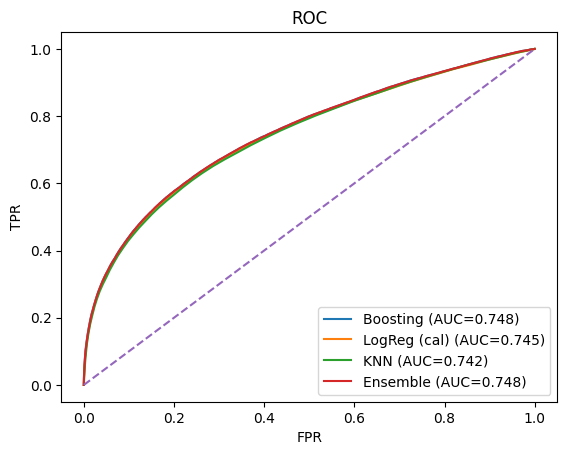

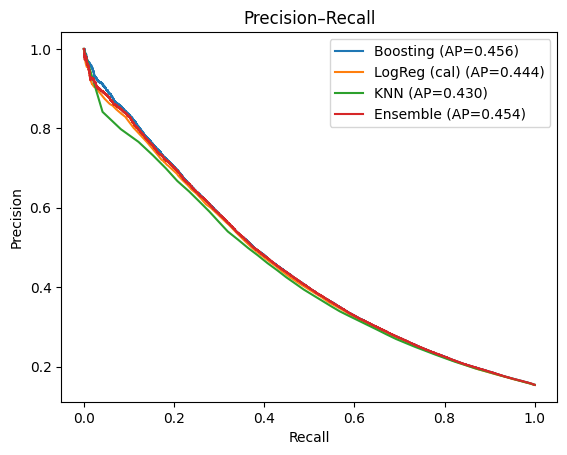

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

models = {
    "Boosting": np.asarray(p, float),
    "LogReg (cal)": np.asarray(p_log_cal, float),
    "KNN": np.asarray(p_knn, float),
    "Ensemble": 0.7*np.asarray(p, float)+0.3*np.asarray(p_log_cal, float),
}

plt.figure()
for name, s in models.items():
    fpr, tpr, _ = roc_curve(yte, s)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr,tpr):.3f})")
plt.plot([0,1],[0,1],linestyle="--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC")
plt.legend(); plt.show()

plt.figure()
for name, s in models.items():
    prec, rec, _ = precision_recall_curve(yte, s)
    ap = average_precision_score(yte, s)
    plt.plot(rec, prec, label=f"{name} (AP={ap:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall")
plt.legend(); plt.show()


**Curvas ROC:**

**O que mostra.** Trade-off entre TPR (sensibilidade) e FPR. Útil para comparar discriminação global dos modelos.

**Leitura rápida.** Boosting e o Ensemble lideram (AUC ≈ 0.748), seguidos de LogReg calibrada (AUC ≈ 0.745) e KNN (AUC ≈ 0.742).  
Todos superam a linha aleatória; diferenças são pequenas, mas consistentes.

**Conclusão.** Para priorização ampla, Boosting/Ensemble discriminam levemente melhor.


**Curvas Precision–Recall:**

**O que mostra.** Precisão vs. revocação no regime de classes raras — mais informativo que ROC aqui.

**Leitura rápida.** AP: Boosting ~0.456 > Ensemble ~0.454 > LogReg (cal) ~0.444 > KNN ~0.430.  
As curvas confirmam vantagem modesta do Boosting/Ensemble.

**Conclusão.** Em cenários com poucos recursos (precisar de alta precisão), Boosting/Ensemble entregam mais positivos reais por alerta.


## 2) Calibração (Reliability Curve) — Boosting vs LogReg(cal)

Mostra se as probabilidades “batem” com a realidade (útil para definição de limiar e comunicação de risco).


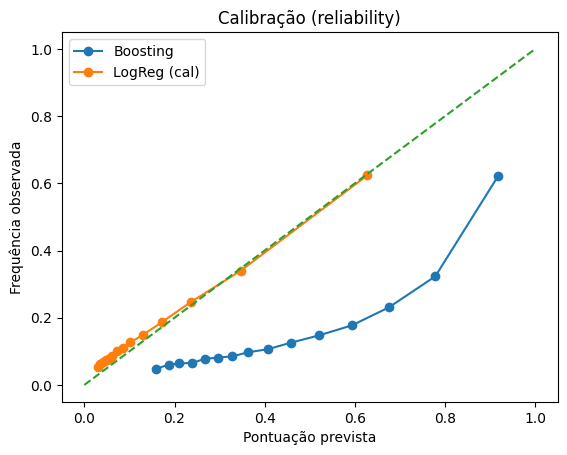

In [22]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

plt.figure()
for name, s in {"Boosting": p, "LogReg (cal)": p_log_cal}.items():
    prob_true, prob_pred = calibration_curve(yte, s, n_bins=15, strategy="quantile")
    plt.plot(prob_pred, prob_true, marker="o", label=name)
plt.plot([0,1],[0,1],"--")
plt.xlabel("Pontuação prevista"); plt.ylabel("Frequência observada")
plt.title("Calibração (reliability)")
plt.legend(); plt.show()


**O que mostra.** Quão bem as probabilidades previstas refletem frequências observadas.

**Leitura rápida.** A **LogReg calibrada** fica próxima da diagonal (bem calibrada).  
O Boosting tende a **superestimar** nas caudas (curva abaixo da diagonal).

**Conclusão.** Para decisões baseadas em probabilidade (ex.: “acionar se P≥x”), usar a **LogReg calibrada** ou calibrar o Boosting/Ensemble.


## 3) Cumulative Gain / Lift Curve

Mostra quanto dos positivos capturamos ao “atuar” nos top-x%


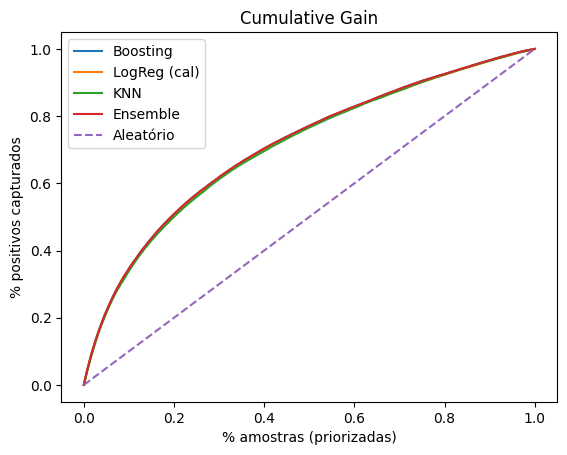

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def cumulative_gain(y, s):
    order = np.argsort(-s)
    y_sorted = y.to_numpy()[order] if hasattr(y, "to_numpy") else np.asarray(y)[order]
    cum_pos = np.cumsum(y_sorted)
    total_pos = cum_pos[-1]
    x = np.arange(1, len(y_sorted)+1)/len(y_sorted)
    y_ = (cum_pos/total_pos) if total_pos>0 else np.zeros_like(cum_pos)
    return x, y_

plt.figure()
for name, s in models.items():
    x, y_ = cumulative_gain(yte, s)
    plt.plot(x, y_, label=name)
plt.plot([0,1],[0,1], "--", label="Aleatório")
plt.xlabel("% amostras (priorizadas)"); plt.ylabel("% positivos capturados")
plt.title("Cumulative Gain")
plt.legend(); plt.show()


**O que mostra.** Fração de positivos capturados quando priorizamos uma fração do conjunto.

**Leitura rápida.** Ao priorizar ~20–30% das amostras, capturamos ~60–70% dos positivos (≈ 3× o aleatório).  
As curvas reforçam a vantagem prática de priorização.

**Conclusão.** A estratégia “inspecionar o Top-N semanal” é vantajosa operacionalmente.


## 4) P@K e Lift@K — barras lado a lado

Foco na priorização do topo (onde a operação atua).


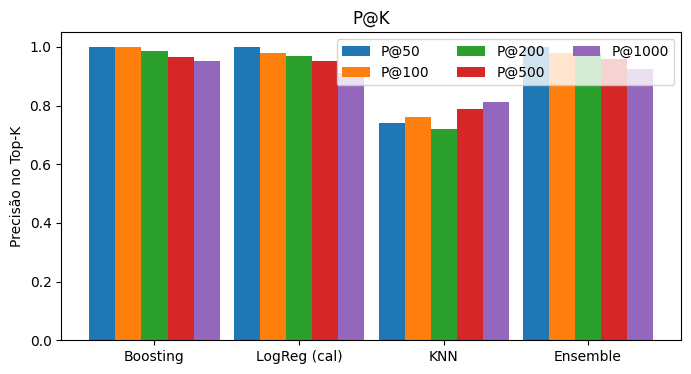

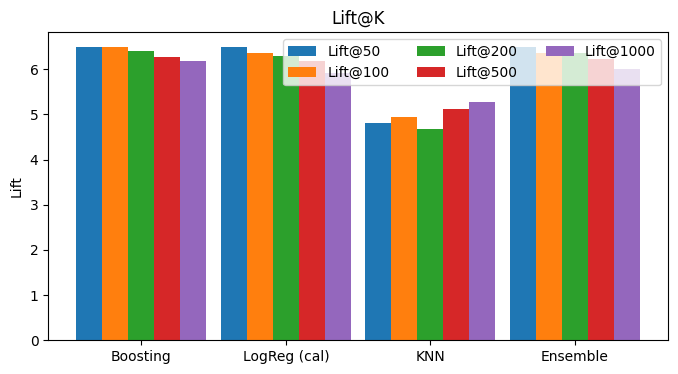

In [24]:
import numpy as np
import matplotlib.pyplot as plt

Ks = [50,100,200,500,1000]
def p_at_k(y, s, k):
    k = min(k, len(y)); idx = np.argsort(-s)[:k]
    yv = y.to_numpy() if hasattr(y,"to_numpy") else np.asarray(y)
    return float(yv[idx].mean())

def lift_at_k(y, s, k):
    base = float((y.mean() if hasattr(y, "mean") else np.mean(y)))
    p = p_at_k(y, s, k)
    return (p/base) if base>0 else np.nan

labels = list(models.keys())
P = np.array([[p_at_k(yte, models[m], k) for m in labels] for k in Ks])
L = np.array([[lift_at_k(yte, models[m], k) for m in labels] for k in Ks])

fig, ax = plt.subplots(figsize=(8,4))
width = 0.18
for i, k in enumerate(Ks):
    ax.bar(np.arange(len(labels))+i*width, P[i], width, label=f"P@{k}")
ax.set_xticks(np.arange(len(labels))+width*2); ax.set_xticklabels(labels, rotation=0)
ax.set_ylabel("Precisão no Top-K"); ax.set_title("P@K")
ax.legend(ncol=3); plt.show()

fig, ax = plt.subplots(figsize=(8,4))
for i, k in enumerate(Ks):
    ax.bar(np.arange(len(labels))+i*width, L[i], width, label=f"Lift@{k}")
ax.set_xticks(np.arange(len(labels))+width*2); ax.set_xticklabels(labels)
ax.set_ylabel("Lift"); ax.set_title("Lift@K")
ax.legend(ncol=3); plt.show()


**O que mostra.** Precisão/Lift nos Top-K casos — métrica aderente à operação.

**Leitura rápida.** Boosting/Ensemble mantêm **P@K ~0.95–1.00** e **Lift ~6×** nos Ks menores; KNN fica abaixo.  
A LogReg (cal) chega perto, com melhor calibração.

**Conclusão.** Se o time só consegue atuar em poucos alvos, **Boosting/Ensemble** maximizam acertos; **LogReg (cal)** é ótima quando o limiar em probabilidade importa.


## 5) Top-30 por semana — precisão ao longo do tempo

Linha do tempo de precisão semanal do Top-30 (ou quota Top-5/UF) para mostrar estabilidade.


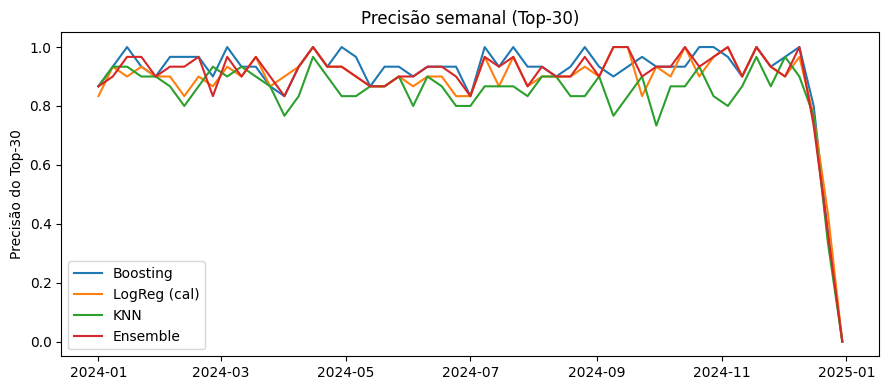

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def topN_week_curve(scores, N=30):
    sem_te = sem_ini[~is_train].reset_index(drop=True)
    df_scores = pd.DataFrame({"sem_ini": sem_te, "y_true": yte.to_numpy(), "score": scores})
    pts = []
    for sem, g in df_scores.groupby("sem_ini", sort=False):
        top = g.sort_values("score", ascending=False).head(N)
        if len(top)==0: continue
        pts.append((sem, float(top["y_true"].mean())))
    return pd.DataFrame(pts, columns=["sem_ini","prec_topN"])

curves = []
for name, s in models.items():
    curves.append(topN_week_curve(s, N=30).assign(model=name))

dfc = pd.concat(curves, ignore_index=True)
plt.figure(figsize=(9,4))
for name in dfc["model"].unique():
    g = dfc[dfc["model"]==name]
    plt.plot(g["sem_ini"], g["prec_topN"], label=name)
plt.ylabel("Precisão do Top-30"); plt.title("Precisão semanal (Top-30)")
plt.legend(); plt.tight_layout(); plt.show()


**O que mostra.** Estabilidade temporal da precisão do *Top-30 por semana* (proxy de operação semanal).

**Leitura rápida.** Precisão semanal costuma ficar entre **0.85–1.00**, com pequenas oscilações; última semana pode cair por borda de dados.

**Conclusão.** O método é **estável ao longo do ano**, adequado a rotinas semanais de priorização.


## Heatmap dos Top-N por semana (case de uma semana)

**Ideia.** Mostrar **onde priorizar** em uma semana específica do TESTE (2024), destacando os segmentos (UF × BR × km_bin5) com maior score.

**Leitura.** Cada célula é a **pontuação** do modelo naquele segmento. As colunas são “BR-KM”, linhas são UFs. Use `N` e `semana_escolhida` para mudar o case; por padrão pega **a última semana** disponível.


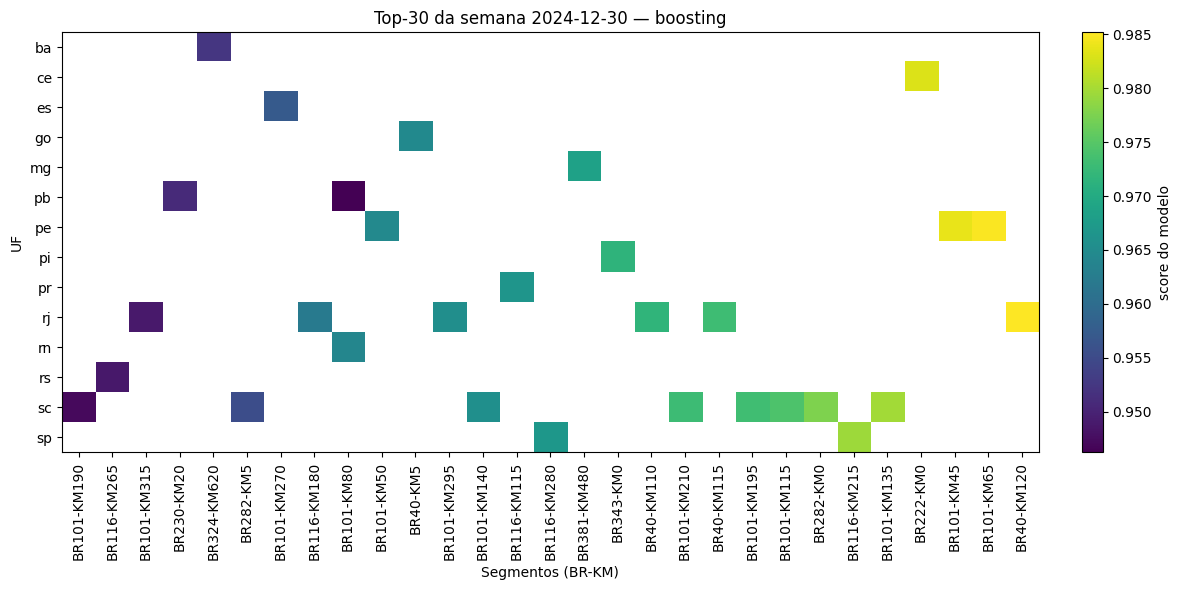

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ===== Configurações =====
modelo = "boosting"   # opções: "boosting", "logreg_cal", "knn", "ensemble"
N = 30                # Top-N por semana
semana_escolhida = None  # ex.: pd.Timestamp("2024-08-05"); None -> usa última semana do teste

# ===== Monta base de teste com chaves geográficas =====
base = agg.loc[mask, ["sem_ini","uf","br","km_bin5"]].reset_index(drop=True)
base_test = base[~is_train].reset_index(drop=True).copy()

# Escolhe as pontuações do modelo
scores_map = {
    "boosting": np.asarray(p, float),
    "logreg_cal": np.asarray(p_log_cal, float) if "p_log_cal" in globals() else None,
    "knn": np.asarray(p_knn, float) if "p_knn" in globals() else None,
    "ensemble": np.asarray(p_ens, float) if "p_ens" in globals() else None,
}
assert scores_map.get(modelo) is not None, f"Pontuações do modelo '{modelo}' não disponíveis."
base_test["score"] = scores_map[modelo]
base_test["y_true"] = (yte.to_numpy() if hasattr(yte, "to_numpy") else np.asarray(yte, int)).astype(int)

# Seleciona semana (default = última do teste)
sem_todas = base_test["sem_ini"].dropna().sort_values().unique()
sem_ref = (pd.to_datetime(semana_escolhida) if semana_escolhida is not None else sem_todas[-1])
dfw = base_test[base_test["sem_ini"] == sem_ref].copy()
assert len(dfw) > 0, "Semana escolhida não encontrada no teste."

# Top-N
top = dfw.sort_values("score", ascending=False).head(N).copy()
top["col"] = ("BR" + top["br"].round().astype("Int32").astype(str) +
              "-KM" + top["km_bin5"].fillna(-1).astype("Int32").astype(str))

# Pivot para heatmap
pivot = top.pivot_table(index="uf", columns="col", values="score", aggfunc="max")
pivot = pivot.reindex(sorted(pivot.index), axis=0)   # ordena UFs
pivot = pivot.reindex(sorted(pivot.columns, key=lambda c: float(pivot[c].max())), axis=1)  # ordena colunas por score

# Plot (matplotlib puro)
plt.figure(figsize=(12, 6))
data = pivot.to_numpy()
mask = np.isnan(data)
imshow_data = np.ma.array(data, mask=mask)
im = plt.imshow(imshow_data, aspect="auto")
plt.colorbar(im, fraction=0.046, pad=0.04, label="score do modelo")

plt.xticks(ticks=np.arange(pivot.shape[1]), labels=pivot.columns, rotation=90)
plt.yticks(ticks=np.arange(pivot.shape[0]), labels=pivot.index)
plt.title(f"Top-{N} da semana {pd.to_datetime(sem_ref).date()} — {modelo}")
plt.xlabel("Segmentos (BR-KM)")
plt.ylabel("UF")
plt.tight_layout()
plt.show()


## Matrizes de confusão — limiar ótimo de F1 e limiar “operacional”

**Ideia.** Tangibilizar *trade-offs*: (1) **limiar ótimo de F1**; (2) limiar para uma **cobertura fixa** (ex.: 1% e 5% dos casos priorizados).

**Leitura.** A tabela mostra TP/FP/FN/TN e métricas derivadas (Precisão, Recall, F1, Cobertura).  
Edite `modelos_alvo`/`coberturas` se quiser outras variantes.


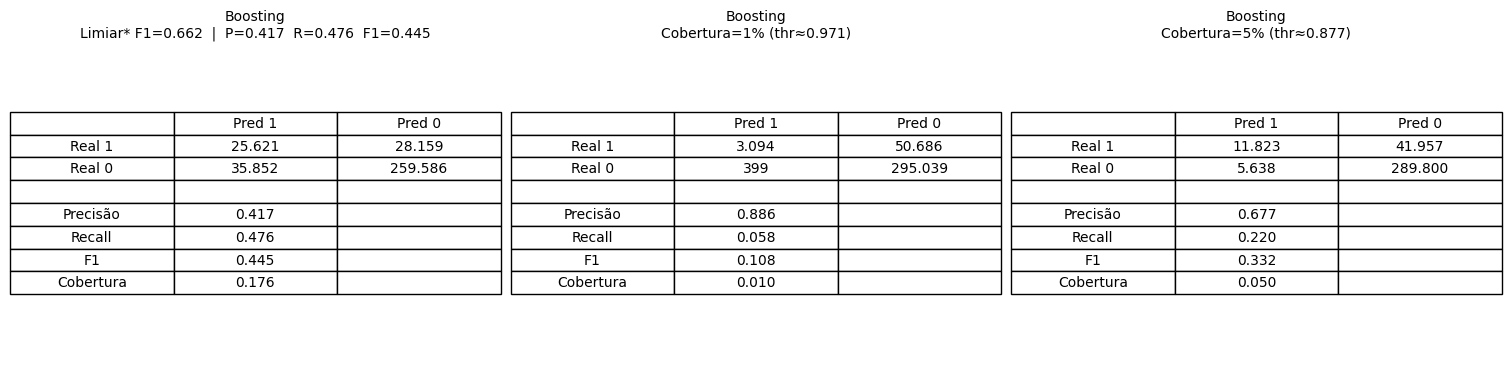

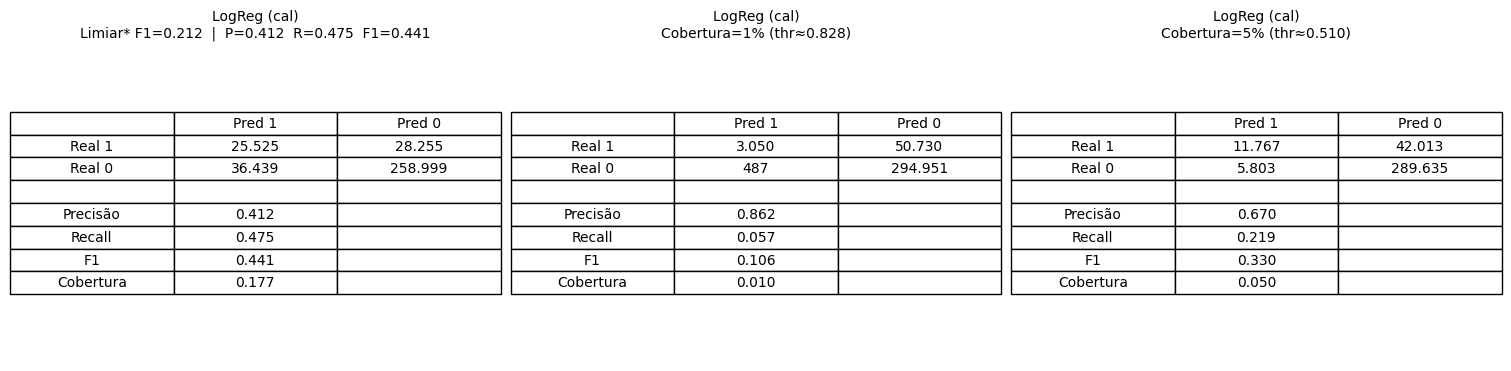

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# ===== Entrada (teste) =====
y_true = (yte.to_numpy() if hasattr(yte, "to_numpy") else np.asarray(yte, int)).astype(int)

modelos_alvo = {
    "Boosting": np.asarray(p, float),
    "LogReg (cal)": np.asarray(p_log_cal, float) if "p_log_cal" in globals() else None,
    # "KNN": np.asarray(p_knn, float) if "p_knn" in globals() else None,
    # "Ensemble": np.asarray(p_ens, float) if "p_ens" in globals() else None,
}
modelos_alvo = {k: v for k, v in modelos_alvo.items() if v is not None}

coberturas = [0.01, 0.05]  # 1% e 5%

# ===== helpers =====
def thr_star_f1(y, s):
    prec, rec, thr = precision_recall_curve(y, s)
    f1 = (2*prec*rec) / (prec + rec + 1e-12)
    if len(thr) == 0:
        return 0.5, 0.0, 0.0, 0.0
    i = int(np.nanargmax(f1))
    return float(thr[i]), float(prec[i]), float(rec[i]), float(f1[i])

def thr_by_coverage(s, cov):
    """
    Limiar que produz ~cov de positivos.
    Usa o quantil 1-cov (maior score = positivo). Trata casos extremos e empates.
    """
    cov = float(np.clip(cov, 0.0, 1.0))
    if cov <= 0:
        return float(np.inf)
    if cov >= 1:
        return float(-np.inf)
    q = float(np.quantile(s, 1.0 - cov))
    return q

def confusion(y, s, thr):
    pred = (s >= thr).astype(int)
    tp = int(((pred == 1) & (y == 1)).sum())
    fp = int(((pred == 1) & (y == 0)).sum())
    fn = int(((pred == 0) & (y == 1)).sum())
    tn = int(((pred == 0) & (y == 0)).sum())
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    rec  = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1   = (2 * prec * rec) / (prec + rec + 1e-12) if (prec + rec) > 0 else 0.0
    cov  = float(pred.mean())
    return {"TP": tp, "FP": fp, "FN": fn, "TN": tn,
            "Precisão": prec, "Recall": rec, "F1": f1, "Cobertura": cov}

def _fmt_int(x):  # milhares bonitos
    return f"{x:,}".replace(",", ".")

def plot_confusion_table(ax, stats, title):
    ax.axis("off")
    tbl = [
        ["",       "Pred 1",            "Pred 0"],
        ["Real 1", _fmt_int(stats["TP"]), _fmt_int(stats["FN"])],
        ["Real 0", _fmt_int(stats["FP"]), _fmt_int(stats["TN"])],
        ["", "", ""],
        ["Precisão", f"{stats['Precisão']:.3f}", ""],
        ["Recall",   f"{stats['Recall']:.3f}",   ""],
        ["F1",       f"{stats['F1']:.3f}",       ""],
        ["Cobertura",f"{stats['Cobertura']:.3f}",""],
    ]
    table = ax.table(cellText=tbl, loc="center", cellLoc="center")
    table.scale(1.0, 1.2)
    ax.set_title(title, fontsize=10, pad=6)

# ===== Plota para cada modelo =====
for nome, scores in modelos_alvo.items():
    thr_f1, p_f1, r_f1, f1_f1 = thr_star_f1(y_true, scores)
    stats_f1 = confusion(y_true, scores, thr_f1)

    n_pan = 1 + len(coberturas)
    fig, axs = plt.subplots(
        1, n_pan, figsize=(5.0 * n_pan, 3.6), constrained_layout=True
    )
    axs = np.atleast_1d(axs)  # garante iterável mesmo se n_pan==1

    plot_confusion_table(
        axs[0],
        stats_f1,
        f"{nome}\nLimiar* F1={thr_f1:.3f}  |  P={p_f1:.3f}  R={r_f1:.3f}  F1={f1_f1:.3f}"
    )

    for i, cov in enumerate(coberturas, start=1):
        thr_cov = thr_by_coverage(scores, cov)
        stats_cov = confusion(y_true, scores, thr_cov)
        plot_confusion_table(
            axs[i],
            stats_cov,
            f"{nome}\nCobertura={cov:.0%} (thr≈{thr_cov:.3f})"
        )

    plt.show()


# Entrega 2 - SVMs

## SVMs Classificação `y_next`

**Por que SVM aqui?**  
SVMs maximizam a margem entre classes e costumam ir bem com features bem escaladas (usamos `StandardScaler`).  
Vamos testar:
- **LinearSVC** (rápido; usa `decision_function`)
- **SVC(kernel='linear')** (mais estável; usa `decision_function`)
- **SVC(kernel='poly')** (grau 2–4; controla complexidade com `C`, `coef0`)
- **SVC(kernel='rbf')** (não-linear clássico; ajusta `C` e `gamma`)

**Observações práticas**
- SVMs podem ficar **pesados** em datasets grandes. Limitamos treino com `MAX_TRAIN` (estratificado).
- Usamos `class_weight='balanced'` por causa do desbalanceamento.
- Para métricas baseadas em ranking (PR-AUC, P@K, Lift@K), podemos usar o **`decision_function`** sem calibrar probas. (Se quiser probabilidades calibradas, ative a flag de calibração no código.)


In [28]:
# ========================= BOOTSTRAP =========================
# Reconstrói X, y, is_train, sem_ini, ufs (e agg/mask) a partir do que houver disponível.
import numpy as np
import pandas as pd
from datetime import date, timedelta

def have(*names):
    g = globals()
    return all(n in g for n in names)

if have("X","y","is_train","sem_ini","ufs"):
    print("[OK] Usando X/y/is_train já presentes no ambiente.")
else:
    # ------------- 0) garantir df -------------
    if not have("df"):
        try:
            # tenta carregar do arquivo padrão salvo anteriormente
            df = pd.read_csv("prf_clean.csv.gz", low_memory=False, parse_dates=["data"])
            print("[Rebuild] Carregado df de prf_clean.csv.gz:", df.shape)
        except Exception as e:
            raise AssertionError(
                "Não encontrei df no ambiente nem consegui ler prf_clean.csv.gz.\n"
                "Abra/calcule o dataset (df) OU gere o prf_clean.csv.gz antes.\n"
                f"Detalhe: {type(e).__name__}: {e}"
            )

    # ------------- 1) preparação mínima do df -------------
    df = df.copy()
    df["data"] = pd.to_datetime(df["data"], errors="coerce")
    df = df[df["data"].notna()]
    df["uf"] = df["uf"].astype(object)
    df["br"] = pd.to_numeric(df["br"], errors="coerce")
    df["km"] = pd.to_numeric(df["km"], errors="coerce")
    df["km_bin5"] = (np.floor(df["km"] / 5) * 5).astype("Int32")

    if "eh_noite" not in df.columns:
        if "hora" in df.columns and not pd.isna(df["hora"]).all():
            df["eh_noite"] = ((df["hora"] >= 19) | (df["hora"] <= 5)).astype("Int8")
        elif "segundos_desde_00" in df.columns and not pd.isna(df["segundos_desde_00"]).all():
            s = df["segundos_desde_00"]
            df["eh_noite"] = ((s >= 19*3600) | (s <= 5*3600)).astype("Int8")
        else:
            df["eh_noite"] = 0

    # ------------- 2) helpers -------------
    def dense_weekly_agg_5km(df: pd.DataFrame) -> pd.DataFrame:
        g = df.copy()
        g["data"] = pd.to_datetime(g["data"], errors="coerce").dt.normalize()
        g = g[g["data"].notna()]
        g["sem_ini"] = g["data"] - pd.to_timedelta(g["data"].dt.weekday, unit="D")

        keys = ["uf","br","km_bin5","sem_ini"]
        agg = (
            g.groupby(keys, observed=True, sort=False)
             .agg(acidentes=("data","size"), p_noite=("eh_noite","mean"))
             .reset_index()
        )

        parts = []
        for (uf, br, km5), seg in agg.groupby(["uf","br","km_bin5"], observed=True, sort=False):
            start, end = seg["sem_ini"].min(), seg["sem_ini"].max()
            full = pd.date_range(start, end, freq="W-MON")
            seg = seg.set_index("sem_ini").reindex(full)
            seg.index.name = "sem_ini"
            seg["acidentes"] = seg["acidentes"].fillna(0).astype("Int16")
            seg["p_noite"]   = seg["p_noite"].fillna(0.0).astype("float32")
            seg["uf"], seg["br"], seg["km_bin5"] = uf, br, km5
            parts.append(seg.reset_index())
        dense = pd.concat(parts, ignore_index=True)

        iso = dense["sem_ini"].dt.isocalendar()
        dense["ano_iso"] = iso["year"].astype("Int16")
        dense["semana"]  = iso["week"].astype("Int8")
        return dense

    def add_lags_rollings_groupwise(df_in: pd.DataFrame,
                                    col="acidentes",
                                    group_cols=["uf","br","km_bin5"],
                                    order_col="sem_ini") -> pd.DataFrame:
        out = df_in.sort_values(group_cols + [order_col]).copy()
        for L in [1,4,12]:
            out[f"{col}_lag{L}"] = np.nan
        for W in [4,12,24]:
            out[f"{col}_rollmean{W}"] = np.nan
        if "p_noite" in out.columns:
            for W in [12,24]:
                out[f"p_noite_rollmean{W}"] = np.nan

        for _, g in out.groupby(group_cols, sort=False, observed=True):
            idx  = g.index
            vals = g[col].astype("float32")
            out.loc[idx, f"{col}_lag1"]  = vals.shift(1).to_numpy()
            out.loc[idx, f"{col}_lag4"]  = vals.shift(4).to_numpy()
            out.loc[idx, f"{col}_lag12"] = vals.shift(12).to_numpy()
            s = vals.shift(1)
            for W in [4,12,24]:
                out.loc[idx, f"{col}_rollmean{W}"] = s.rolling(W, min_periods=max(2, W//2)).mean().to_numpy()
            if "p_noite" in g.columns:
                pn = g["p_noite"].astype("float32").shift(1)
                for W in [12,24]:
                    out.loc[idx, f"p_noite_rollmean{W}"] = pn.rolling(W, min_periods=max(2, W//2)).mean().to_numpy()
        return out

    def add_recency_features(df_in: pd.DataFrame,
                             group_cols=["uf","br","km_bin5"],
                             order_col="sem_ini") -> pd.DataFrame:
        out = df_in.sort_values(group_cols + [order_col]).copy()
        out["since_last_acc"] = np.nan
        out["cnt_last4"] = np.nan
        out["cnt_last12"] = np.nan
        for _, g in out.groupby(group_cols, sort=False, observed=True):
            idx = g.index
            y = (g["acidentes"] > 0).astype("int8").reset_index(drop=True)
            last = -1; sl = []
            for i, yi in enumerate(y.to_numpy()):
                sl.append((i - last) if last >= 0 else np.nan)
                if yi == 1: last = i
            out.loc[idx, "since_last_acc"] = np.array(sl, dtype="float32")
            roll = y.shift(1).rolling
            out.loc[idx, "cnt_last4"]  = roll(4,  min_periods=1).sum().to_numpy()
            out.loc[idx, "cnt_last12"] = roll(12, min_periods=1).sum().to_numpy()
        return out

    def add_seasonality(df_in: pd.DataFrame) -> pd.DataFrame:
        out = df_in.copy()
        out["mes"] = out["sem_ini"].dt.month.astype("Int8")
        out["woy"] = out["sem_ini"].dt.isocalendar().week.astype("Int16")
        out["mes_sin"] = np.sin(2*np.pi*out["mes"]/12).astype("float32")
        out["mes_cos"] = np.cos(2*np.pi*out["mes"]/12).astype("float32")
        out["woy_sin"] = np.sin(2*np.pi*out["woy"]/52).astype("float32")
        out["woy_cos"] = np.cos(2*np.pi*out["woy"]/52).astype("float32")
        return out

    def add_neighbor_features(df_in: pd.DataFrame, shift_km=5) -> pd.DataFrame:
        base_cols = ["uf","br","km_bin5","sem_ini","acidentes"]
        if "acidentes_rollmean12" in df_in.columns:
            base_cols += ["acidentes_rollmean12"]
        base = df_in[base_cols].copy()

        nb_plus = base.copy()
        nb_plus["km_bin5"] = nb_plus["km_bin5"] - shift_km
        rename_plus = {"acidentes":"nb_plus_acid"}
        if "acidentes_rollmean12" in base_cols:
            rename_plus["acidentes_rollmean12"] = "nb_plus_rm12"
        nb_plus = nb_plus.rename(columns=rename_plus)

        nb_minus = base.copy()
        nb_minus["km_bin5"] = nb_minus["km_bin5"] + shift_km
        rename_minus = {"acidentes":"nb_minus_acid"}
        if "acidentes_rollmean12" in base_cols:
            rename_minus["acidentes_rollmean12"] = "nb_minus_rm12"
        nb_minus = nb_minus.rename(columns=rename_minus)

        out = df_in.merge(nb_plus, on=["uf","br","km_bin5","sem_ini"], how="left")
        out = out.merge(nb_minus, on=["uf","br","km_bin5","sem_ini"], how="left")

        for c in ["nb_plus_acid","nb_minus_acid","nb_plus_rm12","nb_minus_rm12"]:
            if c in out.columns:
                out[c] = out[c].fillna(0).astype("float32")
        if "nb_plus_acid" in out.columns and "nb_minus_acid" in out.columns:
            out["nb_acid_sum"] = (out["nb_plus_acid"] + out["nb_minus_acid"]).astype("float32")
        if "nb_plus_rm12" in out.columns and "nb_minus_rm12" in out.columns:
            out["nb_rm12_mean"] = ((out["nb_plus_rm12"] + out["nb_minus_rm12"]) / 2).astype("float32")
        return out

    def easter_date(year: int) -> date:
        a = year % 19; b = year // 100; c = year % 100; d = b // 4; e = b % 4
        f = (b + 8) // 25; g = (b - f + 1) // 3; h = (19*a + b - d - g + 15) % 30
        i = c // 4; k = c % 4; l = (32 + 2*e + 2*i - h - k) % 7; m = (a + 11*h + 22*l) // 451
        month = (h + l - 7*m + 114) // 31; day = ((h + l - 7*m + 114) % 31) + 1
        return date(year, month, day)

    def brazil_holidays_year(year: int) -> set:
        pascoa = easter_date(year)
        carnaval_tue = pascoa - timedelta(days=47)
        carnaval_mon = carnaval_tue - timedelta(days=1)
        sexta_santa  = pascoa - timedelta(days=2)
        corpus_christi = pascoa + timedelta(days=60)
        fixed = {
            date(year, 1, 1), date(year, 4, 21), date(year, 5, 1), date(year, 9, 7),
            date(year,10,12), date(year,11, 2), date(year,11,15), date(year,12,25),
        }
        moveis = {pascoa, sexta_santa, corpus_christi, carnaval_mon, carnaval_tue}
        return fixed | moveis

    def add_weekly_holiday_flags(df_in: pd.DataFrame) -> pd.DataFrame:
        out = df_in.copy()
        anos = out["sem_ini"].dt.year.unique().tolist()
        hol = set()
        for y in anos:
            hol |= brazil_holidays_year(int(y))
        week_end = out["sem_ini"] + pd.to_timedelta(6, unit="D")
        has_holiday = out.apply(
            lambda r: any((r["sem_ini"].date() <= d <= week_end.loc[r.name].date()) for d in hol),
            axis=1
        )
        out["feriado_semana"] = has_holiday.astype("Int8")
        next_week = out["sem_ini"] + pd.to_timedelta(7, unit="D")
        next_week_end = next_week + pd.to_timedelta(6, unit="D")
        has_holiday_next = [
            1 if any((s.date() <= d <= e.date()) for d in hol) else 0
            for s, e in zip(next_week, next_week_end)
        ]
        out["feriado_prox_sem"] = np.array(has_holiday_next, dtype=np.int8)
        return out

    # ------------- 3) construir agg -> y_next -> features -------------
    agg = dense_weekly_agg_5km(df)
    agg = agg.sort_values(["uf","br","km_bin5","sem_ini"])
    agg["y_next"] = (
        agg.groupby(["uf","br","km_bin5"], observed=True, sort=False)["acidentes"]
           .shift(-1).fillna(0).ge(1).astype("Int8")
    )
    agg = add_lags_rollings_groupwise(agg, col="acidentes",
                                      group_cols=["uf","br","km_bin5"], order_col="sem_ini")
    agg = add_recency_features(agg, group_cols=["uf","br","km_bin5"], order_col="sem_ini")
    # janelas longas/EWMA
    for _, gseg in agg.groupby(["uf","br","km_bin5"], sort=False, observed=True):
        idx = gseg.index
        s = gseg["acidentes"].astype("float32").shift(1)
        agg.loc[idx, "acidentes_rollmean52"] = s.rolling(52, min_periods=13).mean().to_numpy()
        agg.loc[idx, "acidentes_ewm_alpha01"] = s.ewm(alpha=0.10, adjust=False, min_periods=3).mean().to_numpy()
    # sazonalidade, vizinhança, feriados
    agg = add_seasonality(agg)
    agg = add_neighbor_features(agg, shift_km=5)
    agg = add_neighbor_features(agg, shift_km=10)
    for plus, minus, outc in [
        ("nb_plus_acid","nb_minus_acid","nb_acid_sum10"),
        ("nb_plus_rm12","nb_minus_rm12","nb_rm12_mean10"),
    ]:
        if plus in agg.columns and minus in agg.columns:
            if "sum" in outc:
                agg[outc] = (agg[plus].fillna(0)+agg[minus].fillna(0)).astype("float32")
            else:
                agg[outc] = ((agg[plus].fillna(0)+agg[minus].fillna(0))/2).astype("float32")
    agg = add_weekly_holiday_flags(agg)

    # ------------- 4) montar X/y/is_train -------------
    feat_master = [
        "acidentes",
        "acidentes_lag1","acidentes_lag4","acidentes_lag12",
        "acidentes_rollmean4","acidentes_rollmean12","acidentes_rollmean24","acidentes_rollmean52",
        "acidentes_ewm_alpha01",
        "p_noite","p_noite_rollmean12","p_noite_rollmean24",
        "since_last_acc","cnt_last4","cnt_last12",
        "mes_sin","mes_cos","woy_sin","woy_cos",
        "nb_acid_sum","nb_rm12_mean","nb_acid_sum10","nb_rm12_mean10",
        "feriado_semana","feriado_prox_sem"
    ]
    feat_cols = [c for c in feat_master if c in agg.columns]
    mask = agg[feat_cols].notna().all(axis=1)

    X = agg.loc[mask, feat_cols].reset_index(drop=True)
    y = agg.loc[mask, "y_next"].astype(int).reset_index(drop=True)
    years = agg.loc[mask, "ano_iso"].reset_index(drop=True)
    sem_ini = agg.loc[mask, "sem_ini"].reset_index(drop=True)
    ufs = agg.loc[mask, "uf"].reset_index(drop=True)
    is_train = (years < 2024)

    print(f"[Rebuild] X={X.shape}, y={y.shape}, train={int(is_train.sum())}, test={int((~is_train).sum())}")


[OK] Usando X/y/is_train já presentes no ambiente.


In [29]:
# ===== SVMs (classificação) — setup comum =====
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve
from scipy.stats import loguniform

# Reuso dos splits já existentes (garantidos pelo bootstrap)
Xtr_svm, Xte_svm = X[is_train].copy(), X[~is_train].copy()
ytr_svm, yte_svm = y[is_train].copy(), y[~is_train].copy()

print(f"[SVM] Treino: {Xtr_svm.shape} | Teste: {Xte_svm.shape} | Positivos teste: {int(yte_svm.sum())}/{len(yte_svm)} ({yte_svm.mean():.3f})")

# Para acelerar em dataset grande:
MAX_TRAIN = 120_000
if len(Xtr_svm) > MAX_TRAIN:
    pos_idx = np.where(ytr_svm.values==1)[0]
    neg_idx = np.where(ytr_svm.values==0)[0]
    rng = np.random.default_rng(42)
    take_pos = min(len(pos_idx), MAX_TRAIN//2)
    take_neg = min(len(neg_idx), MAX_TRAIN - take_pos)
    sel = np.concatenate([
        rng.choice(pos_idx, take_pos, replace=False),
        rng.choice(neg_idx, take_neg, replace=False)
    ])
    rng.shuffle(sel)
    Xtr_svm = Xtr_svm.iloc[sel].reset_index(drop=True)
    ytr_svm = ytr_svm.iloc[sel].reset_index(drop=True)
    print(f"[SVM] Subamostrado treino: {Xtr_svm.shape} "
          f"(pos={int(ytr_svm.sum())}, neg={len(ytr_svm)-int(ytr_svm.sum())})")

def eval_rank_metrics(y_true, scores, tag="[model]"):
    roc = roc_auc_score(y_true, scores)
    pr  = average_precision_score(y_true, scores)
    prec, rec, thr = precision_recall_curve(y_true, scores)
    f1 = (2*prec*rec)/(prec+rec+1e-12)
    i  = int(np.nanargmax(f1)) if len(f1) else 0
    thr_star = float(thr[i]) if len(thr) else 0.0
    print(f"{tag} ROC-AUC={roc:.3f} | PR-AUC={pr:.3f} | F1*={f1[i]:.3f} "
          f"@thr≈{thr_star:.3f} (P={prec[i]:.3f}, R={rec[i]:.3f})")

    def pk_lift(y, s, k):
        k = min(k, len(y))
        order = np.argsort(-s)[:k]
        p_at_k = y.iloc[order].mean()
        base   = y.mean()
        lift   = (p_at_k/base) if base>0 else np.nan
        r_at_k = y.iloc[order].sum() / max(1, y.sum())
        return p_at_k, r_at_k, lift
    for k in [50,100,200,500,1000]:
        pk, rk, lt = pk_lift(y_true, scores, k)
        print(f"{tag} K={k:4d} | P@K={pk:.3f} | R@K={rk:.3f} | Lift@K={lt:.2f}")
    return roc, pr

# ===== 1) LinearSVC =====
lin_svc = make_pipeline(
    StandardScaler(with_mean=True),
    LinearSVC(C=1.0, class_weight="balanced", max_iter=5000, dual="auto")
)
lin_svc.fit(Xtr_svm, ytr_svm)
p_linearSVC = lin_svc.decision_function(Xte_svm)
eval_rank_metrics(yte_svm, p_linearSVC, tag="[LinearSVC]")

# ===== 2) SVC(kernel='linear') =====
svc_linear = make_pipeline(
    StandardScaler(with_mean=True),
    SVC(kernel="linear", C=1.0, class_weight="balanced", probability=False)
)
svc_linear.fit(Xtr_svm, ytr_svm)
p_svm_linear = svc_linear.decision_function(Xte_svm)
eval_rank_metrics(yte_svm, p_svm_linear, tag="[SVC-linear]")

# ===== 3) SVC(kernel='poly') =====
svc_poly = make_pipeline(
    StandardScaler(with_mean=True),
    SVC(kernel="poly", degree=3, coef0=1.0, C=1.0, class_weight="balanced", probability=False)
)
svc_poly.fit(Xtr_svm, ytr_svm)
p_svm_poly_d3 = svc_poly.decision_function(Xte_svm)
eval_rank_metrics(yte_svm, p_svm_poly_d3, tag="[SVC-poly(d=3)]")

# ===== 4) SVC(kernel='rbf') =====
svc_rbf = make_pipeline(
    StandardScaler(with_mean=True),
    SVC(kernel="rbf", C=3.0, gamma="scale", class_weight="balanced", probability=False)
)
svc_rbf.fit(Xtr_svm, ytr_svm)
p_svm_rbf = svc_rbf.decision_function(Xte_svm)
eval_rank_metrics(yte_svm, p_svm_rbf, tag="[SVC-RBF]")

print("[SVM] scores disponíveis:", 
      "p_linearSVC,", "p_svm_linear,", "p_svm_poly_d3,", "p_svm_rbf")


[SVM] Treino: (1149557, 23) | Teste: (349218, 23) | Positivos teste: 53780/349218 (0.154)
[SVM] Subamostrado treino: (120000, 23) (pos=60000, neg=60000)
[LinearSVC] ROC-AUC=0.743 | PR-AUC=0.445 | F1*=0.440 @thr≈0.149 (P=0.412, R=0.471)
[LinearSVC] K=  50 | P@K=0.980 | R@K=0.001 | Lift@K=6.36
[LinearSVC] K= 100 | P@K=0.980 | R@K=0.002 | Lift@K=6.36
[LinearSVC] K= 200 | P@K=0.960 | R@K=0.004 | Lift@K=6.23
[LinearSVC] K= 500 | P@K=0.948 | R@K=0.009 | Lift@K=6.16
[LinearSVC] K=1000 | P@K=0.900 | R@K=0.017 | Lift@K=5.84
[SVC-linear] ROC-AUC=0.744 | PR-AUC=0.449 | F1*=0.441 @thr≈0.197 (P=0.407, R=0.481)
[SVC-linear] K=  50 | P@K=1.000 | R@K=0.001 | Lift@K=6.49
[SVC-linear] K= 100 | P@K=0.970 | R@K=0.002 | Lift@K=6.30
[SVC-linear] K= 200 | P@K=0.960 | R@K=0.004 | Lift@K=6.23
[SVC-linear] K= 500 | P@K=0.958 | R@K=0.009 | Lift@K=6.22
[SVC-linear] K=1000 | P@K=0.912 | R@K=0.017 | Lift@K=5.92
[SVC-poly(d=3)] ROC-AUC=0.739 | PR-AUC=0.415 | F1*=0.442 @thr≈0.639 (P=0.409, R=0.481)
[SVC-poly(d=3)] K=

[WARN] Não consegui calibrar SVC-linear agora: Boolean index has wrong length: 14 instead of 1634349


,modelo,roc_auc,pr_auc,thr_f1*,f1*,P(thr*),R(thr*),P@50,R@50,Lift@50,...,Lift@100,P@200,R@200,Lift@200,P@500,R@500,Lift@500,P@1000,R@1000,Lift@1000
0,Boosting (HGB),0.748,0.456,0.662,0.445,0.417,0.476,1.00,0.001,6.49,...,6.49,0.985,0.004,6.40,0.966,0.009,6.27,0.953,0.018,6.19
1,SVM SVC-linear,0.744,0.449,0.197,0.441,0.407,0.481,1.00,0.001,6.49,...,6.30,0.960,0.004,6.23,0.958,0.009,6.22,0.912,0.017,5.92
2,SVM LinearSVC,0.743,0.445,0.149,0.440,0.412,0.471,0.98,0.001,6.36,...,6.36,0.960,0.004,6.23,0.948,0.009,6.16,0.900,0.017,5.84
3,LogReg (cal),0.745,0.444,0.212,0.441,0.412,0.475,1.00,0.001,6.49,...,6.36,0.970,0.004,6.30,0.952,0.009,6.18,0.910,0.017,5.91
4,KNN,0.742,0.430,0.660,0.437,0.409,0.469,0.74,0.001,4.81,...,4.94,0.720,0.003,4.68,0.790,0.007,5.13,0.813,0.015,5.28
5,SVM Poly(d=3),0.739,0.415,0.639,0.442,0.409,0.481,1.00,0.001,6.49,...,6.36,0.970,0.004,6.30,0.944,0.009,6.13,0.926,0.017,6.01
6,SVM RBF,0.733,0.343,0.637,0.440,0.397,0.495,0.50,0.000,3.25,...,3.18,0.450,0.002,2.92,0.398,0.004,2.58,0.409,0.008,2.66


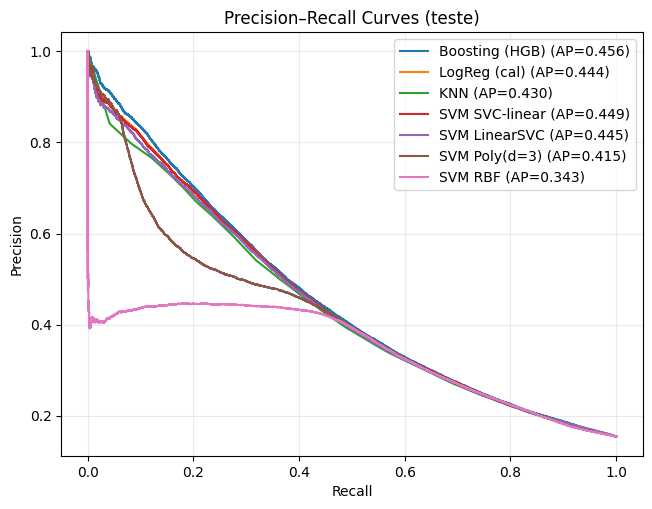

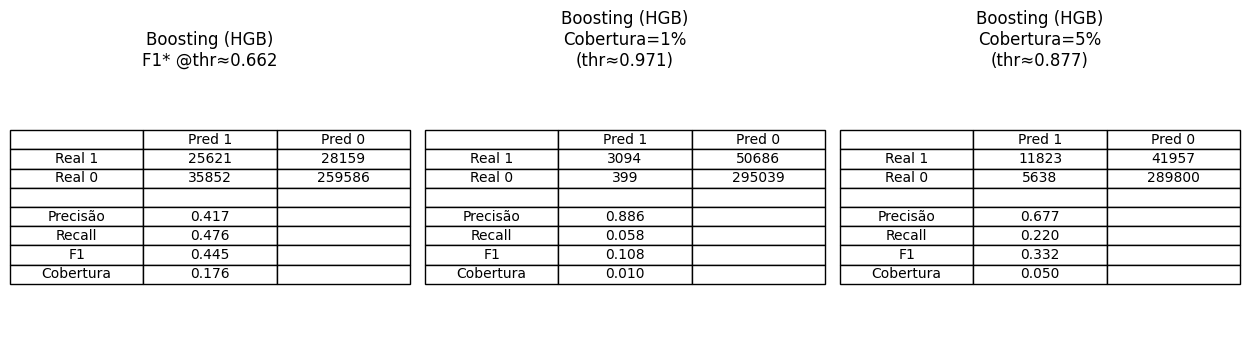

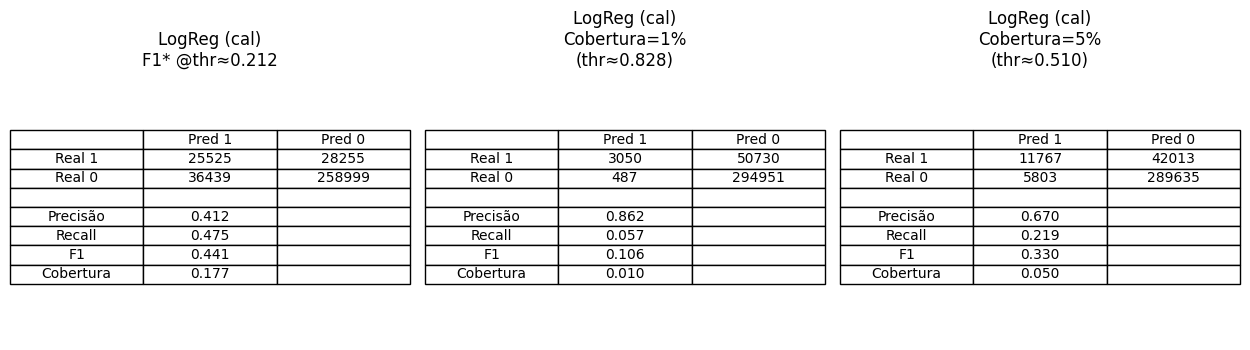

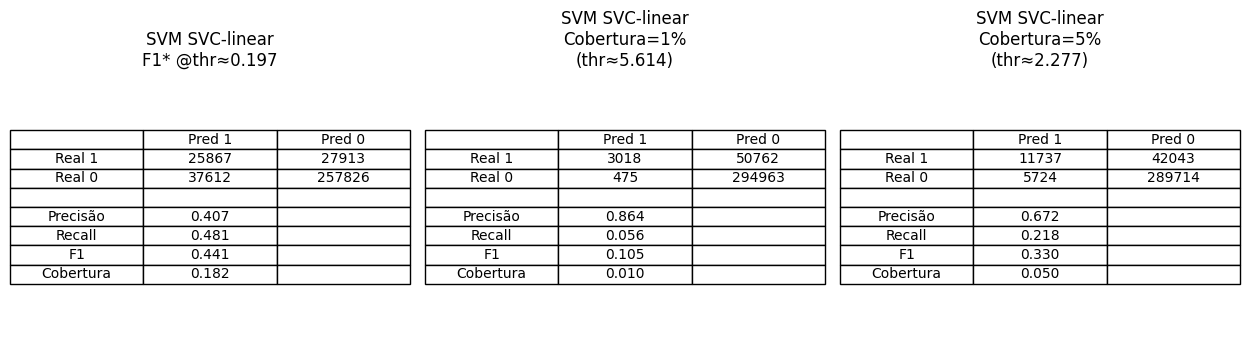

In [31]:
# =================== COMPARAÇÃO (inclui SVMs) ===================
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, auc
from sklearn.isotonic import IsotonicRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# --- helpers (reusáveis) ---
def best_f1_threshold(y_true, y_score):
    prec, rec, thr = precision_recall_curve(y_true, y_score)
    f1 = (2*prec*rec)/(prec+rec+1e-12)
    if len(thr)==0: return 0.5, 0, 0, 0
    i = int(np.nanargmax(f1))
    return float(thr[i]), float(f1[i]), float(prec[i]), float(rec[i])

def pk_lift(y_true, y_score, k):
    k = min(k, len(y_true))
    order = np.argsort(-y_score)[:k]
    y = y_true.iloc[order] if isinstance(y_true, pd.Series) else y_true[order]
    p_at_k = float(y.mean())
    base   = float((y_true.mean() if isinstance(y_true, pd.Series) else np.mean(y_true)))
    lift   = (p_at_k/base) if base>0 else np.nan
    r_at_k = float(y.sum() / max(1, (y_true.sum() if isinstance(y_true, pd.Series) else np.sum(y_true))))
    return p_at_k, r_at_k, lift

def confusion_stats(y, s, thr):
    y = np.asarray(y, int); s = np.asarray(s, float)
    pred = (s >= thr).astype(int)
    tp = int(((pred==1)&(y==1)).sum()); fp = int(((pred==1)&(y==0)).sum())
    fn = int(((pred==0)&(y==1)).sum()); tn = int(((pred==0)&(y==0)).sum())
    prec = tp/(tp+fp) if (tp+fp)>0 else 0.0
    rec  = tp/(tp+fn) if (tp+fn)>0 else 0.0
    f1   = (2*prec*rec)/(prec+rec+1e-12) if (prec+rec)>0 else 0.0
    cov  = pred.mean()
    return {"TP":tp,"FP":fp,"FN":fn,"TN":tn,"Precisao":prec,"Recall":rec,"F1":f1,"Cobertura":cov}

def threshold_by_coverage(scores, coverage):
    # limiar que seleciona ~coverage como positivos (maiores scores = positivos)
    return float(np.quantile(np.asarray(scores, float), 1.0 - coverage))

def plot_conf_table(ax, stats, title):
    ax.axis("off")
    tbl = [
        ["", "Pred 1", "Pred 0"],
        ["Real 1", stats["TP"], stats["FN"]],
        ["Real 0", stats["FP"], stats["TN"]],
        ["", "", ""],
        ["Precisão", f"{stats['Precisao']:.3f}", ""],
        ["Recall",    f"{stats['Recall']:.3f}",    ""],
        ["F1",        f"{stats['F1']:.3f}",        ""],
        ["Cobertura", f"{stats['Cobertura']:.3f}", ""],
    ]
    t = ax.table(cellText=tbl, loc="center", cellLoc="center")
    t.scale(1, 1.2)
    ax.set_title(title)

# ===== 1) Montar dicionário de modelos disponíveis (inclui SVMs) =====
y_true = yte if isinstance(yte, pd.Series) else pd.Series(yte)

models = {}
if "p" in globals():              models["Boosting (HGB)"] = np.asarray(p, float)
if "p_log_cal" in globals():      models["LogReg (cal)"]   = np.asarray(p_log_cal, float)
if "p_knn" in globals():          models["KNN"]            = np.asarray(p_knn, float)

# SVMs (usam decision_function → bom para ROC/PR e ranking; não calibrado)
if "p_linearSVC" in globals():    models["SVM LinearSVC"]  = np.asarray(p_linearSVC, float)
if "p_svm_linear" in globals():   models["SVM SVC-linear"] = np.asarray(p_svm_linear, float)
if "p_svm_poly_d3" in globals():  models["SVM Poly(d=3)"]  = np.asarray(p_svm_poly_d3, float)
if "p_svm_rbf" in globals():      models["SVM RBF"]        = np.asarray(p_svm_rbf, float)

# ===== 2) (Opcional) Calibração isotônica para SVC-linear =====
# refita SVC-linear no treino<2023 e obtenha scores em 2023 para treinar a isotônica
try:
    years_all = agg.loc[mask, "ano_iso"].reset_index(drop=True)
    tr_mask2  = (is_train) & (years_all < 2023)
    val_mask  = (is_train) & (years_all == 2023)
    svc_lin_cal = make_pipeline(StandardScaler(with_mean=True),
                                SVC(kernel="linear", C=1.0, class_weight="balanced", probability=False))
    svc_lin_cal.fit(X[tr_mask2], y[tr_mask2])
    s_val = svc_lin_cal.decision_function(X[val_mask])
    iso = IsotonicRegression(out_of_bounds="clip").fit(s_val, y[val_mask])
    s_test = svc_lin_cal.decision_function(X[~is_train])
    p_svm_linear_cal = iso.predict(s_test).clip(0,1)
    models["SVM SVC-linear (cal)"] = np.asarray(p_svm_linear_cal, float)
    print("[INFO] SVC-linear calibrado (isotônica) adicionado ao comparativo.")
except Exception as e:
    print("[WARN] Não consegui calibrar SVC-linear agora:", e)

# ===== 3) Tabela comparativa rápida =====
rows, Ks = [], [50,100,200,500,1000]
for name, scores in models.items():
    roc = roc_auc_score(y_true, scores)
    pr  = average_precision_score(y_true, scores)
    thr, f1, P, R = best_f1_threshold(y_true, scores)
    row = {"modelo": name, "roc_auc": round(roc,3), "pr_auc": round(pr,3),
           "thr_f1*": round(thr,3), "f1*": round(f1,3), "P(thr*)": round(P,3), "R(thr*)": round(R,3)}
    for k in Ks:
        pk, rk, lt = pk_lift(y_true, scores, k)
        row[f"P@{k}"] = round(pk,3); row[f"R@{k}"] = round(rk,3); row[f"Lift@{k}"] = round(lt,2)
    rows.append(row)

cmp_all = pd.DataFrame(rows).sort_values("pr_auc", ascending=False).reset_index(drop=True)
display(cmp_all)

# ===== 4) PR Curves sobrepostas (escolha os que quer exibir) =====
show_models = [m for m in ["Boosting (HGB)","LogReg (cal)","KNN",
                           "SVM SVC-linear (cal)","SVM SVC-linear","SVM LinearSVC","SVM Poly(d=3)","SVM RBF"]
               if m in models]

plt.figure(figsize=(7.5,5.5))
for name in show_models:
    prec, rec, _ = precision_recall_curve(y_true, models[name])
    ap = average_precision_score(y_true, models[name])
    plt.plot(rec, prec, label=f"{name} (AP={ap:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall Curves (teste)")
plt.legend()
plt.grid(True, alpha=0.25)
plt.show()

# ===== 5) Matrizes de confusão: F1* e coberturas 1%/5% (para 1 ou 2 modelos de interesse)
cands = [m for m in ["Boosting (HGB)","LogReg (cal)","SVM SVC-linear (cal)","SVM SVC-linear"] if m in models]
coberturas = [0.01, 0.05]

for name in cands:
    scores = models[name]
    thr_star, f1_star, P_star, R_star = best_f1_threshold(y_true, scores)
    stats_f1 = confusion_stats(y_true, scores, thr_star)

    # >>> correção: número de colunas = 1 + len(coberturas)
    ncols = 1 + len(coberturas)
    fig, axs = plt.subplots(1, ncols, figsize=(4.2 * ncols, 3.6))
    if ncols == 1:
        axs = [axs]  # garante indexação quando só houver 1 coluna

    plot_conf_table(axs[0], stats_f1, f"{name}\nF1* @thr≈{thr_star:.3f}")

    for i, cov in enumerate(coberturas):
        thr_cov = threshold_by_coverage(scores, cov)
        stats_cov = confusion_stats(y_true, scores, thr_cov)
        plot_conf_table(
            axs[1 + i],
            stats_cov,
            f"{name}\nCobertura={cov:.0%}\n(thr≈{thr_cov:.3f})"
        )

    plt.tight_layout()
    plt.show()

# ================= END =================


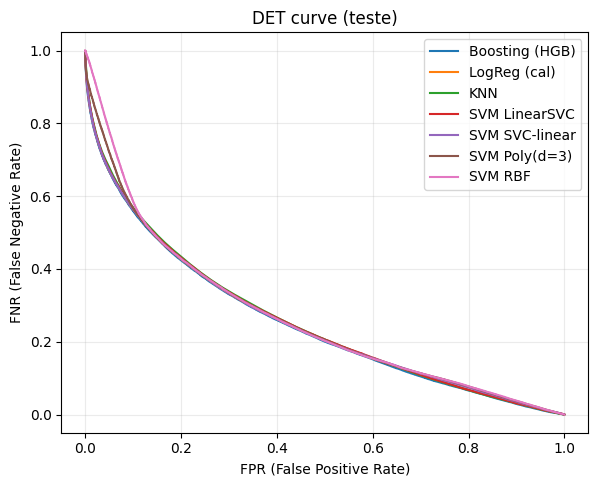

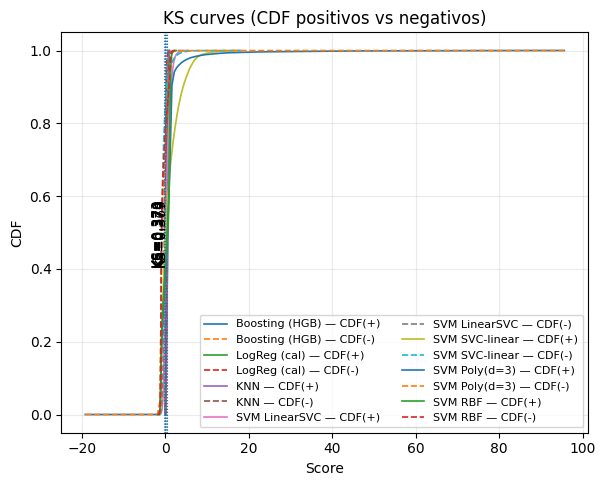

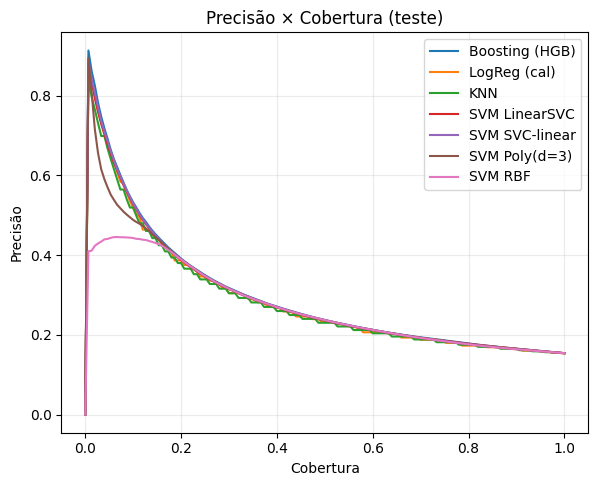

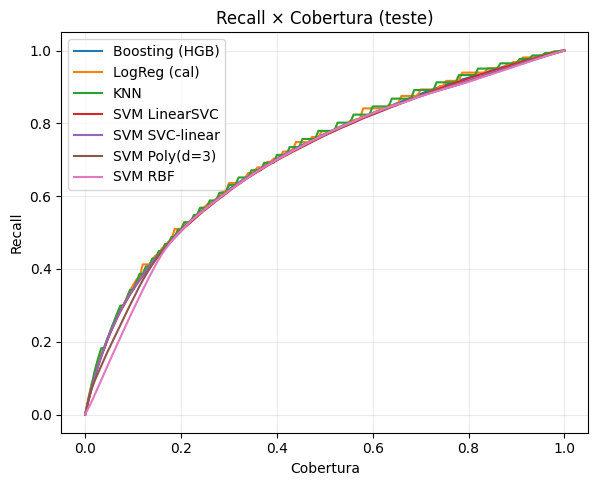

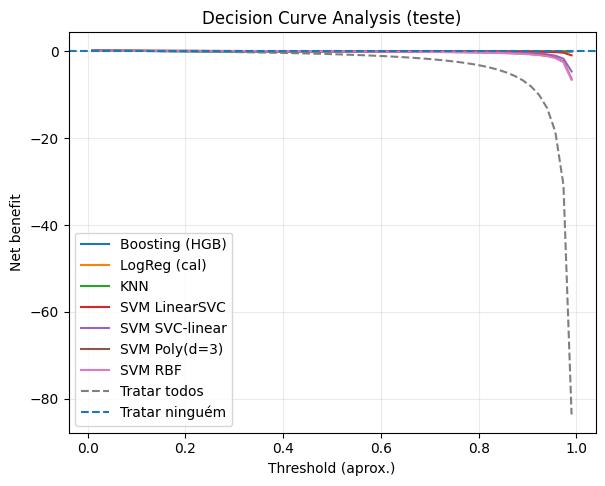

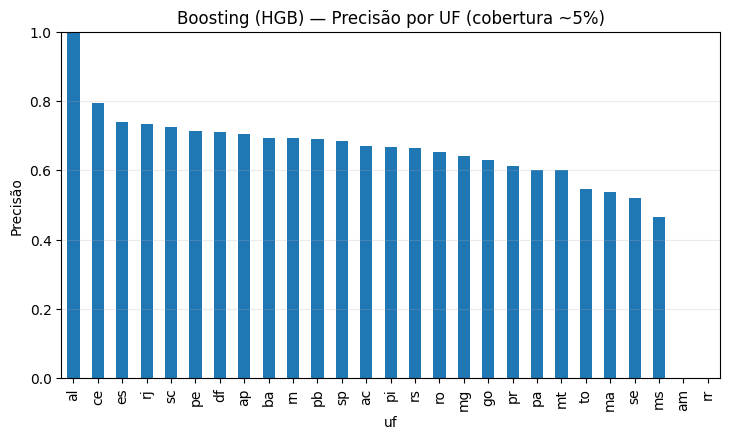

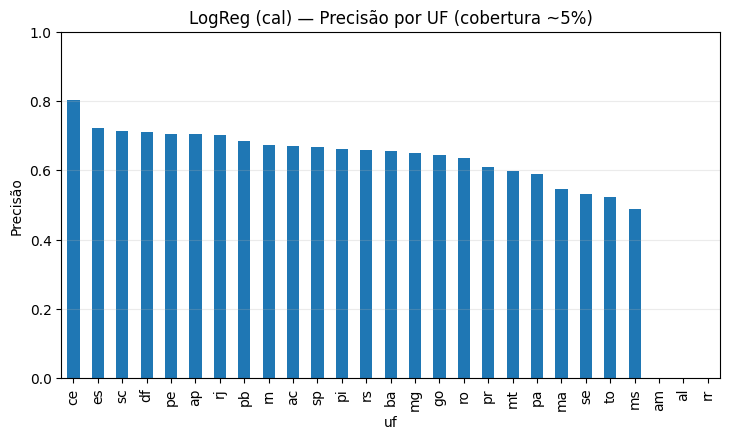

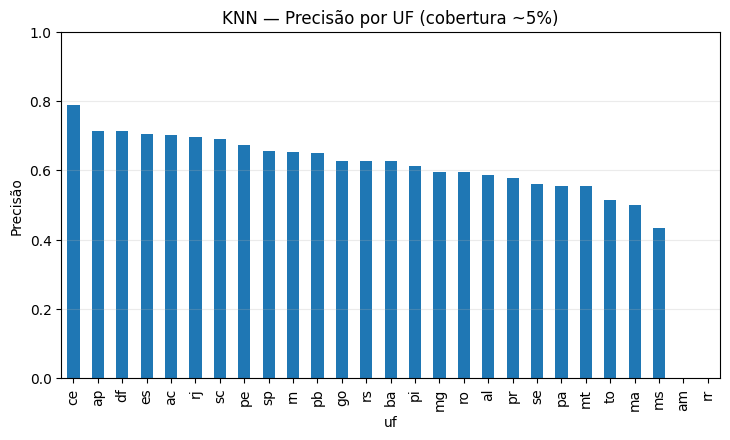

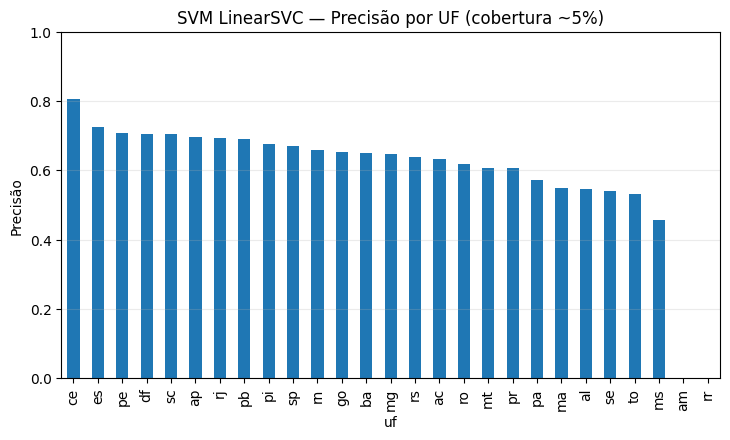

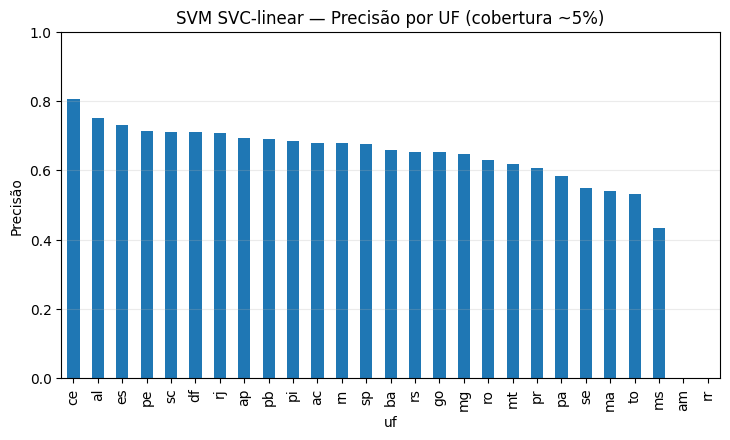

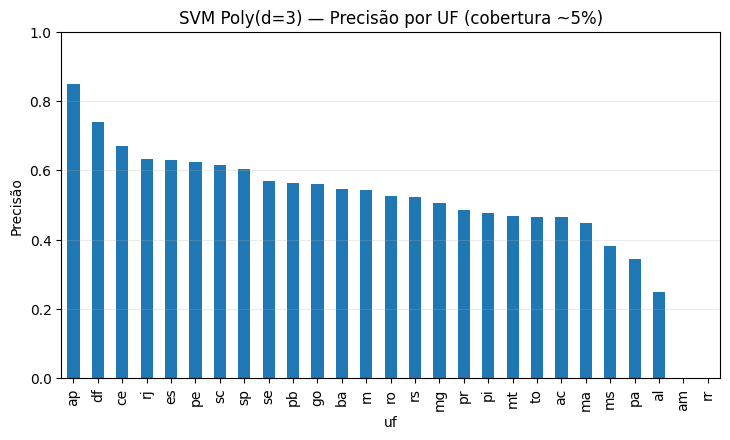

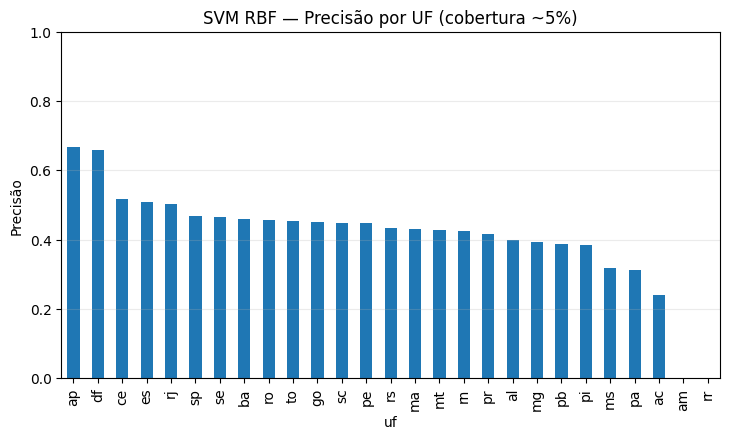

In [33]:
# ============================================
# Comparações extras: DET, KS, Prec×Cobertura, Decision Curve, Per-UF
# Requer: y_true (pd.Series ou array 0/1) e models: dict[str] -> scores (np.array)
# ============================================
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, det_curve, precision_recall_curve

# ---- helpers ----
def as_series(y):
    return y if isinstance(y, pd.Series) else pd.Series(y)

y_true_s = as_series(y_true).astype(int)

def sweep_precision_coverage(y, s, n=101):
    # cobertura c in [0,1]: limiar = quantil(1-c)
    y = np.asarray(y, int); s = np.asarray(s, float)
    covs = np.linspace(0.0, 1.0, n)
    precs, recs, thrs = [], [], []
    for c in covs:
        thr = np.quantile(s, 1.0 - c) if c > 0 else np.inf
        pred = (s >= thr).astype(int) if c > 0 else np.zeros_like(s)
        tp = ((pred == 1) & (y == 1)).sum()
        fp = ((pred == 1) & (y == 0)).sum()
        fn = ((pred == 0) & (y == 1)).sum()
        prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        rec  = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        precs.append(prec); recs.append(rec); thrs.append(thr)
    return np.array(covs), np.array(precs), np.array(recs), np.array(thrs)

def ks_statistic(y, s, nbins=200):
    # KS: max|CDF_pos - CDF_neg|
    y = np.asarray(y, int); s = np.asarray(s, float)
    grid = np.linspace(s.min(), s.max(), nbins)
    pos = s[y == 1]; neg = s[y == 0]
    cdf_pos = np.searchsorted(np.sort(pos), grid, side="right") / max(1, len(pos))
    cdf_neg = np.searchsorted(np.sort(neg), grid, side="right") / max(1, len(neg))
    ks = np.max(np.abs(cdf_pos - cdf_neg))
    x_at = grid[np.argmax(np.abs(cdf_pos - cdf_neg))]
    return ks, x_at, grid, cdf_pos, cdf_neg

def net_benefit(y, s, thr):
    """
    Decision Curve Analysis simplificada.
    Interpretação: benefício líquido = TP/N - (FP/N)*w, com w = p_t/(1-p_t),
    onde p_t é o threshold em probabilidade (aqui aproximamos score como prob).
    """
    y = np.asarray(y, int); s = np.asarray(s, float)
    p_t = np.clip(thr, 1e-6, 1-1e-6)
    w = p_t / (1 - p_t)
    pred = (s >= thr).astype(int)
    N = len(y)
    tp = ((pred == 1) & (y == 1)).sum()
    fp = ((pred == 1) & (y == 0)).sum()
    return tp / N - w * (fp / N)

# ========== 1) DET curve ==========
plt.figure(figsize=(6.8, 5.2))
for name, scores in models.items():
    try:
        fpr, fnr, _ = det_curve(y_true_s, scores)
        plt.plot(fpr, fnr, label=name)
    except Exception:
        pass
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("FNR (False Negative Rate)")
plt.title("DET curve (teste)")
plt.grid(True, alpha=0.25)
plt.legend()
plt.show()

# ========== 2) KS statistic ==========
fig, ax = plt.subplots(1, 1, figsize=(6.8, 5.2))
for name, scores in models.items():
    ks, x_at, grid, cdf_pos, cdf_neg = ks_statistic(y_true_s, scores)
    ax.plot(grid, cdf_pos, lw=1.2, label=f"{name} — CDF(+)")
    ax.plot(grid, cdf_neg, lw=1.2, ls="--", label=f"{name} — CDF(-)")
    ax.axvline(x_at, ls=":", lw=0.8)
    ax.text(x_at, 0.5, f"KS={ks:.3f}", rotation=90, va="center", ha="right")
ax.set_xlabel("Score"); ax.set_ylabel("CDF")
ax.set_title("KS curves (CDF positivos vs negativos)")
ax.grid(True, alpha=0.25); ax.legend(ncol=2, fontsize=8)
plt.show()

# ========== 3) Precision × Coverage ==========
plt.figure(figsize=(6.8, 5.2))
for name, scores in models.items():
    cov, prec, rec, _ = sweep_precision_coverage(y_true_s, scores, n=151)
    plt.plot(cov, prec, label=name)
plt.xlabel("Cobertura"); plt.ylabel("Precisão")
plt.title("Precisão × Cobertura (teste)")
plt.grid(True, alpha=0.25); plt.legend()
plt.show()

# (bônus) Recall × Cobertura
plt.figure(figsize=(6.8, 5.2))
for name, scores in models.items():
    cov, prec, rec, _ = sweep_precision_coverage(y_true_s, scores, n=151)
    plt.plot(cov, rec, label=name)
plt.xlabel("Cobertura"); plt.ylabel("Recall")
plt.title("Recall × Cobertura (teste)")
plt.grid(True, alpha=0.25); plt.legend()
plt.show()

# ========== 4) Decision Curve (Net Benefit) ==========
ths = np.linspace(0.01, 0.99, 60)
plt.figure(figsize=(6.8, 5.2))
for name, scores in models.items():
    nb = [net_benefit(y_true_s, scores, t) for t in ths]
    plt.plot(ths, nb, label=name)
# linhas de referência
base = y_true_s.mean()
treat_all = [base - (t/(1-t))*(1-base) for t in ths]
plt.plot(ths, treat_all, ls="--", label="Tratar todos")
plt.axhline(0, ls="--", label="Tratar ninguém")
plt.xlabel("Threshold (aprox.)"); plt.ylabel("Net benefit")
plt.title("Decision Curve Analysis (teste)")
plt.grid(True, alpha=0.25); plt.legend()
plt.show()

# ========== 5) Per-UF @ cobertura fixa (ex.: 5%) — versão sem warnings ==========
coverage = 0.05
uf_vec = None
try:
    uf_vec = ufs[~is_train].reset_index(drop=True)  # do seu pipeline
except Exception:
    pass

if uf_vec is not None:
    uf_vec = pd.Series(uf_vec, name="uf").astype(str)

    for name, scores in models.items():
        thr = np.quantile(scores, 1.0 - coverage)
        df = pd.DataFrame({
            "uf": uf_vec,
            "y":  y_true_s.to_numpy().astype(int),
            "pred": (np.asarray(scores, float) >= thr).astype(int)
        })

        g = df.groupby("uf")
        tp       = g.apply(lambda t: ((t["pred"]==1) & (t["y"]==1)).sum(), include_groups=False)
        pred_pos = g["pred"].sum()
        pos      = g["y"].sum()
        n        = g.size()

        rep = pd.DataFrame({
            "prec": (tp / pred_pos.replace(0, np.nan)),
            "rec" : (tp / pos.replace(0, np.nan)),
            "cov" : (pred_pos / n),
            "base": (pos / n)
        }).fillna(0.0).sort_values("prec", ascending=False)

        plt.figure(figsize=(8.5, 4.5))
        rep["prec"].plot(kind="bar")
        plt.ylim(0, 1)
        plt.ylabel("Precisão")
        plt.title(f"{name} — Precisão por UF (cobertura ~{int(coverage*100)}%)")
        plt.grid(True, axis="y", alpha=0.25)
        plt.show()



## Conclusões — Comparativo de Modelos (incluindo SVMs)

**Tarefa.** Predição semanal de ocorrência (y\_{t+1} ≥ 1) por segmento de 5 km com histórico, sazonalidade, vizinhança (±5/±10 km), janelas longas e feriados. Avaliamos no **teste 2024** com métricas orientadas a ranking (ROC-AUC, PR-AUC, P@K/Lift@K) e **trade-offs operacionais** (matrizes de confusão no **limiar de F1\*** e em **coberturas fixas** de 1% e 5%).

---

### 1) Quem performou melhor?

- **Boosting (HGB)** foi o **melhor individual** de forma consistente (PR-AUC ≈ **0,456**; ROC-AUC ≈ 0,748), com Top-K e precisão em coberturas fixas superiores.
- **SVM linear** (tanto `SVC(kernel='linear')` quanto `LinearSVC`) ficou **muito próximo da LogReg calibrada**:
  - PR-AUC ≈ **0,445–0,449**, praticamente empatado com **LogReg (cal)** (≈ **0,444**).
  - Em **Top-K**, os três (HGB, LogReg cal e SVM linear) apresentam **precisões altas**, úteis para priorização.
- **SVM com kernel polinomial (d=3)** ficou **abaixo** do linear (PR-AUC ≈ 0,415).
- **SVM com kernel RBF** teve **desempenho fraco** neste cenário (PR-AUC ≈ 0,343). Em dados tabulares grandes com muitas features quase lineares, kernels não lineares tendem a **não compensar** sem tuning pesado e/ou transformação de atributos.

**Resumo:**  
> **HGB** > (**SVM linear** ≈ **LogReg cal**) > **KNN** > **SVM poly** >> **SVM RBF**

---

### 2) Trade-offs operacionais (matrizes de confusão)

- **Limiar de F1\*** (aprox. 17–18% de cobertura para HGB/LogReg/SVM linear):
  - Precisão ≈ **0,41–0,42**, Recall ≈ **0,47–0,48**, F1 ≈ **0,44** nos três modelos principais.
  - Interpretação: bom equilíbrio quando queremos **cobrir** mais casos mantendo precisão estável.

- **Cobertura 1%** (priorização extrema):
  - **Precisões muito altas** (≈ **0,86–0,89**) e **recall baixo** (≈ **0,06**), como esperado: serve para **operações de choque**/alocação de equipes muito limitada.

- **Cobertura 5%**:
  - Precisão ≈ **0,67** e **recall ≈ 0,22** (HGB/LogReg/SVM linear muito próximos).  
  - Boa opção de **priorização prática**: ainda seletiva, mas já captura uma fração significativa de positivos.

---

### 3) Por que o SVM linear deu certo (e os kernels não)?

- As **features já carregam linearidades fortes** (lags, médias móveis, EWMA, sazonalidade, vizinhança).  
- O **margem-maximizador** do SVM linear e a **LogReg** (com regularização + calibração) **empatam** em datasets tabulares grandes.  
- Kernels **poly/RBF** exigem tuning amplo (`C`, `gamma`, `degree`, `coef0`) e **são caros** no volume presente; sem um ganho claro, **não compensam** aqui.

---

### 4) Conclusão

- O **acréscimo de SVMs** foi **bem-sucedido**: o **SVM linear** junto com HGB e LogReg cal assume os melhores resultados e **reforça** a robustez do pipeline.  
- Para **priorização operacional**, os três principais modelos apresentam **precision/Lift** excelentes em Top-K e **muito bons** em **coberturas 1–5%**, o que **tangibiliza** a utilidade prática para alocação semanal de recursos.
